In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import seaborn as sns
import os
import time
import seaborn as sns

In [21]:
# Set random seed for reproducibility
random_state = 42
random.seed(random_state)

In [22]:
path='/home/jupyter/Patch_extraction/'
base = '/home/jupyter/Patch_extraction/'

In [23]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [24]:
def patch_selection(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            # if len(files1) > 100:
            #     selected_files = random.sample(files1, 100)
            # else:
            selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [25]:
def patch_selection_remaining(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            if len(files1) > 100:
                selected_files = random.sample(files1, 100)
            else:
                selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass


        return patch_paths, labels, slide_ids

In [26]:


# Set random seed for reproducibility
random_state = 42
random.seed(random_state)



train_patch_ids = []
train_labels = []
train_slide_ids = []

val_patch_ids = []
val_labels = []
val_slide_ids = []

test_patch_ids = []
test_labels = []
test_slide_ids = []

remaining_patch_ids = []
remaining_labels = []
remaining_slide_ids = []


for i in range(0, 15):
    # List all file IDs in the directory
    ids = os.listdir(base + '/' + str(i) + '/')
    ids_1=ids
    
    # Ensure at most 10 slides are selected
    if len(ids) > 15:
        ids = random.sample(ids, 15)

    # Split the IDs into training, validation, and test sets
    train_ids_1, test_ids = train_test_split(ids, test_size=0.30, random_state=42)
    train_ids, val_ids = train_test_split(train_ids_1, test_size=0.20, random_state=42)
    
    # Get remaining slides
    selected_ids = set(train_ids + val_ids)
    remaining_ids = [id_ for id_ in ids_1 if id_ not in selected_ids]
    
    # Assuming patch_selection function selects patches from given ids and class index
    train_patch_id, train_label, train_slide_id = patch_selection(train_ids, i)
    val_patch_id, val_label, val_slide_id = patch_selection(val_ids, i)
    test_patch_id, test_label, test_slide_id = patch_selection(test_ids, i)
    remaining_patch_id, remaining_label, remaining_slide_id = patch_selection_remaining(remaining_ids, i)
    
    train_patch_ids.extend(train_patch_id)
    train_labels.extend(train_label)
    train_slide_ids.extend(train_slide_id)
    
    val_patch_ids.extend(val_patch_id)
    val_labels.extend(val_label)
    val_slide_ids.extend(val_slide_id)
    
    test_patch_ids.extend(test_patch_id)
    test_labels.extend(test_label)
    test_slide_ids.extend(test_slide_id)
    
    remaining_patch_ids.extend(remaining_patch_id)
    remaining_labels.extend(remaining_label)
    remaining_slide_ids.extend(remaining_slide_id)

       
# Print some results to verify
print(f"Total training patches: {len(train_patch_ids)}")
print(f"Total validation patches: {len(val_patch_ids)}")
print(f"Total testing patches: {len(test_patch_ids)}")
print(f"Total remaining patches: {len(remaining_patch_ids)}")

  0%|          | 0/4 [00:00<?, ?it/s]

Total training patches: 304944
Total validation patches: 77171
Total testing patches: 191338
Total remaining patches: 1500


In [8]:
# # Define transformations
# transform = transforms.ToTensor()


# # Function to calculate mean and std
# def calculate_mean_std(image_paths):
#     mean = np.zeros(3)
#     std = np.zeros(3)
#     num_images = len(image_paths)

#     for img_path in image_paths:
#         image = Image.open(img_path)
#         tensor = transform(image)
#         mean += tensor.mean([1, 2]).numpy()
#         std += tensor.std([1, 2]).numpy()

#     mean /= num_images
#     std /= num_images

#     return mean, std


# # Combine all image paths
# all_image_paths = train_patch_ids + val_patch_ids + test_patch_ids

# # Calculate mean and std
# mean, std = calculate_mean_std(all_image_paths)

# print(f'Mean: {mean}')
# print(f'Std: {std}')

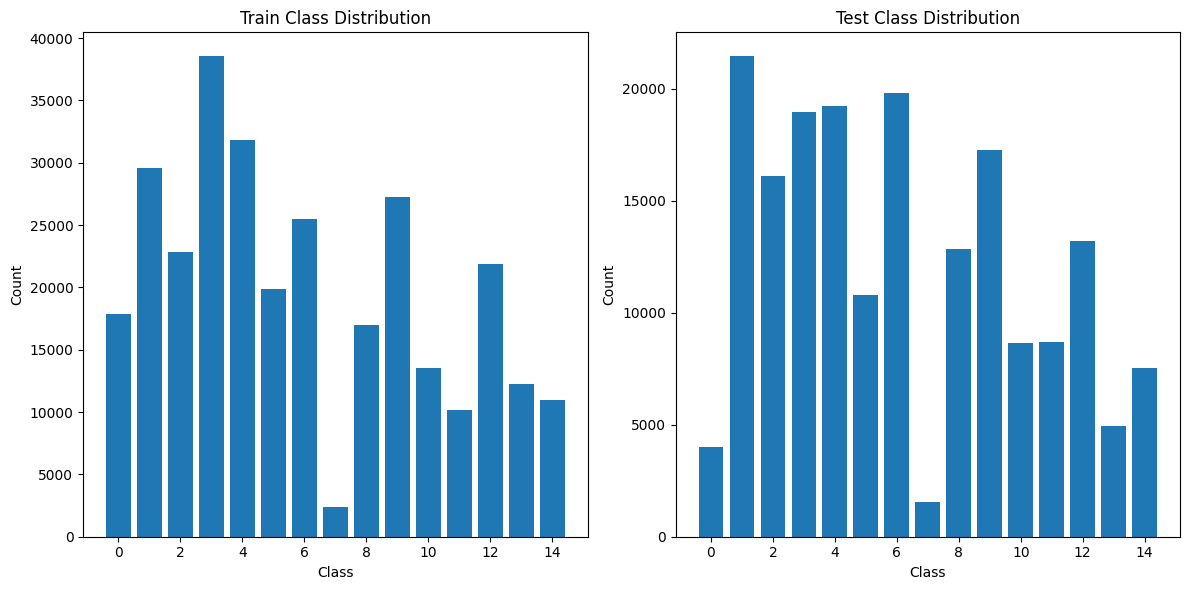

Train class distribution: [17856. 29546. 22858. 38534. 31848. 19839. 25455.  2406. 16952. 27267.
 13530. 10179. 21864. 12248. 10994.]
Test class distribution: [ 4013. 21435. 16074. 18933. 19231. 10772. 19792.  1536. 12852. 17250.
  8642.  8676. 13205.  4951.  7524.]


In [9]:
def get_class_distribution_from_filenames(filenames, custom_classes):
    class_counts = np.zeros(len(custom_classes))
    class_map = {cls: idx for idx, cls in enumerate(custom_classes)}
    
    for filename in filenames:
        # Extract class label from the directory name
        class_label = int(os.path.basename(os.path.dirname(os.path.dirname(filename))))
        if class_label in class_map:
            class_counts[class_map[class_label]] += 1
    
    return class_counts

# Define your custom range of class labels
custom_range = list(range(0, 15))

# Assuming train_patch_ids and test_patch_ids are lists of image paths for training and testing
train_class_distribution = get_class_distribution_from_filenames(train_patch_ids, custom_range)
test_class_distribution = get_class_distribution_from_filenames(test_patch_ids, custom_range)

# Plotting class distributions
classes = np.array(custom_range)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(classes, train_class_distribution)
plt.title('Train Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(classes, test_class_distribution)

plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print distributions as arrays
print("Train class distribution:", train_class_distribution)
print("Test class distribution:", test_class_distribution)


In [10]:

# Assuming train_patch_ids, train_labels, train_slide_ids, test_patch_ids, test_labels, and test_slide_ids are lists of image paths, labels, and slide IDs for training and testing
# Create dataset and dataloader
class TissueDataset(Dataset):
    def __init__(self, image_paths, labels, slide_ids, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.slide_ids = slide_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        slide_id = self.slide_ids[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, slide_id
 


In [11]:
# Define the data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Create dataset and dataloader
train_dataset = TissueDataset(train_patch_ids, train_labels, train_slide_ids, transform=train_transform)
val_dataset = TissueDataset(val_patch_ids, val_labels, val_slide_ids, transform=val_transform)
test_dataset = TissueDataset(test_patch_ids, test_labels, test_slide_ids, transform=val_transform)
remaining_dataset = TissueDataset(remaining_patch_ids, remaining_labels, remaining_slide_ids, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
remaining_loader = DataLoader(remaining_dataset, batch_size=128, shuffle=False, num_workers=4)



In [12]:
print(len(train_loader))

2355


In [13]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
def training(train_loader, val_loader, learn_rate, EPOCHS, model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Use DataParallel for multi-GPU support
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learn_rate)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        epoch_start_time = time.time()

        # Initialize tqdm progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')

        for batch_idx, (inputs, labels, slide_ids) in enumerate(train_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            batch_acc = running_corrects.double() / ((batch_idx + 1) * train_loader.batch_size)

            # Calculate and display ETA
            batch_end_time = time.time()
            batch_duration = batch_end_time - epoch_start_time
            eta = batch_duration * (len(train_loader) - batch_idx - 1) / (batch_idx + 1)

            # Update tqdm progress bar with current loss, accuracy, and ETA
            train_loader_tqdm.set_postfix(
                loss=batch_loss,
                accuracy=batch_acc.item(),
                ETA=f"{eta/60:.2f} min"
            )

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels, slide_ids in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # Save the model at the end of each epoch if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs")
            break

    return model

In [15]:
# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=17):
#         super(ClassificationModel, self).__init__()
#         base_model = models.efficientnet_b0(pretrained=True)
#         self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(base_model.classifier[1].in_features, 2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048),
#             nn.Dropout(0.5),
#             nn.Linear(2048, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False

In [16]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes=15):
        super(ClassificationModel, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.batch_norm = nn.BatchNorm2d(3, affine=False)  # Assuming the input has 3 channels (RGB)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[1].in_features, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.batch_norm(x)  # Apply batch normalization to the input
        x = self.features(x)
        x = self.classifier(x)
        return x

def freezing_layers(model):
    for param in model.features.parameters():
        param.requires_grad = False


In [20]:
num_classes=15

# model = ClassificationModel(num_classes=15)
# freezing_layers(model)

# learn_rate = 0.001
# EPOCHS = 2
# filename = 'efficientnet_b0_15_class.pth'

# model = training(train_loader, val_loader, learn_rate, EPOCHS, model, filename)



In [18]:
# Load the best model for evaluation
filename = 'efficientnet_b0_15_class.pth'

model = ClassificationModel(num_classes=15)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

    
model.load_state_dict(torch.load(filename))


# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model.eval()


test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(test_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Evaluating:   0%|          | 1/1445 [00:29<11:43:45, 29.24s/batch]

Batch Loss: 3.6299, Batch Accuracy: 0.1797


Evaluating:   0%|          | 2/1445 [00:53<10:31:35, 26.26s/batch]

Batch Loss: 3.6761, Batch Accuracy: 0.1445


Evaluating:   0%|          | 3/1445 [01:16<10:00:31, 24.99s/batch]

Batch Loss: 3.1621, Batch Accuracy: 0.2135


Evaluating:   0%|          | 4/1445 [01:38<9:31:16, 23.79s/batch] 

Batch Loss: 2.9978, Batch Accuracy: 0.2363


Evaluating:   0%|          | 5/1445 [02:00<9:12:22, 23.02s/batch]

Batch Loss: 2.8282, Batch Accuracy: 0.2437


Evaluating:   0%|          | 6/1445 [02:21<8:54:09, 22.27s/batch]

Batch Loss: 2.7551, Batch Accuracy: 0.2448


Evaluating:   0%|          | 7/1445 [02:40<8:29:40, 21.27s/batch]

Batch Loss: 2.5562, Batch Accuracy: 0.3002


Evaluating:   1%|          | 8/1445 [03:01<8:28:40, 21.24s/batch]

Batch Loss: 2.3526, Batch Accuracy: 0.3672


Evaluating:   1%|          | 9/1445 [03:22<8:23:04, 21.02s/batch]

Batch Loss: 2.2493, Batch Accuracy: 0.4123


Evaluating:   1%|          | 10/1445 [03:43<8:26:58, 21.20s/batch]

Batch Loss: 2.1466, Batch Accuracy: 0.4484


Evaluating:   1%|          | 11/1445 [04:04<8:26:23, 21.19s/batch]

Batch Loss: 2.0236, Batch Accuracy: 0.4808


Evaluating:   1%|          | 12/1445 [04:24<8:13:03, 20.64s/batch]

Batch Loss: 1.9260, Batch Accuracy: 0.5104


Evaluating:   1%|          | 13/1445 [04:45<8:15:50, 20.78s/batch]

Batch Loss: 1.8490, Batch Accuracy: 0.5355


Evaluating:   1%|          | 14/1445 [05:07<8:24:46, 21.16s/batch]

Batch Loss: 1.7825, Batch Accuracy: 0.5552


Evaluating:   1%|          | 15/1445 [05:27<8:18:16, 20.91s/batch]

Batch Loss: 1.7520, Batch Accuracy: 0.5703


Evaluating:   1%|          | 16/1445 [05:49<8:23:15, 21.13s/batch]

Batch Loss: 1.6951, Batch Accuracy: 0.5820


Evaluating:   1%|          | 17/1445 [06:10<8:25:35, 21.24s/batch]

Batch Loss: 1.6505, Batch Accuracy: 0.5960


Evaluating:   1%|          | 18/1445 [06:30<8:12:18, 20.70s/batch]

Batch Loss: 1.6233, Batch Accuracy: 0.6063


Evaluating:   1%|▏         | 19/1445 [06:51<8:11:09, 20.67s/batch]

Batch Loss: 1.5680, Batch Accuracy: 0.6197


Evaluating:   1%|▏         | 20/1445 [07:12<8:14:59, 20.84s/batch]

Batch Loss: 1.5520, Batch Accuracy: 0.6285


Evaluating:   1%|▏         | 21/1445 [07:33<8:15:39, 20.88s/batch]

Batch Loss: 1.5171, Batch Accuracy: 0.6350


Evaluating:   2%|▏         | 22/1445 [07:54<8:17:44, 20.99s/batch]

Batch Loss: 1.4835, Batch Accuracy: 0.6388


Evaluating:   2%|▏         | 23/1445 [08:15<8:15:03, 20.89s/batch]

Batch Loss: 1.4473, Batch Accuracy: 0.6457


Evaluating:   2%|▏         | 24/1445 [08:35<8:10:35, 20.71s/batch]

Batch Loss: 1.4189, Batch Accuracy: 0.6491


Evaluating:   2%|▏         | 25/1445 [08:55<8:05:09, 20.50s/batch]

Batch Loss: 1.3976, Batch Accuracy: 0.6497


Evaluating:   2%|▏         | 26/1445 [09:16<8:05:14, 20.52s/batch]

Batch Loss: 1.3713, Batch Accuracy: 0.6541


Evaluating:   2%|▏         | 27/1445 [09:37<8:14:31, 20.93s/batch]

Batch Loss: 1.3472, Batch Accuracy: 0.6574


Evaluating:   2%|▏         | 28/1445 [09:58<8:11:41, 20.82s/batch]

Batch Loss: 1.3254, Batch Accuracy: 0.6602


Evaluating:   2%|▏         | 29/1445 [10:18<8:03:15, 20.48s/batch]

Batch Loss: 1.3306, Batch Accuracy: 0.6557


Evaluating:   2%|▏         | 30/1445 [10:39<8:12:44, 20.89s/batch]

Batch Loss: 1.3541, Batch Accuracy: 0.6474


Evaluating:   2%|▏         | 31/1445 [11:01<8:15:17, 21.02s/batch]

Batch Loss: 1.3781, Batch Accuracy: 0.6379


Evaluating:   2%|▏         | 32/1445 [11:22<8:14:30, 21.00s/batch]

Batch Loss: 1.4438, Batch Accuracy: 0.6235


Evaluating:   2%|▏         | 33/1445 [11:44<8:21:37, 21.32s/batch]

Batch Loss: 1.5488, Batch Accuracy: 0.6065


Evaluating:   2%|▏         | 34/1445 [12:05<8:18:38, 21.20s/batch]

Batch Loss: 1.6410, Batch Accuracy: 0.5894


Evaluating:   2%|▏         | 35/1445 [12:26<8:16:15, 21.12s/batch]

Batch Loss: 1.7176, Batch Accuracy: 0.5739


Evaluating:   2%|▏         | 36/1445 [12:46<8:11:09, 20.91s/batch]

Batch Loss: 1.7979, Batch Accuracy: 0.5595


Evaluating:   3%|▎         | 37/1445 [13:07<8:12:08, 20.97s/batch]

Batch Loss: 1.8606, Batch Accuracy: 0.5460


Evaluating:   3%|▎         | 38/1445 [13:28<8:11:45, 20.97s/batch]

Batch Loss: 1.9346, Batch Accuracy: 0.5341


Evaluating:   3%|▎         | 39/1445 [13:49<8:09:09, 20.87s/batch]

Batch Loss: 1.9913, Batch Accuracy: 0.5222


Evaluating:   3%|▎         | 40/1445 [14:09<8:05:54, 20.75s/batch]

Batch Loss: 2.0552, Batch Accuracy: 0.5104


Evaluating:   3%|▎         | 41/1445 [14:29<7:58:20, 20.44s/batch]

Batch Loss: 2.1157, Batch Accuracy: 0.4992


Evaluating:   3%|▎         | 42/1445 [14:50<8:02:44, 20.64s/batch]

Batch Loss: 2.1836, Batch Accuracy: 0.4885


Evaluating:   3%|▎         | 43/1445 [15:11<8:07:06, 20.85s/batch]

Batch Loss: 2.2271, Batch Accuracy: 0.4787


Evaluating:   3%|▎         | 44/1445 [15:32<8:06:04, 20.82s/batch]

Batch Loss: 2.2783, Batch Accuracy: 0.4693


Evaluating:   3%|▎         | 45/1445 [15:54<8:09:13, 20.97s/batch]

Batch Loss: 2.3286, Batch Accuracy: 0.4595


Evaluating:   3%|▎         | 46/1445 [16:13<7:59:41, 20.57s/batch]

Batch Loss: 2.3819, Batch Accuracy: 0.4504


Evaluating:   3%|▎         | 47/1445 [16:33<7:53:49, 20.34s/batch]

Batch Loss: 2.4281, Batch Accuracy: 0.4418


Evaluating:   3%|▎         | 48/1445 [16:54<7:58:37, 20.56s/batch]

Batch Loss: 2.4717, Batch Accuracy: 0.4334


Evaluating:   3%|▎         | 49/1445 [17:14<7:56:18, 20.47s/batch]

Batch Loss: 2.5129, Batch Accuracy: 0.4252


Evaluating:   3%|▎         | 50/1445 [17:36<8:03:20, 20.79s/batch]

Batch Loss: 2.5449, Batch Accuracy: 0.4178


Evaluating:   4%|▎         | 51/1445 [17:57<8:05:48, 20.91s/batch]

Batch Loss: 2.5825, Batch Accuracy: 0.4107


Evaluating:   4%|▎         | 52/1445 [18:16<7:53:47, 20.41s/batch]

Batch Loss: 2.6174, Batch Accuracy: 0.4038


Evaluating:   4%|▎         | 53/1445 [18:37<7:53:30, 20.41s/batch]

Batch Loss: 2.6455, Batch Accuracy: 0.3971


Evaluating:   4%|▎         | 54/1445 [18:57<7:54:39, 20.47s/batch]

Batch Loss: 2.6649, Batch Accuracy: 0.3932


Evaluating:   4%|▍         | 55/1445 [19:18<7:58:23, 20.65s/batch]

Batch Loss: 2.6208, Batch Accuracy: 0.4024


Evaluating:   4%|▍         | 56/1445 [19:39<7:59:11, 20.70s/batch]

Batch Loss: 2.5813, Batch Accuracy: 0.4110


Evaluating:   4%|▍         | 57/1445 [19:59<7:49:45, 20.31s/batch]

Batch Loss: 2.5425, Batch Accuracy: 0.4184


Evaluating:   4%|▍         | 58/1445 [20:19<7:50:16, 20.34s/batch]

Batch Loss: 2.5056, Batch Accuracy: 0.4261


Evaluating:   4%|▍         | 59/1445 [20:41<7:59:32, 20.76s/batch]

Batch Loss: 2.4697, Batch Accuracy: 0.4334


Evaluating:   4%|▍         | 60/1445 [21:01<7:58:33, 20.73s/batch]

Batch Loss: 2.4356, Batch Accuracy: 0.4410


Evaluating:   4%|▍         | 61/1445 [21:22<7:57:21, 20.69s/batch]

Batch Loss: 2.4012, Batch Accuracy: 0.4486


Evaluating:   4%|▍         | 62/1445 [21:43<8:01:07, 20.87s/batch]

Batch Loss: 2.3695, Batch Accuracy: 0.4558


Evaluating:   4%|▍         | 63/1445 [22:02<7:42:50, 20.09s/batch]

Batch Loss: 2.3362, Batch Accuracy: 0.4630


Evaluating:   4%|▍         | 64/1445 [22:21<7:39:54, 19.98s/batch]

Batch Loss: 2.3045, Batch Accuracy: 0.4692


Evaluating:   4%|▍         | 65/1445 [22:42<7:47:57, 20.35s/batch]

Batch Loss: 2.2758, Batch Accuracy: 0.4755


Evaluating:   5%|▍         | 66/1445 [23:03<7:49:15, 20.42s/batch]

Batch Loss: 2.2478, Batch Accuracy: 0.4811


Evaluating:   5%|▍         | 67/1445 [23:24<7:50:47, 20.50s/batch]

Batch Loss: 2.2202, Batch Accuracy: 0.4864


Evaluating:   5%|▍         | 68/1445 [23:43<7:39:14, 20.01s/batch]

Batch Loss: 2.1934, Batch Accuracy: 0.4922


Evaluating:   5%|▍         | 69/1445 [24:03<7:42:42, 20.18s/batch]

Batch Loss: 2.1661, Batch Accuracy: 0.4980


Evaluating:   5%|▍         | 70/1445 [24:24<7:47:20, 20.39s/batch]

Batch Loss: 2.1415, Batch Accuracy: 0.5036


Evaluating:   5%|▍         | 71/1445 [24:45<7:51:43, 20.60s/batch]

Batch Loss: 2.1163, Batch Accuracy: 0.5089


Evaluating:   5%|▍         | 72/1445 [25:06<7:52:20, 20.64s/batch]

Batch Loss: 2.0927, Batch Accuracy: 0.5139


Evaluating:   5%|▌         | 73/1445 [25:25<7:40:06, 20.12s/batch]

Batch Loss: 2.0676, Batch Accuracy: 0.5196


Evaluating:   5%|▌         | 74/1445 [25:46<7:45:39, 20.38s/batch]

Batch Loss: 2.0469, Batch Accuracy: 0.5238


Evaluating:   5%|▌         | 75/1445 [26:07<7:49:44, 20.57s/batch]

Batch Loss: 2.0232, Batch Accuracy: 0.5286


Evaluating:   5%|▌         | 76/1445 [26:28<7:51:18, 20.66s/batch]

Batch Loss: 2.0041, Batch Accuracy: 0.5326


Evaluating:   5%|▌         | 77/1445 [26:49<7:54:01, 20.79s/batch]

Batch Loss: 1.9832, Batch Accuracy: 0.5370


Evaluating:   5%|▌         | 78/1445 [27:10<7:55:19, 20.86s/batch]

Batch Loss: 1.9636, Batch Accuracy: 0.5412


Evaluating:   5%|▌         | 79/1445 [27:29<7:43:12, 20.35s/batch]

Batch Loss: 1.9445, Batch Accuracy: 0.5451


Evaluating:   6%|▌         | 80/1445 [27:50<7:49:56, 20.66s/batch]

Batch Loss: 1.9258, Batch Accuracy: 0.5488


Evaluating:   6%|▌         | 81/1445 [28:11<7:51:02, 20.72s/batch]

Batch Loss: 1.9069, Batch Accuracy: 0.5532


Evaluating:   6%|▌         | 82/1445 [28:32<7:50:12, 20.70s/batch]

Batch Loss: 1.8880, Batch Accuracy: 0.5571


Evaluating:   6%|▌         | 83/1445 [28:53<7:54:00, 20.88s/batch]

Batch Loss: 1.8691, Batch Accuracy: 0.5613


Evaluating:   6%|▌         | 84/1445 [29:13<7:49:32, 20.70s/batch]

Batch Loss: 1.8512, Batch Accuracy: 0.5651


Evaluating:   6%|▌         | 85/1445 [29:33<7:44:44, 20.50s/batch]

Batch Loss: 1.8351, Batch Accuracy: 0.5686


Evaluating:   6%|▌         | 86/1445 [29:53<7:39:30, 20.29s/batch]

Batch Loss: 1.8171, Batch Accuracy: 0.5724


Evaluating:   6%|▌         | 87/1445 [30:15<7:46:59, 20.63s/batch]

Batch Loss: 1.7995, Batch Accuracy: 0.5761


Evaluating:   6%|▌         | 88/1445 [30:36<7:52:34, 20.90s/batch]

Batch Loss: 1.7848, Batch Accuracy: 0.5792


Evaluating:   6%|▌         | 89/1445 [30:57<7:52:00, 20.89s/batch]

Batch Loss: 1.7683, Batch Accuracy: 0.5825


Evaluating:   6%|▌         | 90/1445 [31:17<7:42:29, 20.48s/batch]

Batch Loss: 1.7750, Batch Accuracy: 0.5817


Evaluating:   6%|▋         | 91/1445 [31:39<7:52:18, 20.93s/batch]

Batch Loss: 1.7836, Batch Accuracy: 0.5802


Evaluating:   6%|▋         | 92/1445 [31:59<7:50:35, 20.87s/batch]

Batch Loss: 1.7929, Batch Accuracy: 0.5782


Evaluating:   6%|▋         | 93/1445 [32:20<7:51:28, 20.92s/batch]

Batch Loss: 1.8010, Batch Accuracy: 0.5764


Evaluating:   7%|▋         | 94/1445 [32:42<7:55:34, 21.12s/batch]

Batch Loss: 1.8076, Batch Accuracy: 0.5746


Evaluating:   7%|▋         | 95/1445 [33:02<7:48:33, 20.82s/batch]

Batch Loss: 1.8127, Batch Accuracy: 0.5734


Evaluating:   7%|▋         | 96/1445 [33:20<7:29:15, 19.98s/batch]

Batch Loss: 1.8146, Batch Accuracy: 0.5728


Evaluating:   7%|▋         | 97/1445 [33:41<7:35:04, 20.26s/batch]

Batch Loss: 1.8211, Batch Accuracy: 0.5714


Evaluating:   7%|▋         | 98/1445 [34:01<7:36:30, 20.33s/batch]

Batch Loss: 1.8275, Batch Accuracy: 0.5697


Evaluating:   7%|▋         | 99/1445 [34:23<7:42:09, 20.60s/batch]

Batch Loss: 1.8350, Batch Accuracy: 0.5683


Evaluating:   7%|▋         | 100/1445 [34:43<7:42:50, 20.65s/batch]

Batch Loss: 1.8421, Batch Accuracy: 0.5667


Evaluating:   7%|▋         | 101/1445 [35:04<7:40:42, 20.57s/batch]

Batch Loss: 1.8491, Batch Accuracy: 0.5651


Evaluating:   7%|▋         | 102/1445 [35:24<7:38:53, 20.50s/batch]

Batch Loss: 1.8560, Batch Accuracy: 0.5636


Evaluating:   7%|▋         | 103/1445 [35:46<7:44:29, 20.77s/batch]

Batch Loss: 1.8598, Batch Accuracy: 0.5627


Evaluating:   7%|▋         | 104/1445 [36:06<7:43:30, 20.74s/batch]

Batch Loss: 1.8652, Batch Accuracy: 0.5617


Evaluating:   7%|▋         | 105/1445 [36:27<7:45:54, 20.86s/batch]

Batch Loss: 1.8718, Batch Accuracy: 0.5603


Evaluating:   7%|▋         | 106/1445 [36:49<7:47:43, 20.96s/batch]

Batch Loss: 1.8751, Batch Accuracy: 0.5595


Evaluating:   7%|▋         | 107/1445 [37:06<7:26:51, 20.04s/batch]

Batch Loss: 1.8811, Batch Accuracy: 0.5580


Evaluating:   7%|▋         | 108/1445 [37:26<7:25:49, 20.01s/batch]

Batch Loss: 1.8873, Batch Accuracy: 0.5564


Evaluating:   8%|▊         | 109/1445 [37:48<7:33:53, 20.38s/batch]

Batch Loss: 1.8934, Batch Accuracy: 0.5553


Evaluating:   8%|▊         | 110/1445 [38:09<7:38:45, 20.62s/batch]

Batch Loss: 1.8980, Batch Accuracy: 0.5540


Evaluating:   8%|▊         | 111/1445 [38:29<7:36:09, 20.52s/batch]

Batch Loss: 1.9036, Batch Accuracy: 0.5531


Evaluating:   8%|▊         | 112/1445 [38:49<7:33:33, 20.42s/batch]

Batch Loss: 1.9056, Batch Accuracy: 0.5526


Evaluating:   8%|▊         | 113/1445 [39:10<7:32:54, 20.40s/batch]

Batch Loss: 1.9118, Batch Accuracy: 0.5512


Evaluating:   8%|▊         | 114/1445 [39:31<7:36:51, 20.59s/batch]

Batch Loss: 1.9146, Batch Accuracy: 0.5508


Evaluating:   8%|▊         | 115/1445 [39:51<7:36:57, 20.61s/batch]

Batch Loss: 1.9178, Batch Accuracy: 0.5501


Evaluating:   8%|▊         | 116/1445 [40:11<7:28:24, 20.24s/batch]

Batch Loss: 1.9225, Batch Accuracy: 0.5496


Evaluating:   8%|▊         | 117/1445 [40:30<7:19:06, 19.84s/batch]

Batch Loss: 1.9268, Batch Accuracy: 0.5491


Evaluating:   8%|▊         | 118/1445 [40:50<7:19:37, 19.88s/batch]

Batch Loss: 1.9269, Batch Accuracy: 0.5488


Evaluating:   8%|▊         | 119/1445 [41:10<7:24:27, 20.11s/batch]

Batch Loss: 1.9298, Batch Accuracy: 0.5481


Evaluating:   8%|▊         | 120/1445 [41:32<7:35:58, 20.65s/batch]

Batch Loss: 1.9334, Batch Accuracy: 0.5474


Evaluating:   8%|▊         | 121/1445 [41:53<7:37:47, 20.75s/batch]

Batch Loss: 1.9354, Batch Accuracy: 0.5467


Evaluating:   8%|▊         | 122/1445 [42:13<7:29:56, 20.41s/batch]

Batch Loss: 1.9371, Batch Accuracy: 0.5460


Evaluating:   9%|▊         | 123/1445 [42:33<7:29:51, 20.42s/batch]

Batch Loss: 1.9408, Batch Accuracy: 0.5448


Evaluating:   9%|▊         | 124/1445 [42:53<7:27:25, 20.32s/batch]

Batch Loss: 1.9446, Batch Accuracy: 0.5442


Evaluating:   9%|▊         | 125/1445 [43:14<7:31:57, 20.54s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.5437


Evaluating:   9%|▊         | 126/1445 [43:36<7:38:19, 20.85s/batch]

Batch Loss: 1.9520, Batch Accuracy: 0.5426


Evaluating:   9%|▉         | 127/1445 [43:56<7:33:06, 20.63s/batch]

Batch Loss: 1.9547, Batch Accuracy: 0.5420


Evaluating:   9%|▉         | 128/1445 [44:15<7:22:50, 20.18s/batch]

Batch Loss: 1.9580, Batch Accuracy: 0.5411


Evaluating:   9%|▉         | 129/1445 [44:37<7:32:39, 20.64s/batch]

Batch Loss: 1.9631, Batch Accuracy: 0.5395


Evaluating:   9%|▉         | 130/1445 [44:57<7:29:04, 20.49s/batch]

Batch Loss: 1.9679, Batch Accuracy: 0.5389


Evaluating:   9%|▉         | 131/1445 [45:18<7:30:35, 20.58s/batch]

Batch Loss: 1.9708, Batch Accuracy: 0.5381


Evaluating:   9%|▉         | 132/1445 [45:39<7:33:19, 20.72s/batch]

Batch Loss: 1.9730, Batch Accuracy: 0.5373


Evaluating:   9%|▉         | 133/1445 [45:58<7:20:25, 20.14s/batch]

Batch Loss: 1.9760, Batch Accuracy: 0.5367


Evaluating:   9%|▉         | 134/1445 [46:19<7:25:52, 20.41s/batch]

Batch Loss: 1.9778, Batch Accuracy: 0.5361


Evaluating:   9%|▉         | 135/1445 [46:41<7:36:01, 20.89s/batch]

Batch Loss: 1.9654, Batch Accuracy: 0.5388


Evaluating:   9%|▉         | 136/1445 [47:02<7:35:53, 20.90s/batch]

Batch Loss: 1.9524, Batch Accuracy: 0.5419


Evaluating:   9%|▉         | 137/1445 [47:22<7:34:10, 20.83s/batch]

Batch Loss: 1.9392, Batch Accuracy: 0.5446


Evaluating:  10%|▉         | 138/1445 [47:42<7:29:31, 20.64s/batch]

Batch Loss: 1.9266, Batch Accuracy: 0.5474


Evaluating:  10%|▉         | 139/1445 [48:02<7:23:33, 20.38s/batch]

Batch Loss: 1.9143, Batch Accuracy: 0.5503


Evaluating:  10%|▉         | 140/1445 [48:24<7:30:44, 20.72s/batch]

Batch Loss: 1.9023, Batch Accuracy: 0.5529


Evaluating:  10%|▉         | 141/1445 [48:45<7:36:29, 21.00s/batch]

Batch Loss: 1.8906, Batch Accuracy: 0.5554


Evaluating:  10%|▉         | 142/1445 [49:06<7:30:32, 20.75s/batch]

Batch Loss: 1.8786, Batch Accuracy: 0.5582


Evaluating:  10%|▉         | 143/1445 [49:26<7:30:20, 20.75s/batch]

Batch Loss: 1.8666, Batch Accuracy: 0.5609


Evaluating:  10%|▉         | 144/1445 [49:47<7:26:25, 20.59s/batch]

Batch Loss: 1.8547, Batch Accuracy: 0.5635


Evaluating:  10%|█         | 145/1445 [50:08<7:31:17, 20.83s/batch]

Batch Loss: 1.8429, Batch Accuracy: 0.5661


Evaluating:  10%|█         | 146/1445 [50:29<7:30:35, 20.81s/batch]

Batch Loss: 1.8326, Batch Accuracy: 0.5683


Evaluating:  10%|█         | 147/1445 [50:50<7:35:18, 21.05s/batch]

Batch Loss: 1.8216, Batch Accuracy: 0.5708


Evaluating:  10%|█         | 148/1445 [51:11<7:33:19, 20.97s/batch]

Batch Loss: 1.8106, Batch Accuracy: 0.5733


Evaluating:  10%|█         | 149/1445 [51:31<7:26:16, 20.66s/batch]

Batch Loss: 1.8001, Batch Accuracy: 0.5757


Evaluating:  10%|█         | 150/1445 [51:52<7:26:57, 20.71s/batch]

Batch Loss: 1.7898, Batch Accuracy: 0.5780


Evaluating:  10%|█         | 151/1445 [52:13<7:28:19, 20.79s/batch]

Batch Loss: 1.7798, Batch Accuracy: 0.5801


Evaluating:  11%|█         | 152/1445 [52:34<7:31:50, 20.97s/batch]

Batch Loss: 1.7694, Batch Accuracy: 0.5826


Evaluating:  11%|█         | 153/1445 [52:56<7:33:41, 21.07s/batch]

Batch Loss: 1.7592, Batch Accuracy: 0.5849


Evaluating:  11%|█         | 154/1445 [53:16<7:29:24, 20.89s/batch]

Batch Loss: 1.7488, Batch Accuracy: 0.5874


Evaluating:  11%|█         | 155/1445 [53:37<7:29:24, 20.90s/batch]

Batch Loss: 1.7387, Batch Accuracy: 0.5896


Evaluating:  11%|█         | 156/1445 [53:57<7:25:17, 20.73s/batch]

Batch Loss: 1.7290, Batch Accuracy: 0.5917


Evaluating:  11%|█         | 157/1445 [54:18<7:26:30, 20.80s/batch]

Batch Loss: 1.7187, Batch Accuracy: 0.5940


Evaluating:  11%|█         | 158/1445 [54:40<7:31:51, 21.07s/batch]

Batch Loss: 1.7095, Batch Accuracy: 0.5960


Evaluating:  11%|█         | 159/1445 [55:01<7:30:58, 21.04s/batch]

Batch Loss: 1.6999, Batch Accuracy: 0.5982


Evaluating:  11%|█         | 160/1445 [55:20<7:21:03, 20.59s/batch]

Batch Loss: 1.6909, Batch Accuracy: 0.6002


Evaluating:  11%|█         | 161/1445 [55:41<7:18:32, 20.49s/batch]

Batch Loss: 1.6821, Batch Accuracy: 0.6022


Evaluating:  11%|█         | 162/1445 [56:01<7:19:17, 20.54s/batch]

Batch Loss: 1.6727, Batch Accuracy: 0.6043


Evaluating:  11%|█▏        | 163/1445 [56:22<7:20:39, 20.62s/batch]

Batch Loss: 1.6640, Batch Accuracy: 0.6063


Evaluating:  11%|█▏        | 164/1445 [56:43<7:20:30, 20.63s/batch]

Batch Loss: 1.6551, Batch Accuracy: 0.6083


Evaluating:  11%|█▏        | 165/1445 [57:03<7:17:34, 20.51s/batch]

Batch Loss: 1.6464, Batch Accuracy: 0.6103


Evaluating:  11%|█▏        | 166/1445 [57:22<7:08:39, 20.11s/batch]

Batch Loss: 1.6375, Batch Accuracy: 0.6123


Evaluating:  12%|█▏        | 167/1445 [57:43<7:15:44, 20.46s/batch]

Batch Loss: 1.6293, Batch Accuracy: 0.6143


Evaluating:  12%|█▏        | 168/1445 [58:05<7:19:11, 20.64s/batch]

Batch Loss: 1.6208, Batch Accuracy: 0.6161


Evaluating:  12%|█▏        | 169/1445 [58:25<7:18:55, 20.64s/batch]

Batch Loss: 1.6124, Batch Accuracy: 0.6181


Evaluating:  12%|█▏        | 170/1445 [58:48<7:30:21, 21.19s/batch]

Batch Loss: 1.6039, Batch Accuracy: 0.6200


Evaluating:  12%|█▏        | 171/1445 [59:08<7:27:35, 21.08s/batch]

Batch Loss: 1.5956, Batch Accuracy: 0.6217


Evaluating:  12%|█▏        | 172/1445 [59:28<7:16:35, 20.58s/batch]

Batch Loss: 1.5881, Batch Accuracy: 0.6233


Evaluating:  12%|█▏        | 173/1445 [59:48<7:10:26, 20.30s/batch]

Batch Loss: 1.5806, Batch Accuracy: 0.6250


Evaluating:  12%|█▏        | 174/1445 [1:00:08<7:11:09, 20.35s/batch]

Batch Loss: 1.5730, Batch Accuracy: 0.6267


Evaluating:  12%|█▏        | 175/1445 [1:00:29<7:17:20, 20.66s/batch]

Batch Loss: 1.5649, Batch Accuracy: 0.6286


Evaluating:  12%|█▏        | 176/1445 [1:00:51<7:20:09, 20.81s/batch]

Batch Loss: 1.5578, Batch Accuracy: 0.6303


Evaluating:  12%|█▏        | 177/1445 [1:01:11<7:16:28, 20.65s/batch]

Batch Loss: 1.5508, Batch Accuracy: 0.6320


Evaluating:  12%|█▏        | 178/1445 [1:01:30<7:06:24, 20.19s/batch]

Batch Loss: 1.5438, Batch Accuracy: 0.6336


Evaluating:  12%|█▏        | 179/1445 [1:01:51<7:12:25, 20.49s/batch]

Batch Loss: 1.5361, Batch Accuracy: 0.6355


Evaluating:  12%|█▏        | 180/1445 [1:02:12<7:11:28, 20.47s/batch]

Batch Loss: 1.5283, Batch Accuracy: 0.6373


Evaluating:  13%|█▎        | 181/1445 [1:02:32<7:13:25, 20.57s/batch]

Batch Loss: 1.5211, Batch Accuracy: 0.6389


Evaluating:  13%|█▎        | 182/1445 [1:02:53<7:10:38, 20.46s/batch]

Batch Loss: 1.5143, Batch Accuracy: 0.6406


Evaluating:  13%|█▎        | 183/1445 [1:03:12<7:02:24, 20.08s/batch]

Batch Loss: 1.5069, Batch Accuracy: 0.6423


Evaluating:  13%|█▎        | 184/1445 [1:03:32<7:05:59, 20.27s/batch]

Batch Loss: 1.4997, Batch Accuracy: 0.6439


Evaluating:  13%|█▎        | 185/1445 [1:03:54<7:12:38, 20.60s/batch]

Batch Loss: 1.4932, Batch Accuracy: 0.6453


Evaluating:  13%|█▎        | 186/1445 [1:04:15<7:12:40, 20.62s/batch]

Batch Loss: 1.4860, Batch Accuracy: 0.6469


Evaluating:  13%|█▎        | 187/1445 [1:04:36<7:17:41, 20.88s/batch]

Batch Loss: 1.4788, Batch Accuracy: 0.6486


Evaluating:  13%|█▎        | 188/1445 [1:04:55<7:07:05, 20.39s/batch]

Batch Loss: 1.4732, Batch Accuracy: 0.6499


Evaluating:  13%|█▎        | 189/1445 [1:05:15<7:04:09, 20.26s/batch]

Batch Loss: 1.4671, Batch Accuracy: 0.6513


Evaluating:  13%|█▎        | 190/1445 [1:05:36<7:09:26, 20.53s/batch]

Batch Loss: 1.4604, Batch Accuracy: 0.6528


Evaluating:  13%|█▎        | 191/1445 [1:05:57<7:09:20, 20.54s/batch]

Batch Loss: 1.4542, Batch Accuracy: 0.6542


Evaluating:  13%|█▎        | 192/1445 [1:06:17<7:08:23, 20.51s/batch]

Batch Loss: 1.4475, Batch Accuracy: 0.6558


Evaluating:  13%|█▎        | 193/1445 [1:06:38<7:06:40, 20.45s/batch]

Batch Loss: 1.4415, Batch Accuracy: 0.6571


Evaluating:  13%|█▎        | 194/1445 [1:06:58<7:05:11, 20.39s/batch]

Batch Loss: 1.4349, Batch Accuracy: 0.6587


Evaluating:  13%|█▎        | 195/1445 [1:07:19<7:06:22, 20.47s/batch]

Batch Loss: 1.4292, Batch Accuracy: 0.6599


Evaluating:  14%|█▎        | 196/1445 [1:07:40<7:11:08, 20.71s/batch]

Batch Loss: 1.4234, Batch Accuracy: 0.6612


Evaluating:  14%|█▎        | 197/1445 [1:08:00<7:04:36, 20.41s/batch]

Batch Loss: 1.4170, Batch Accuracy: 0.6627


Evaluating:  14%|█▎        | 198/1445 [1:08:19<7:01:08, 20.26s/batch]

Batch Loss: 1.4111, Batch Accuracy: 0.6641


Evaluating:  14%|█▍        | 199/1445 [1:08:40<7:05:12, 20.48s/batch]

Batch Loss: 1.4056, Batch Accuracy: 0.6652


Evaluating:  14%|█▍        | 200/1445 [1:09:00<7:00:18, 20.26s/batch]

Batch Loss: 1.4039, Batch Accuracy: 0.6652


Evaluating:  14%|█▍        | 201/1445 [1:09:21<7:05:41, 20.53s/batch]

Batch Loss: 1.4011, Batch Accuracy: 0.6657


Evaluating:  14%|█▍        | 202/1445 [1:09:43<7:09:50, 20.75s/batch]

Batch Loss: 1.3984, Batch Accuracy: 0.6658


Evaluating:  14%|█▍        | 203/1445 [1:10:03<7:05:34, 20.56s/batch]

Batch Loss: 1.3957, Batch Accuracy: 0.6661


Evaluating:  14%|█▍        | 204/1445 [1:10:22<6:59:26, 20.28s/batch]

Batch Loss: 1.3927, Batch Accuracy: 0.6662


Evaluating:  14%|█▍        | 205/1445 [1:10:43<7:03:06, 20.47s/batch]

Batch Loss: 1.3912, Batch Accuracy: 0.6662


Evaluating:  14%|█▍        | 206/1445 [1:11:04<7:06:23, 20.65s/batch]

Batch Loss: 1.3884, Batch Accuracy: 0.6665


Evaluating:  14%|█▍        | 207/1445 [1:11:25<7:08:14, 20.76s/batch]

Batch Loss: 1.3862, Batch Accuracy: 0.6666


Evaluating:  14%|█▍        | 208/1445 [1:11:46<7:09:34, 20.84s/batch]

Batch Loss: 1.3833, Batch Accuracy: 0.6670


Evaluating:  14%|█▍        | 209/1445 [1:12:07<7:09:22, 20.84s/batch]

Batch Loss: 1.3808, Batch Accuracy: 0.6675


Evaluating:  15%|█▍        | 210/1445 [1:12:26<6:59:00, 20.36s/batch]

Batch Loss: 1.3771, Batch Accuracy: 0.6680


Evaluating:  15%|█▍        | 211/1445 [1:12:47<7:02:18, 20.53s/batch]

Batch Loss: 1.3743, Batch Accuracy: 0.6681


Evaluating:  15%|█▍        | 212/1445 [1:13:08<6:59:56, 20.44s/batch]

Batch Loss: 1.3718, Batch Accuracy: 0.6686


Evaluating:  15%|█▍        | 213/1445 [1:13:28<6:59:53, 20.45s/batch]

Batch Loss: 1.3691, Batch Accuracy: 0.6691


Evaluating:  15%|█▍        | 214/1445 [1:13:47<6:48:23, 19.91s/batch]

Batch Loss: 1.3679, Batch Accuracy: 0.6688


Evaluating:  15%|█▍        | 215/1445 [1:14:07<6:50:25, 20.02s/batch]

Batch Loss: 1.3654, Batch Accuracy: 0.6692


Evaluating:  15%|█▍        | 216/1445 [1:14:28<6:55:33, 20.29s/batch]

Batch Loss: 1.4127, Batch Accuracy: 0.6674


Evaluating:  15%|█▌        | 217/1445 [1:14:49<6:59:49, 20.51s/batch]

Batch Loss: 1.4882, Batch Accuracy: 0.6643


Evaluating:  15%|█▌        | 218/1445 [1:15:11<7:06:43, 20.87s/batch]

Batch Loss: 1.5642, Batch Accuracy: 0.6613


Evaluating:  15%|█▌        | 219/1445 [1:15:31<7:04:06, 20.76s/batch]

Batch Loss: 1.6419, Batch Accuracy: 0.6582


Evaluating:  15%|█▌        | 220/1445 [1:15:52<7:01:37, 20.65s/batch]

Batch Loss: 1.7140, Batch Accuracy: 0.6553


Evaluating:  15%|█▌        | 221/1445 [1:16:10<6:50:36, 20.13s/batch]

Batch Loss: 1.7860, Batch Accuracy: 0.6523


Evaluating:  15%|█▌        | 222/1445 [1:16:31<6:53:27, 20.28s/batch]

Batch Loss: 1.8572, Batch Accuracy: 0.6494


Evaluating:  15%|█▌        | 223/1445 [1:16:52<6:58:01, 20.52s/batch]

Batch Loss: 1.9262, Batch Accuracy: 0.6464


Evaluating:  16%|█▌        | 224/1445 [1:17:13<6:58:04, 20.54s/batch]

Batch Loss: 1.9975, Batch Accuracy: 0.6436


Evaluating:  16%|█▌        | 225/1445 [1:17:34<6:59:35, 20.64s/batch]

Batch Loss: 2.0678, Batch Accuracy: 0.6407


Evaluating:  16%|█▌        | 226/1445 [1:17:54<6:55:13, 20.44s/batch]

Batch Loss: 2.1366, Batch Accuracy: 0.6379


Evaluating:  16%|█▌        | 227/1445 [1:18:14<6:54:35, 20.42s/batch]

Batch Loss: 2.2058, Batch Accuracy: 0.6350


Evaluating:  16%|█▌        | 228/1445 [1:18:36<7:01:56, 20.80s/batch]

Batch Loss: 2.2735, Batch Accuracy: 0.6323


Evaluating:  16%|█▌        | 229/1445 [1:18:56<7:01:30, 20.80s/batch]

Batch Loss: 2.3453, Batch Accuracy: 0.6295


Evaluating:  16%|█▌        | 230/1445 [1:19:17<7:00:29, 20.76s/batch]

Batch Loss: 2.4120, Batch Accuracy: 0.6268


Evaluating:  16%|█▌        | 231/1445 [1:19:38<6:59:07, 20.71s/batch]

Batch Loss: 2.4781, Batch Accuracy: 0.6241


Evaluating:  16%|█▌        | 232/1445 [1:19:58<6:56:50, 20.62s/batch]

Batch Loss: 2.5438, Batch Accuracy: 0.6214


Evaluating:  16%|█▌        | 233/1445 [1:20:19<6:59:06, 20.75s/batch]

Batch Loss: 2.6111, Batch Accuracy: 0.6187


Evaluating:  16%|█▌        | 234/1445 [1:20:41<7:05:17, 21.07s/batch]

Batch Loss: 2.6743, Batch Accuracy: 0.6161


Evaluating:  16%|█▋        | 235/1445 [1:21:02<7:05:28, 21.10s/batch]

Batch Loss: 2.7362, Batch Accuracy: 0.6134


Evaluating:  16%|█▋        | 236/1445 [1:21:21<6:52:30, 20.47s/batch]

Batch Loss: 2.7996, Batch Accuracy: 0.6108


Evaluating:  16%|█▋        | 237/1445 [1:21:42<6:52:59, 20.51s/batch]

Batch Loss: 2.8653, Batch Accuracy: 0.6083


Evaluating:  16%|█▋        | 238/1445 [1:22:02<6:48:45, 20.32s/batch]

Batch Loss: 2.9276, Batch Accuracy: 0.6057


Evaluating:  17%|█▋        | 239/1445 [1:22:22<6:49:12, 20.36s/batch]

Batch Loss: 2.9914, Batch Accuracy: 0.6032


Evaluating:  17%|█▋        | 240/1445 [1:22:44<6:58:24, 20.83s/batch]

Batch Loss: 3.0512, Batch Accuracy: 0.6007


Evaluating:  17%|█▋        | 241/1445 [1:23:04<6:51:51, 20.52s/batch]

Batch Loss: 3.0946, Batch Accuracy: 0.5991


Evaluating:  17%|█▋        | 242/1445 [1:23:23<6:44:19, 20.17s/batch]

Batch Loss: 3.0833, Batch Accuracy: 0.6004


Evaluating:  17%|█▋        | 243/1445 [1:23:44<6:46:58, 20.31s/batch]

Batch Loss: 3.0720, Batch Accuracy: 0.6017


Evaluating:  17%|█▋        | 244/1445 [1:24:05<6:48:44, 20.42s/batch]

Batch Loss: 3.0608, Batch Accuracy: 0.6031


Evaluating:  17%|█▋        | 245/1445 [1:24:26<6:53:45, 20.69s/batch]

Batch Loss: 3.0503, Batch Accuracy: 0.6044


Evaluating:  17%|█▋        | 246/1445 [1:24:48<7:00:24, 21.04s/batch]

Batch Loss: 3.0391, Batch Accuracy: 0.6057


Evaluating:  17%|█▋        | 247/1445 [1:25:08<6:58:18, 20.95s/batch]

Batch Loss: 3.0282, Batch Accuracy: 0.6069


Evaluating:  17%|█▋        | 248/1445 [1:25:29<6:52:50, 20.69s/batch]

Batch Loss: 3.0170, Batch Accuracy: 0.6082


Evaluating:  17%|█▋        | 249/1445 [1:25:48<6:47:43, 20.45s/batch]

Batch Loss: 3.0064, Batch Accuracy: 0.6094


Evaluating:  17%|█▋        | 250/1445 [1:26:09<6:47:21, 20.45s/batch]

Batch Loss: 2.9963, Batch Accuracy: 0.6105


Evaluating:  17%|█▋        | 251/1445 [1:26:30<6:49:52, 20.60s/batch]

Batch Loss: 2.9857, Batch Accuracy: 0.6117


Evaluating:  17%|█▋        | 252/1445 [1:26:51<6:54:55, 20.87s/batch]

Batch Loss: 2.9751, Batch Accuracy: 0.6129


Evaluating:  18%|█▊        | 253/1445 [1:27:12<6:55:09, 20.90s/batch]

Batch Loss: 2.9645, Batch Accuracy: 0.6141


Evaluating:  18%|█▊        | 254/1445 [1:27:33<6:52:51, 20.80s/batch]

Batch Loss: 2.9536, Batch Accuracy: 0.6155


Evaluating:  18%|█▊        | 255/1445 [1:27:54<6:52:15, 20.79s/batch]

Batch Loss: 2.9426, Batch Accuracy: 0.6168


Evaluating:  18%|█▊        | 256/1445 [1:28:15<6:55:44, 20.98s/batch]

Batch Loss: 2.9324, Batch Accuracy: 0.6179


Evaluating:  18%|█▊        | 257/1445 [1:28:37<7:00:01, 21.21s/batch]

Batch Loss: 2.9227, Batch Accuracy: 0.6190


Evaluating:  18%|█▊        | 258/1445 [1:28:58<6:58:18, 21.14s/batch]

Batch Loss: 2.9121, Batch Accuracy: 0.6202


Evaluating:  18%|█▊        | 259/1445 [1:29:17<6:48:29, 20.67s/batch]

Batch Loss: 2.9019, Batch Accuracy: 0.6215


Evaluating:  18%|█▊        | 260/1445 [1:29:38<6:49:33, 20.74s/batch]

Batch Loss: 2.8925, Batch Accuracy: 0.6226


Evaluating:  18%|█▊        | 261/1445 [1:29:58<6:46:12, 20.59s/batch]

Batch Loss: 2.8824, Batch Accuracy: 0.6237


Evaluating:  18%|█▊        | 262/1445 [1:30:19<6:48:04, 20.70s/batch]

Batch Loss: 2.8726, Batch Accuracy: 0.6248


Evaluating:  18%|█▊        | 263/1445 [1:30:41<6:52:47, 20.95s/batch]

Batch Loss: 2.8627, Batch Accuracy: 0.6259


Evaluating:  18%|█▊        | 264/1445 [1:31:02<6:52:55, 20.98s/batch]

Batch Loss: 2.8533, Batch Accuracy: 0.6269


Evaluating:  18%|█▊        | 265/1445 [1:31:23<6:50:22, 20.87s/batch]

Batch Loss: 2.8486, Batch Accuracy: 0.6270


Evaluating:  18%|█▊        | 266/1445 [1:31:43<6:44:16, 20.57s/batch]

Batch Loss: 2.8443, Batch Accuracy: 0.6270


Evaluating:  18%|█▊        | 267/1445 [1:32:03<6:40:29, 20.40s/batch]

Batch Loss: 2.8386, Batch Accuracy: 0.6273


Evaluating:  19%|█▊        | 268/1445 [1:32:23<6:38:44, 20.33s/batch]

Batch Loss: 2.8339, Batch Accuracy: 0.6273


Evaluating:  19%|█▊        | 269/1445 [1:32:44<6:43:48, 20.60s/batch]

Batch Loss: 2.8301, Batch Accuracy: 0.6273


Evaluating:  19%|█▊        | 270/1445 [1:33:04<6:41:19, 20.49s/batch]

Batch Loss: 2.8252, Batch Accuracy: 0.6274


Evaluating:  19%|█▉        | 271/1445 [1:33:24<6:37:25, 20.31s/batch]

Batch Loss: 2.8199, Batch Accuracy: 0.6275


Evaluating:  19%|█▉        | 272/1445 [1:33:45<6:39:06, 20.41s/batch]

Batch Loss: 2.8161, Batch Accuracy: 0.6276


Evaluating:  19%|█▉        | 273/1445 [1:34:05<6:37:01, 20.33s/batch]

Batch Loss: 2.8111, Batch Accuracy: 0.6278


Evaluating:  19%|█▉        | 274/1445 [1:34:25<6:37:52, 20.39s/batch]

Batch Loss: 2.8063, Batch Accuracy: 0.6281


Evaluating:  19%|█▉        | 275/1445 [1:34:47<6:42:48, 20.66s/batch]

Batch Loss: 2.8015, Batch Accuracy: 0.6284


Evaluating:  19%|█▉        | 276/1445 [1:35:06<6:37:32, 20.40s/batch]

Batch Loss: 2.7971, Batch Accuracy: 0.6285


Evaluating:  19%|█▉        | 277/1445 [1:35:26<6:33:27, 20.21s/batch]

Batch Loss: 2.7913, Batch Accuracy: 0.6288


Evaluating:  19%|█▉        | 278/1445 [1:35:47<6:36:18, 20.38s/batch]

Batch Loss: 2.7861, Batch Accuracy: 0.6291


Evaluating:  19%|█▉        | 279/1445 [1:36:08<6:40:39, 20.62s/batch]

Batch Loss: 2.7807, Batch Accuracy: 0.6294


Evaluating:  19%|█▉        | 280/1445 [1:36:27<6:32:45, 20.23s/batch]

Batch Loss: 2.7759, Batch Accuracy: 0.6295


Evaluating:  19%|█▉        | 281/1445 [1:36:48<6:34:07, 20.32s/batch]

Batch Loss: 2.7710, Batch Accuracy: 0.6298


Evaluating:  20%|█▉        | 282/1445 [1:37:08<6:33:46, 20.32s/batch]

Batch Loss: 2.7651, Batch Accuracy: 0.6302


Evaluating:  20%|█▉        | 283/1445 [1:37:29<6:35:25, 20.42s/batch]

Batch Loss: 2.7614, Batch Accuracy: 0.6300


Evaluating:  20%|█▉        | 284/1445 [1:37:50<6:38:08, 20.58s/batch]

Batch Loss: 2.7570, Batch Accuracy: 0.6302


Evaluating:  20%|█▉        | 285/1445 [1:38:11<6:42:38, 20.83s/batch]

Batch Loss: 2.7522, Batch Accuracy: 0.6304


Evaluating:  20%|█▉        | 286/1445 [1:38:32<6:43:49, 20.91s/batch]

Batch Loss: 2.7489, Batch Accuracy: 0.6304


Evaluating:  20%|█▉        | 287/1445 [1:38:52<6:38:24, 20.64s/batch]

Batch Loss: 2.7443, Batch Accuracy: 0.6307


Evaluating:  20%|█▉        | 288/1445 [1:39:12<6:33:06, 20.39s/batch]

Batch Loss: 2.7394, Batch Accuracy: 0.6309


Evaluating:  20%|██        | 289/1445 [1:39:32<6:32:03, 20.35s/batch]

Batch Loss: 2.7351, Batch Accuracy: 0.6312


Evaluating:  20%|██        | 290/1445 [1:39:53<6:34:55, 20.52s/batch]

Batch Loss: 2.7322, Batch Accuracy: 0.6311


Evaluating:  20%|██        | 291/1445 [1:40:14<6:37:10, 20.65s/batch]

Batch Loss: 2.7332, Batch Accuracy: 0.6304


Evaluating:  20%|██        | 292/1445 [1:40:36<6:42:44, 20.96s/batch]

Batch Loss: 2.7373, Batch Accuracy: 0.6291


Evaluating:  20%|██        | 293/1445 [1:40:56<6:37:49, 20.72s/batch]

Batch Loss: 2.7391, Batch Accuracy: 0.6282


Evaluating:  20%|██        | 294/1445 [1:41:15<6:28:59, 20.28s/batch]

Batch Loss: 2.7412, Batch Accuracy: 0.6270


Evaluating:  20%|██        | 295/1445 [1:41:37<6:36:26, 20.68s/batch]

Batch Loss: 2.7438, Batch Accuracy: 0.6259


Evaluating:  20%|██        | 296/1445 [1:41:58<6:37:13, 20.74s/batch]

Batch Loss: 2.7458, Batch Accuracy: 0.6248


Evaluating:  21%|██        | 297/1445 [1:42:19<6:38:38, 20.83s/batch]

Batch Loss: 2.7499, Batch Accuracy: 0.6236


Evaluating:  21%|██        | 298/1445 [1:42:39<6:32:44, 20.54s/batch]

Batch Loss: 2.7552, Batch Accuracy: 0.6222


Evaluating:  21%|██        | 299/1445 [1:42:58<6:27:01, 20.26s/batch]

Batch Loss: 2.7575, Batch Accuracy: 0.6212


Evaluating:  21%|██        | 300/1445 [1:43:19<6:27:05, 20.28s/batch]

Batch Loss: 2.7597, Batch Accuracy: 0.6201


Evaluating:  21%|██        | 301/1445 [1:43:40<6:34:39, 20.70s/batch]

Batch Loss: 2.7625, Batch Accuracy: 0.6190


Evaluating:  21%|██        | 302/1445 [1:44:02<6:36:30, 20.81s/batch]

Batch Loss: 2.7643, Batch Accuracy: 0.6182


Evaluating:  21%|██        | 303/1445 [1:44:22<6:34:49, 20.74s/batch]

Batch Loss: 2.7678, Batch Accuracy: 0.6173


Evaluating:  21%|██        | 304/1445 [1:44:43<6:33:12, 20.68s/batch]

Batch Loss: 2.7705, Batch Accuracy: 0.6163


Evaluating:  21%|██        | 305/1445 [1:45:01<6:19:39, 19.98s/batch]

Batch Loss: 2.7726, Batch Accuracy: 0.6154


Evaluating:  21%|██        | 306/1445 [1:45:22<6:25:11, 20.29s/batch]

Batch Loss: 2.7765, Batch Accuracy: 0.6145


Evaluating:  21%|██        | 307/1445 [1:45:43<6:28:17, 20.47s/batch]

Batch Loss: 2.7778, Batch Accuracy: 0.6136


Evaluating:  21%|██▏       | 308/1445 [1:46:04<6:30:18, 20.60s/batch]

Batch Loss: 2.7806, Batch Accuracy: 0.6127


Evaluating:  21%|██▏       | 309/1445 [1:46:22<6:16:14, 19.87s/batch]

Batch Loss: 2.7828, Batch Accuracy: 0.6117


Evaluating:  21%|██▏       | 310/1445 [1:46:43<6:20:13, 20.10s/batch]

Batch Loss: 2.7843, Batch Accuracy: 0.6109


Evaluating:  22%|██▏       | 311/1445 [1:47:03<6:20:49, 20.15s/batch]

Batch Loss: 2.7878, Batch Accuracy: 0.6097


Evaluating:  22%|██▏       | 312/1445 [1:47:24<6:24:09, 20.34s/batch]

Batch Loss: 2.7901, Batch Accuracy: 0.6087


Evaluating:  22%|██▏       | 313/1445 [1:47:46<6:34:57, 20.93s/batch]

Batch Loss: 2.7926, Batch Accuracy: 0.6079


Evaluating:  22%|██▏       | 314/1445 [1:48:06<6:30:52, 20.74s/batch]

Batch Loss: 2.7945, Batch Accuracy: 0.6071


Evaluating:  22%|██▏       | 315/1445 [1:48:26<6:24:30, 20.42s/batch]

Batch Loss: 2.7986, Batch Accuracy: 0.6059


Evaluating:  22%|██▏       | 316/1445 [1:48:47<6:28:13, 20.63s/batch]

Batch Loss: 2.8003, Batch Accuracy: 0.6049


Evaluating:  22%|██▏       | 317/1445 [1:49:08<6:30:39, 20.78s/batch]

Batch Loss: 2.8030, Batch Accuracy: 0.6041


Evaluating:  22%|██▏       | 318/1445 [1:49:29<6:31:58, 20.87s/batch]

Batch Loss: 2.8062, Batch Accuracy: 0.6032


Evaluating:  22%|██▏       | 319/1445 [1:49:50<6:31:18, 20.85s/batch]

Batch Loss: 2.8084, Batch Accuracy: 0.6022


Evaluating:  22%|██▏       | 320/1445 [1:50:11<6:30:14, 20.81s/batch]

Batch Loss: 2.8103, Batch Accuracy: 0.6014


Evaluating:  22%|██▏       | 321/1445 [1:50:30<6:22:24, 20.41s/batch]

Batch Loss: 2.8102, Batch Accuracy: 0.6008


Evaluating:  22%|██▏       | 322/1445 [1:50:51<6:23:39, 20.50s/batch]

Batch Loss: 2.8130, Batch Accuracy: 0.5999


Evaluating:  22%|██▏       | 323/1445 [1:51:11<6:21:07, 20.38s/batch]

Batch Loss: 2.8152, Batch Accuracy: 0.5990


Evaluating:  22%|██▏       | 324/1445 [1:51:33<6:29:15, 20.83s/batch]

Batch Loss: 2.8189, Batch Accuracy: 0.5981


Evaluating:  22%|██▏       | 325/1445 [1:51:53<6:23:17, 20.53s/batch]

Batch Loss: 2.8141, Batch Accuracy: 0.5984


Evaluating:  23%|██▎       | 326/1445 [1:52:13<6:18:37, 20.30s/batch]

Batch Loss: 2.8055, Batch Accuracy: 0.5997


Evaluating:  23%|██▎       | 327/1445 [1:52:33<6:16:29, 20.21s/batch]

Batch Loss: 2.7969, Batch Accuracy: 0.6009


Evaluating:  23%|██▎       | 328/1445 [1:52:54<6:23:18, 20.59s/batch]

Batch Loss: 2.7884, Batch Accuracy: 0.6021


Evaluating:  23%|██▎       | 329/1445 [1:53:15<6:25:56, 20.75s/batch]

Batch Loss: 2.7799, Batch Accuracy: 0.6033


Evaluating:  23%|██▎       | 330/1445 [1:53:37<6:33:21, 21.17s/batch]

Batch Loss: 2.7715, Batch Accuracy: 0.6045


Evaluating:  23%|██▎       | 331/1445 [1:53:56<6:19:37, 20.45s/batch]

Batch Loss: 2.7632, Batch Accuracy: 0.6057


Evaluating:  23%|██▎       | 332/1445 [1:54:16<6:15:32, 20.24s/batch]

Batch Loss: 2.7549, Batch Accuracy: 0.6069


Evaluating:  23%|██▎       | 333/1445 [1:54:37<6:22:13, 20.62s/batch]

Batch Loss: 2.7466, Batch Accuracy: 0.6081


Evaluating:  23%|██▎       | 334/1445 [1:54:58<6:21:38, 20.61s/batch]

Batch Loss: 2.7384, Batch Accuracy: 0.6092


Evaluating:  23%|██▎       | 335/1445 [1:55:20<6:28:00, 20.97s/batch]

Batch Loss: 2.7306, Batch Accuracy: 0.6104


Evaluating:  23%|██▎       | 336/1445 [1:55:41<6:28:07, 21.00s/batch]

Batch Loss: 2.7224, Batch Accuracy: 0.6115


Evaluating:  23%|██▎       | 337/1445 [1:56:00<6:18:13, 20.48s/batch]

Batch Loss: 2.7145, Batch Accuracy: 0.6126


Evaluating:  23%|██▎       | 338/1445 [1:56:21<6:20:22, 20.62s/batch]

Batch Loss: 2.7065, Batch Accuracy: 0.6138


Evaluating:  23%|██▎       | 339/1445 [1:56:42<6:24:25, 20.85s/batch]

Batch Loss: 2.6985, Batch Accuracy: 0.6149


Evaluating:  24%|██▎       | 340/1445 [1:57:04<6:25:15, 20.92s/batch]

Batch Loss: 2.6905, Batch Accuracy: 0.6161


Evaluating:  24%|██▎       | 341/1445 [1:57:25<6:25:41, 20.96s/batch]

Batch Loss: 2.6827, Batch Accuracy: 0.6172


Evaluating:  24%|██▎       | 342/1445 [1:57:46<6:27:00, 21.05s/batch]

Batch Loss: 2.6748, Batch Accuracy: 0.6183


Evaluating:  24%|██▎       | 343/1445 [1:58:06<6:20:22, 20.71s/batch]

Batch Loss: 2.6671, Batch Accuracy: 0.6194


Evaluating:  24%|██▍       | 344/1445 [1:58:26<6:16:50, 20.54s/batch]

Batch Loss: 2.6594, Batch Accuracy: 0.6205


Evaluating:  24%|██▍       | 345/1445 [1:58:47<6:17:11, 20.57s/batch]

Batch Loss: 2.6517, Batch Accuracy: 0.6216


Evaluating:  24%|██▍       | 346/1445 [1:59:08<6:19:45, 20.73s/batch]

Batch Loss: 2.6441, Batch Accuracy: 0.6227


Evaluating:  24%|██▍       | 347/1445 [1:59:28<6:19:57, 20.76s/batch]

Batch Loss: 2.6365, Batch Accuracy: 0.6237


Evaluating:  24%|██▍       | 348/1445 [1:59:49<6:16:23, 20.59s/batch]

Batch Loss: 2.6290, Batch Accuracy: 0.6248


Evaluating:  24%|██▍       | 349/1445 [2:00:08<6:10:55, 20.31s/batch]

Batch Loss: 2.6215, Batch Accuracy: 0.6259


Evaluating:  24%|██▍       | 350/1445 [2:00:29<6:11:13, 20.34s/batch]

Batch Loss: 2.6140, Batch Accuracy: 0.6269


Evaluating:  24%|██▍       | 351/1445 [2:00:50<6:14:22, 20.53s/batch]

Batch Loss: 2.6068, Batch Accuracy: 0.6280


Evaluating:  24%|██▍       | 352/1445 [2:01:11<6:18:03, 20.75s/batch]

Batch Loss: 2.5994, Batch Accuracy: 0.6290


Evaluating:  24%|██▍       | 353/1445 [2:01:32<6:20:35, 20.91s/batch]

Batch Loss: 2.5920, Batch Accuracy: 0.6301


Evaluating:  24%|██▍       | 354/1445 [2:01:50<6:03:53, 20.01s/batch]

Batch Loss: 2.5847, Batch Accuracy: 0.6311


Evaluating:  25%|██▍       | 355/1445 [2:02:10<6:02:21, 19.95s/batch]

Batch Loss: 2.5774, Batch Accuracy: 0.6322


Evaluating:  25%|██▍       | 356/1445 [2:02:31<6:07:45, 20.26s/batch]

Batch Loss: 2.5702, Batch Accuracy: 0.6332


Evaluating:  25%|██▍       | 357/1445 [2:02:52<6:11:41, 20.50s/batch]

Batch Loss: 2.5631, Batch Accuracy: 0.6342


Evaluating:  25%|██▍       | 358/1445 [2:03:12<6:09:29, 20.40s/batch]

Batch Loss: 2.5559, Batch Accuracy: 0.6352


Evaluating:  25%|██▍       | 359/1445 [2:03:30<5:56:06, 19.67s/batch]

Batch Loss: 2.5489, Batch Accuracy: 0.6362


Evaluating:  25%|██▍       | 360/1445 [2:03:51<6:01:40, 20.00s/batch]

Batch Loss: 2.5418, Batch Accuracy: 0.6372


Evaluating:  25%|██▍       | 361/1445 [2:04:12<6:05:14, 20.22s/batch]

Batch Loss: 2.5348, Batch Accuracy: 0.6382


Evaluating:  25%|██▌       | 362/1445 [2:04:34<6:14:52, 20.77s/batch]

Batch Loss: 2.5278, Batch Accuracy: 0.6392


Evaluating:  25%|██▌       | 363/1445 [2:04:55<6:16:47, 20.89s/batch]

Batch Loss: 2.5208, Batch Accuracy: 0.6402


Evaluating:  25%|██▌       | 364/1445 [2:05:14<6:09:17, 20.50s/batch]

Batch Loss: 2.5139, Batch Accuracy: 0.6412


Evaluating:  25%|██▌       | 365/1445 [2:05:36<6:14:30, 20.81s/batch]

Batch Loss: 2.5070, Batch Accuracy: 0.6422


Evaluating:  25%|██▌       | 366/1445 [2:05:57<6:14:15, 20.81s/batch]

Batch Loss: 2.5002, Batch Accuracy: 0.6432


Evaluating:  25%|██▌       | 367/1445 [2:06:17<6:12:53, 20.76s/batch]

Batch Loss: 2.4934, Batch Accuracy: 0.6441


Evaluating:  25%|██▌       | 368/1445 [2:06:39<6:19:23, 21.14s/batch]

Batch Loss: 2.4866, Batch Accuracy: 0.6451


Evaluating:  26%|██▌       | 369/1445 [2:07:00<6:17:05, 21.03s/batch]

Batch Loss: 2.4800, Batch Accuracy: 0.6460


Evaluating:  26%|██▌       | 370/1445 [2:07:20<6:11:24, 20.73s/batch]

Batch Loss: 2.4733, Batch Accuracy: 0.6469


Evaluating:  26%|██▌       | 371/1445 [2:07:42<6:14:00, 20.89s/batch]

Batch Loss: 2.4669, Batch Accuracy: 0.6478


Evaluating:  26%|██▌       | 372/1445 [2:08:02<6:09:51, 20.68s/batch]

Batch Loss: 2.4604, Batch Accuracy: 0.6487


Evaluating:  26%|██▌       | 373/1445 [2:08:22<6:08:31, 20.63s/batch]

Batch Loss: 2.4539, Batch Accuracy: 0.6496


Evaluating:  26%|██▌       | 374/1445 [2:08:44<6:13:55, 20.95s/batch]

Batch Loss: 2.4474, Batch Accuracy: 0.6505


Evaluating:  26%|██▌       | 375/1445 [2:09:03<6:05:27, 20.49s/batch]

Batch Loss: 2.4412, Batch Accuracy: 0.6514


Evaluating:  26%|██▌       | 376/1445 [2:09:24<6:04:35, 20.46s/batch]

Batch Loss: 2.4348, Batch Accuracy: 0.6523


Evaluating:  26%|██▌       | 377/1445 [2:09:45<6:09:08, 20.74s/batch]

Batch Loss: 2.4286, Batch Accuracy: 0.6531


Evaluating:  26%|██▌       | 378/1445 [2:10:06<6:08:28, 20.72s/batch]

Batch Loss: 2.4223, Batch Accuracy: 0.6540


Evaluating:  26%|██▌       | 379/1445 [2:10:26<6:06:49, 20.65s/batch]

Batch Loss: 2.4160, Batch Accuracy: 0.6549


Evaluating:  26%|██▋       | 380/1445 [2:10:47<6:07:31, 20.71s/batch]

Batch Loss: 2.4097, Batch Accuracy: 0.6558


Evaluating:  26%|██▋       | 381/1445 [2:11:05<5:52:32, 19.88s/batch]

Batch Loss: 2.4035, Batch Accuracy: 0.6567


Evaluating:  26%|██▋       | 382/1445 [2:11:26<5:56:36, 20.13s/batch]

Batch Loss: 2.3975, Batch Accuracy: 0.6575


Evaluating:  27%|██▋       | 383/1445 [2:11:46<5:59:21, 20.30s/batch]

Batch Loss: 2.3915, Batch Accuracy: 0.6583


Evaluating:  27%|██▋       | 384/1445 [2:12:07<6:02:41, 20.51s/batch]

Batch Loss: 2.3855, Batch Accuracy: 0.6591


Evaluating:  27%|██▋       | 385/1445 [2:12:27<5:55:02, 20.10s/batch]

Batch Loss: 2.3793, Batch Accuracy: 0.6600


Evaluating:  27%|██▋       | 386/1445 [2:12:47<5:56:45, 20.21s/batch]

Batch Loss: 2.3732, Batch Accuracy: 0.6609


Evaluating:  27%|██▋       | 387/1445 [2:13:08<6:01:21, 20.49s/batch]

Batch Loss: 2.3672, Batch Accuracy: 0.6617


Evaluating:  27%|██▋       | 388/1445 [2:13:29<6:00:44, 20.48s/batch]

Batch Loss: 2.3613, Batch Accuracy: 0.6626


Evaluating:  27%|██▋       | 389/1445 [2:13:50<6:04:13, 20.69s/batch]

Batch Loss: 2.3553, Batch Accuracy: 0.6634


Evaluating:  27%|██▋       | 390/1445 [2:14:10<5:58:28, 20.39s/batch]

Batch Loss: 2.3494, Batch Accuracy: 0.6642


Evaluating:  27%|██▋       | 391/1445 [2:14:30<5:56:00, 20.27s/batch]

Batch Loss: 2.3436, Batch Accuracy: 0.6651


Evaluating:  27%|██▋       | 392/1445 [2:14:50<5:56:24, 20.31s/batch]

Batch Loss: 2.3378, Batch Accuracy: 0.6659


Evaluating:  27%|██▋       | 393/1445 [2:15:10<5:56:58, 20.36s/batch]

Batch Loss: 2.3319, Batch Accuracy: 0.6667


Evaluating:  27%|██▋       | 394/1445 [2:15:32<6:03:51, 20.77s/batch]

Batch Loss: 2.3263, Batch Accuracy: 0.6675


Evaluating:  27%|██▋       | 395/1445 [2:15:52<5:56:57, 20.40s/batch]

Batch Loss: 2.3205, Batch Accuracy: 0.6683


Evaluating:  27%|██▋       | 396/1445 [2:16:12<5:53:54, 20.24s/batch]

Batch Loss: 2.3149, Batch Accuracy: 0.6690


Evaluating:  27%|██▋       | 397/1445 [2:16:32<5:55:01, 20.33s/batch]

Batch Loss: 2.3091, Batch Accuracy: 0.6698


Evaluating:  28%|██▊       | 398/1445 [2:16:53<5:59:09, 20.58s/batch]

Batch Loss: 2.3034, Batch Accuracy: 0.6706


Evaluating:  28%|██▊       | 399/1445 [2:17:14<6:00:38, 20.69s/batch]

Batch Loss: 2.2978, Batch Accuracy: 0.6715


Evaluating:  28%|██▊       | 400/1445 [2:17:36<6:06:18, 21.03s/batch]

Batch Loss: 2.2921, Batch Accuracy: 0.6723


Evaluating:  28%|██▊       | 401/1445 [2:17:56<6:01:06, 20.75s/batch]

Batch Loss: 2.2867, Batch Accuracy: 0.6730


Evaluating:  28%|██▊       | 402/1445 [2:18:15<5:49:40, 20.12s/batch]

Batch Loss: 2.2811, Batch Accuracy: 0.6737


Evaluating:  28%|██▊       | 403/1445 [2:18:36<5:53:17, 20.34s/batch]

Batch Loss: 2.2756, Batch Accuracy: 0.6745


Evaluating:  28%|██▊       | 404/1445 [2:18:57<5:56:56, 20.57s/batch]

Batch Loss: 2.2700, Batch Accuracy: 0.6753


Evaluating:  28%|██▊       | 405/1445 [2:19:18<6:01:26, 20.85s/batch]

Batch Loss: 2.2644, Batch Accuracy: 0.6761


Evaluating:  28%|██▊       | 406/1445 [2:19:39<5:59:06, 20.74s/batch]

Batch Loss: 2.2590, Batch Accuracy: 0.6768


Evaluating:  28%|██▊       | 407/1445 [2:19:58<5:53:39, 20.44s/batch]

Batch Loss: 2.2535, Batch Accuracy: 0.6776


Evaluating:  28%|██▊       | 408/1445 [2:20:19<5:52:57, 20.42s/batch]

Batch Loss: 2.2482, Batch Accuracy: 0.6783


Evaluating:  28%|██▊       | 409/1445 [2:20:40<5:57:47, 20.72s/batch]

Batch Loss: 2.2428, Batch Accuracy: 0.6791


Evaluating:  28%|██▊       | 410/1445 [2:21:01<5:57:45, 20.74s/batch]

Batch Loss: 2.2374, Batch Accuracy: 0.6799


Evaluating:  28%|██▊       | 411/1445 [2:21:21<5:54:48, 20.59s/batch]

Batch Loss: 2.2320, Batch Accuracy: 0.6806


Evaluating:  29%|██▊       | 412/1445 [2:21:42<5:53:04, 20.51s/batch]

Batch Loss: 2.2268, Batch Accuracy: 0.6813


Evaluating:  29%|██▊       | 413/1445 [2:22:02<5:52:55, 20.52s/batch]

Batch Loss: 2.2214, Batch Accuracy: 0.6821


Evaluating:  29%|██▊       | 414/1445 [2:22:23<5:51:42, 20.47s/batch]

Batch Loss: 2.2165, Batch Accuracy: 0.6828


Evaluating:  29%|██▊       | 415/1445 [2:22:44<5:54:42, 20.66s/batch]

Batch Loss: 2.2113, Batch Accuracy: 0.6836


Evaluating:  29%|██▉       | 416/1445 [2:23:04<5:55:11, 20.71s/batch]

Batch Loss: 2.2060, Batch Accuracy: 0.6843


Evaluating:  29%|██▉       | 417/1445 [2:23:25<5:53:05, 20.61s/batch]

Batch Loss: 2.2007, Batch Accuracy: 0.6851


Evaluating:  29%|██▉       | 418/1445 [2:23:45<5:50:00, 20.45s/batch]

Batch Loss: 2.1955, Batch Accuracy: 0.6858


Evaluating:  29%|██▉       | 419/1445 [2:24:05<5:46:20, 20.25s/batch]

Batch Loss: 2.1904, Batch Accuracy: 0.6865


Evaluating:  29%|██▉       | 420/1445 [2:24:25<5:48:22, 20.39s/batch]

Batch Loss: 2.1854, Batch Accuracy: 0.6872


Evaluating:  29%|██▉       | 421/1445 [2:24:47<5:56:24, 20.88s/batch]

Batch Loss: 2.1805, Batch Accuracy: 0.6879


Evaluating:  29%|██▉       | 422/1445 [2:25:07<5:50:30, 20.56s/batch]

Batch Loss: 2.1756, Batch Accuracy: 0.6886


Evaluating:  29%|██▉       | 423/1445 [2:25:27<5:47:55, 20.43s/batch]

Batch Loss: 2.1705, Batch Accuracy: 0.6893


Evaluating:  29%|██▉       | 424/1445 [2:25:49<5:51:44, 20.67s/batch]

Batch Loss: 2.1655, Batch Accuracy: 0.6900


Evaluating:  29%|██▉       | 425/1445 [2:26:09<5:50:08, 20.60s/batch]

Batch Loss: 2.1604, Batch Accuracy: 0.6908


Evaluating:  29%|██▉       | 426/1445 [2:26:30<5:50:18, 20.63s/batch]

Batch Loss: 2.1555, Batch Accuracy: 0.6915


Evaluating:  30%|██▉       | 427/1445 [2:26:51<5:52:31, 20.78s/batch]

Batch Loss: 2.1506, Batch Accuracy: 0.6922


Evaluating:  30%|██▉       | 428/1445 [2:27:11<5:50:20, 20.67s/batch]

Batch Loss: 2.1456, Batch Accuracy: 0.6929


Evaluating:  30%|██▉       | 429/1445 [2:27:31<5:43:34, 20.29s/batch]

Batch Loss: 2.1410, Batch Accuracy: 0.6935


Evaluating:  30%|██▉       | 430/1445 [2:27:52<5:49:11, 20.64s/batch]

Batch Loss: 2.1361, Batch Accuracy: 0.6942


Evaluating:  30%|██▉       | 431/1445 [2:28:13<5:49:52, 20.70s/batch]

Batch Loss: 2.1312, Batch Accuracy: 0.6949


Evaluating:  30%|██▉       | 432/1445 [2:28:35<5:55:27, 21.05s/batch]

Batch Loss: 2.1264, Batch Accuracy: 0.6955


Evaluating:  30%|██▉       | 433/1445 [2:28:55<5:52:19, 20.89s/batch]

Batch Loss: 2.1215, Batch Accuracy: 0.6962


Evaluating:  30%|███       | 434/1445 [2:29:15<5:45:31, 20.51s/batch]

Batch Loss: 2.1167, Batch Accuracy: 0.6969


Evaluating:  30%|███       | 435/1445 [2:29:36<5:47:54, 20.67s/batch]

Batch Loss: 2.1119, Batch Accuracy: 0.6976


Evaluating:  30%|███       | 436/1445 [2:29:56<5:45:55, 20.57s/batch]

Batch Loss: 2.1072, Batch Accuracy: 0.6983


Evaluating:  30%|███       | 437/1445 [2:30:17<5:46:31, 20.63s/batch]

Batch Loss: 2.1024, Batch Accuracy: 0.6989


Evaluating:  30%|███       | 438/1445 [2:30:39<5:52:56, 21.03s/batch]

Batch Loss: 2.0977, Batch Accuracy: 0.6996


Evaluating:  30%|███       | 439/1445 [2:30:59<5:47:50, 20.75s/batch]

Batch Loss: 2.0931, Batch Accuracy: 0.7002


Evaluating:  30%|███       | 440/1445 [2:31:19<5:42:30, 20.45s/batch]

Batch Loss: 2.0884, Batch Accuracy: 0.7009


Evaluating:  31%|███       | 441/1445 [2:31:39<5:41:35, 20.41s/batch]

Batch Loss: 2.0839, Batch Accuracy: 0.7015


Evaluating:  31%|███       | 442/1445 [2:32:00<5:42:21, 20.48s/batch]

Batch Loss: 2.0793, Batch Accuracy: 0.7022


Evaluating:  31%|███       | 443/1445 [2:32:21<5:45:09, 20.67s/batch]

Batch Loss: 2.0747, Batch Accuracy: 0.7028


Evaluating:  31%|███       | 444/1445 [2:32:43<5:50:32, 21.01s/batch]

Batch Loss: 2.0701, Batch Accuracy: 0.7035


Evaluating:  31%|███       | 445/1445 [2:33:03<5:44:25, 20.67s/batch]

Batch Loss: 2.0655, Batch Accuracy: 0.7041


Evaluating:  31%|███       | 446/1445 [2:33:22<5:38:51, 20.35s/batch]

Batch Loss: 2.0611, Batch Accuracy: 0.7048


Evaluating:  31%|███       | 447/1445 [2:33:44<5:44:01, 20.68s/batch]

Batch Loss: 2.0566, Batch Accuracy: 0.7054


Evaluating:  31%|███       | 448/1445 [2:34:04<5:40:28, 20.49s/batch]

Batch Loss: 2.0520, Batch Accuracy: 0.7061


Evaluating:  31%|███       | 449/1445 [2:34:24<5:40:38, 20.52s/batch]

Batch Loss: 2.0474, Batch Accuracy: 0.7067


Evaluating:  31%|███       | 450/1445 [2:34:46<5:43:37, 20.72s/batch]

Batch Loss: 2.0430, Batch Accuracy: 0.7073


Evaluating:  31%|███       | 451/1445 [2:35:05<5:36:14, 20.30s/batch]

Batch Loss: 2.0384, Batch Accuracy: 0.7080


Evaluating:  31%|███▏      | 452/1445 [2:35:25<5:36:03, 20.31s/batch]

Batch Loss: 2.0339, Batch Accuracy: 0.7086


Evaluating:  31%|███▏      | 453/1445 [2:35:46<5:36:23, 20.35s/batch]

Batch Loss: 2.0295, Batch Accuracy: 0.7093


Evaluating:  31%|███▏      | 454/1445 [2:36:06<5:37:52, 20.46s/batch]

Batch Loss: 2.0251, Batch Accuracy: 0.7099


Evaluating:  31%|███▏      | 455/1445 [2:36:28<5:43:32, 20.82s/batch]

Batch Loss: 2.0206, Batch Accuracy: 0.7105


Evaluating:  32%|███▏      | 456/1445 [2:36:49<5:42:20, 20.77s/batch]

Batch Loss: 2.0162, Batch Accuracy: 0.7112


Evaluating:  32%|███▏      | 457/1445 [2:37:08<5:36:49, 20.45s/batch]

Batch Loss: 2.0118, Batch Accuracy: 0.7118


Evaluating:  32%|███▏      | 458/1445 [2:37:28<5:30:15, 20.08s/batch]

Batch Loss: 2.0074, Batch Accuracy: 0.7124


Evaluating:  32%|███▏      | 459/1445 [2:37:48<5:33:55, 20.32s/batch]

Batch Loss: 2.0031, Batch Accuracy: 0.7130


Evaluating:  32%|███▏      | 460/1445 [2:38:09<5:34:23, 20.37s/batch]

Batch Loss: 1.9987, Batch Accuracy: 0.7137


Evaluating:  32%|███▏      | 461/1445 [2:38:30<5:37:30, 20.58s/batch]

Batch Loss: 1.9944, Batch Accuracy: 0.7143


Evaluating:  32%|███▏      | 462/1445 [2:38:51<5:37:22, 20.59s/batch]

Batch Loss: 1.9901, Batch Accuracy: 0.7149


Evaluating:  32%|███▏      | 463/1445 [2:39:10<5:33:02, 20.35s/batch]

Batch Loss: 1.9858, Batch Accuracy: 0.7155


Evaluating:  32%|███▏      | 464/1445 [2:39:31<5:34:26, 20.45s/batch]

Batch Loss: 1.9815, Batch Accuracy: 0.7161


Evaluating:  32%|███▏      | 465/1445 [2:39:52<5:36:09, 20.58s/batch]

Batch Loss: 1.9773, Batch Accuracy: 0.7167


Evaluating:  32%|███▏      | 466/1445 [2:40:13<5:36:54, 20.65s/batch]

Batch Loss: 1.9731, Batch Accuracy: 0.7173


Evaluating:  32%|███▏      | 467/1445 [2:40:35<5:45:21, 21.19s/batch]

Batch Loss: 1.9689, Batch Accuracy: 0.7179


Evaluating:  32%|███▏      | 468/1445 [2:40:54<5:33:47, 20.50s/batch]

Batch Loss: 1.9647, Batch Accuracy: 0.7185


Evaluating:  32%|███▏      | 469/1445 [2:41:13<5:26:52, 20.09s/batch]

Batch Loss: 1.9605, Batch Accuracy: 0.7191


Evaluating:  33%|███▎      | 470/1445 [2:41:34<5:30:48, 20.36s/batch]

Batch Loss: 1.9564, Batch Accuracy: 0.7197


Evaluating:  33%|███▎      | 471/1445 [2:41:55<5:33:05, 20.52s/batch]

Batch Loss: 1.9523, Batch Accuracy: 0.7203


Evaluating:  33%|███▎      | 472/1445 [2:42:16<5:32:29, 20.50s/batch]

Batch Loss: 1.9481, Batch Accuracy: 0.7209


Evaluating:  33%|███▎      | 473/1445 [2:42:38<5:38:54, 20.92s/batch]

Batch Loss: 1.9464, Batch Accuracy: 0.7209


Evaluating:  33%|███▎      | 474/1445 [2:42:58<5:35:57, 20.76s/batch]

Batch Loss: 1.9464, Batch Accuracy: 0.7206


Evaluating:  33%|███▎      | 475/1445 [2:43:17<5:27:49, 20.28s/batch]

Batch Loss: 1.9467, Batch Accuracy: 0.7203


Evaluating:  33%|███▎      | 476/1445 [2:43:38<5:31:33, 20.53s/batch]

Batch Loss: 1.9457, Batch Accuracy: 0.7202


Evaluating:  33%|███▎      | 477/1445 [2:43:58<5:30:08, 20.46s/batch]

Batch Loss: 1.9454, Batch Accuracy: 0.7199


Evaluating:  33%|███▎      | 478/1445 [2:44:19<5:28:53, 20.41s/batch]

Batch Loss: 1.9450, Batch Accuracy: 0.7196


Evaluating:  33%|███▎      | 479/1445 [2:44:40<5:33:31, 20.72s/batch]

Batch Loss: 1.9451, Batch Accuracy: 0.7195


Evaluating:  33%|███▎      | 480/1445 [2:44:59<5:24:18, 20.16s/batch]

Batch Loss: 1.9457, Batch Accuracy: 0.7191


Evaluating:  33%|███▎      | 481/1445 [2:45:18<5:19:02, 19.86s/batch]

Batch Loss: 1.9460, Batch Accuracy: 0.7188


Evaluating:  33%|███▎      | 482/1445 [2:45:40<5:28:38, 20.48s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.7185


Evaluating:  33%|███▎      | 483/1445 [2:46:01<5:28:16, 20.47s/batch]

Batch Loss: 1.9471, Batch Accuracy: 0.7182


Evaluating:  33%|███▎      | 484/1445 [2:46:22<5:33:20, 20.81s/batch]

Batch Loss: 1.9469, Batch Accuracy: 0.7179


Evaluating:  34%|███▎      | 485/1445 [2:46:43<5:32:48, 20.80s/batch]

Batch Loss: 1.9467, Batch Accuracy: 0.7178


Evaluating:  34%|███▎      | 486/1445 [2:47:01<5:20:55, 20.08s/batch]

Batch Loss: 1.9463, Batch Accuracy: 0.7175


Evaluating:  34%|███▎      | 487/1445 [2:47:21<5:19:45, 20.03s/batch]

Batch Loss: 1.9460, Batch Accuracy: 0.7173


Evaluating:  34%|███▍      | 488/1445 [2:47:42<5:24:18, 20.33s/batch]

Batch Loss: 1.9463, Batch Accuracy: 0.7170


Evaluating:  34%|███▍      | 489/1445 [2:48:04<5:28:26, 20.61s/batch]

Batch Loss: 1.9478, Batch Accuracy: 0.7166


Evaluating:  34%|███▍      | 490/1445 [2:48:24<5:28:14, 20.62s/batch]

Batch Loss: 1.9464, Batch Accuracy: 0.7166


Evaluating:  34%|███▍      | 491/1445 [2:48:45<5:29:18, 20.71s/batch]

Batch Loss: 1.9462, Batch Accuracy: 0.7163


Evaluating:  34%|███▍      | 492/1445 [2:49:05<5:23:20, 20.36s/batch]

Batch Loss: 1.9475, Batch Accuracy: 0.7159


Evaluating:  34%|███▍      | 493/1445 [2:49:25<5:23:21, 20.38s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.7157


Evaluating:  34%|███▍      | 494/1445 [2:49:46<5:27:07, 20.64s/batch]

Batch Loss: 1.9458, Batch Accuracy: 0.7156


Evaluating:  34%|███▍      | 495/1445 [2:50:08<5:29:08, 20.79s/batch]

Batch Loss: 1.9472, Batch Accuracy: 0.7152


Evaluating:  34%|███▍      | 496/1445 [2:50:28<5:27:02, 20.68s/batch]

Batch Loss: 1.9468, Batch Accuracy: 0.7150


Evaluating:  34%|███▍      | 497/1445 [2:50:48<5:24:30, 20.54s/batch]

Batch Loss: 1.9462, Batch Accuracy: 0.7147


Evaluating:  34%|███▍      | 498/1445 [2:51:08<5:22:28, 20.43s/batch]

Batch Loss: 1.9428, Batch Accuracy: 0.7151


Evaluating:  35%|███▍      | 499/1445 [2:51:29<5:24:58, 20.61s/batch]

Batch Loss: 1.9390, Batch Accuracy: 0.7156


Evaluating:  35%|███▍      | 500/1445 [2:51:50<5:25:07, 20.64s/batch]

Batch Loss: 1.9356, Batch Accuracy: 0.7160


Evaluating:  35%|███▍      | 501/1445 [2:52:12<5:30:03, 20.98s/batch]

Batch Loss: 1.9320, Batch Accuracy: 0.7165


Evaluating:  35%|███▍      | 502/1445 [2:52:33<5:31:45, 21.11s/batch]

Batch Loss: 1.9284, Batch Accuracy: 0.7170


Evaluating:  35%|███▍      | 503/1445 [2:52:53<5:24:55, 20.70s/batch]

Batch Loss: 1.9248, Batch Accuracy: 0.7175


Evaluating:  35%|███▍      | 504/1445 [2:53:12<5:17:57, 20.27s/batch]

Batch Loss: 1.9211, Batch Accuracy: 0.7180


Evaluating:  35%|███▍      | 505/1445 [2:53:33<5:21:42, 20.53s/batch]

Batch Loss: 1.9176, Batch Accuracy: 0.7184


Evaluating:  35%|███▌      | 506/1445 [2:53:54<5:23:37, 20.68s/batch]

Batch Loss: 1.9141, Batch Accuracy: 0.7189


Evaluating:  35%|███▌      | 507/1445 [2:54:15<5:23:11, 20.67s/batch]

Batch Loss: 1.9106, Batch Accuracy: 0.7194


Evaluating:  35%|███▌      | 508/1445 [2:54:36<5:25:19, 20.83s/batch]

Batch Loss: 1.9070, Batch Accuracy: 0.7199


Evaluating:  35%|███▌      | 509/1445 [2:54:54<5:10:58, 19.93s/batch]

Batch Loss: 1.9037, Batch Accuracy: 0.7203


Evaluating:  35%|███▌      | 510/1445 [2:55:15<5:17:18, 20.36s/batch]

Batch Loss: 1.9003, Batch Accuracy: 0.7207


Evaluating:  35%|███▌      | 511/1445 [2:55:36<5:19:09, 20.50s/batch]

Batch Loss: 1.8968, Batch Accuracy: 0.7212


Evaluating:  35%|███▌      | 512/1445 [2:55:57<5:18:52, 20.51s/batch]

Batch Loss: 1.8936, Batch Accuracy: 0.7216


Evaluating:  36%|███▌      | 513/1445 [2:56:18<5:19:17, 20.56s/batch]

Batch Loss: 1.8903, Batch Accuracy: 0.7220


Evaluating:  36%|███▌      | 514/1445 [2:56:38<5:19:03, 20.56s/batch]

Batch Loss: 1.8871, Batch Accuracy: 0.7224


Evaluating:  36%|███▌      | 515/1445 [2:56:58<5:17:39, 20.49s/batch]

Batch Loss: 1.8838, Batch Accuracy: 0.7229


Evaluating:  36%|███▌      | 516/1445 [2:57:19<5:18:39, 20.58s/batch]

Batch Loss: 1.8806, Batch Accuracy: 0.7232


Evaluating:  36%|███▌      | 517/1445 [2:57:40<5:19:19, 20.65s/batch]

Batch Loss: 1.8773, Batch Accuracy: 0.7237


Evaluating:  36%|███▌      | 518/1445 [2:58:00<5:15:53, 20.45s/batch]

Batch Loss: 1.8740, Batch Accuracy: 0.7241


Evaluating:  36%|███▌      | 519/1445 [2:58:20<5:13:52, 20.34s/batch]

Batch Loss: 1.8708, Batch Accuracy: 0.7246


Evaluating:  36%|███▌      | 520/1445 [2:58:41<5:14:23, 20.39s/batch]

Batch Loss: 1.8674, Batch Accuracy: 0.7250


Evaluating:  36%|███▌      | 521/1445 [2:59:01<5:13:02, 20.33s/batch]

Batch Loss: 1.8640, Batch Accuracy: 0.7255


Evaluating:  36%|███▌      | 522/1445 [2:59:21<5:14:03, 20.42s/batch]

Batch Loss: 1.8609, Batch Accuracy: 0.7259


Evaluating:  36%|███▌      | 523/1445 [2:59:43<5:17:45, 20.68s/batch]

Batch Loss: 1.8576, Batch Accuracy: 0.7263


Evaluating:  36%|███▋      | 524/1445 [3:00:03<5:15:04, 20.53s/batch]

Batch Loss: 1.8545, Batch Accuracy: 0.7267


Evaluating:  36%|███▋      | 525/1445 [3:00:22<5:09:24, 20.18s/batch]

Batch Loss: 1.8511, Batch Accuracy: 0.7272


Evaluating:  36%|███▋      | 526/1445 [3:00:43<5:11:02, 20.31s/batch]

Batch Loss: 1.8480, Batch Accuracy: 0.7276


Evaluating:  36%|███▋      | 527/1445 [3:01:04<5:15:05, 20.59s/batch]

Batch Loss: 1.8446, Batch Accuracy: 0.7281


Evaluating:  37%|███▋      | 528/1445 [3:01:25<5:15:25, 20.64s/batch]

Batch Loss: 1.8414, Batch Accuracy: 0.7285


Evaluating:  37%|███▋      | 529/1445 [3:01:46<5:18:15, 20.85s/batch]

Batch Loss: 1.8383, Batch Accuracy: 0.7289


Evaluating:  37%|███▋      | 530/1445 [3:02:06<5:14:03, 20.59s/batch]

Batch Loss: 1.8351, Batch Accuracy: 0.7293


Evaluating:  37%|███▋      | 531/1445 [3:02:24<5:03:16, 19.91s/batch]

Batch Loss: 1.8320, Batch Accuracy: 0.7297


Evaluating:  37%|███▋      | 532/1445 [3:02:45<5:06:12, 20.12s/batch]

Batch Loss: 1.8288, Batch Accuracy: 0.7301


Evaluating:  37%|███▋      | 533/1445 [3:03:06<5:07:23, 20.22s/batch]

Batch Loss: 1.8257, Batch Accuracy: 0.7305


Evaluating:  37%|███▋      | 534/1445 [3:03:27<5:12:12, 20.56s/batch]

Batch Loss: 1.8223, Batch Accuracy: 0.7310


Evaluating:  37%|███▋      | 535/1445 [3:03:48<5:13:01, 20.64s/batch]

Batch Loss: 1.8191, Batch Accuracy: 0.7315


Evaluating:  37%|███▋      | 536/1445 [3:04:06<4:59:42, 19.78s/batch]

Batch Loss: 1.8159, Batch Accuracy: 0.7319


Evaluating:  37%|███▋      | 537/1445 [3:04:26<5:00:35, 19.86s/batch]

Batch Loss: 1.8127, Batch Accuracy: 0.7323


Evaluating:  37%|███▋      | 538/1445 [3:04:47<5:07:28, 20.34s/batch]

Batch Loss: 1.8095, Batch Accuracy: 0.7328


Evaluating:  37%|███▋      | 539/1445 [3:05:08<5:09:40, 20.51s/batch]

Batch Loss: 1.8062, Batch Accuracy: 0.7332


Evaluating:  37%|███▋      | 540/1445 [3:05:28<5:09:02, 20.49s/batch]

Batch Loss: 1.8032, Batch Accuracy: 0.7336


Evaluating:  37%|███▋      | 541/1445 [3:05:48<5:06:40, 20.35s/batch]

Batch Loss: 1.8001, Batch Accuracy: 0.7340


Evaluating:  38%|███▊      | 542/1445 [3:06:08<5:04:35, 20.24s/batch]

Batch Loss: 1.7969, Batch Accuracy: 0.7345


Evaluating:  38%|███▊      | 543/1445 [3:06:29<5:06:10, 20.37s/batch]

Batch Loss: 1.7938, Batch Accuracy: 0.7350


Evaluating:  38%|███▊      | 544/1445 [3:06:50<5:07:32, 20.48s/batch]

Batch Loss: 1.7906, Batch Accuracy: 0.7354


Evaluating:  38%|███▊      | 545/1445 [3:07:10<5:05:56, 20.40s/batch]

Batch Loss: 1.7873, Batch Accuracy: 0.7359


Evaluating:  38%|███▊      | 546/1445 [3:07:30<5:02:36, 20.20s/batch]

Batch Loss: 1.7842, Batch Accuracy: 0.7363


Evaluating:  38%|███▊      | 547/1445 [3:07:50<5:00:36, 20.09s/batch]

Batch Loss: 1.7811, Batch Accuracy: 0.7368


Evaluating:  38%|███▊      | 548/1445 [3:08:10<5:01:47, 20.19s/batch]

Batch Loss: 1.7779, Batch Accuracy: 0.7372


Evaluating:  38%|███▊      | 549/1445 [3:08:31<5:04:14, 20.37s/batch]

Batch Loss: 1.7748, Batch Accuracy: 0.7376


Evaluating:  38%|███▊      | 550/1445 [3:08:52<5:08:30, 20.68s/batch]

Batch Loss: 1.7718, Batch Accuracy: 0.7381


Evaluating:  38%|███▊      | 551/1445 [3:09:12<5:06:13, 20.55s/batch]

Batch Loss: 1.7687, Batch Accuracy: 0.7385


Evaluating:  38%|███▊      | 552/1445 [3:09:31<4:58:51, 20.08s/batch]

Batch Loss: 1.7656, Batch Accuracy: 0.7389


Evaluating:  38%|███▊      | 553/1445 [3:09:52<5:02:04, 20.32s/batch]

Batch Loss: 1.7625, Batch Accuracy: 0.7394


Evaluating:  38%|███▊      | 554/1445 [3:10:13<5:03:25, 20.43s/batch]

Batch Loss: 1.7594, Batch Accuracy: 0.7398


Evaluating:  38%|███▊      | 555/1445 [3:10:35<5:08:37, 20.81s/batch]

Batch Loss: 1.7565, Batch Accuracy: 0.7402


Evaluating:  38%|███▊      | 556/1445 [3:10:55<5:06:45, 20.70s/batch]

Batch Loss: 1.7535, Batch Accuracy: 0.7406


Evaluating:  39%|███▊      | 557/1445 [3:11:16<5:06:51, 20.73s/batch]

Batch Loss: 1.7505, Batch Accuracy: 0.7411


Evaluating:  39%|███▊      | 558/1445 [3:11:36<5:04:24, 20.59s/batch]

Batch Loss: 1.7476, Batch Accuracy: 0.7415


Evaluating:  39%|███▊      | 559/1445 [3:11:57<5:05:23, 20.68s/batch]

Batch Loss: 1.7445, Batch Accuracy: 0.7419


Evaluating:  39%|███▉      | 560/1445 [3:12:18<5:05:52, 20.74s/batch]

Batch Loss: 1.7415, Batch Accuracy: 0.7424


Evaluating:  39%|███▉      | 561/1445 [3:12:40<5:10:13, 21.06s/batch]

Batch Loss: 1.7384, Batch Accuracy: 0.7428


Evaluating:  39%|███▉      | 562/1445 [3:13:00<5:06:54, 20.85s/batch]

Batch Loss: 1.7355, Batch Accuracy: 0.7432


Evaluating:  39%|███▉      | 563/1445 [3:13:21<5:04:53, 20.74s/batch]

Batch Loss: 1.7327, Batch Accuracy: 0.7436


Evaluating:  39%|███▉      | 564/1445 [3:13:41<5:01:25, 20.53s/batch]

Batch Loss: 1.7297, Batch Accuracy: 0.7440


Evaluating:  39%|███▉      | 565/1445 [3:14:01<5:01:21, 20.55s/batch]

Batch Loss: 1.7267, Batch Accuracy: 0.7445


Evaluating:  39%|███▉      | 566/1445 [3:14:21<4:59:28, 20.44s/batch]

Batch Loss: 1.7238, Batch Accuracy: 0.7449


Evaluating:  39%|███▉      | 567/1445 [3:14:42<5:00:16, 20.52s/batch]

Batch Loss: 1.7210, Batch Accuracy: 0.7452


Evaluating:  39%|███▉      | 568/1445 [3:15:02<4:58:15, 20.41s/batch]

Batch Loss: 1.7180, Batch Accuracy: 0.7457


Evaluating:  39%|███▉      | 569/1445 [3:15:22<4:56:55, 20.34s/batch]

Batch Loss: 1.7152, Batch Accuracy: 0.7460


Evaluating:  39%|███▉      | 570/1445 [3:15:43<4:59:23, 20.53s/batch]

Batch Loss: 1.7123, Batch Accuracy: 0.7464


Evaluating:  40%|███▉      | 571/1445 [3:16:04<5:00:13, 20.61s/batch]

Batch Loss: 1.7095, Batch Accuracy: 0.7468


Evaluating:  40%|███▉      | 572/1445 [3:16:25<4:58:48, 20.54s/batch]

Batch Loss: 1.7066, Batch Accuracy: 0.7472


Evaluating:  40%|███▉      | 573/1445 [3:16:45<4:59:11, 20.59s/batch]

Batch Loss: 1.7037, Batch Accuracy: 0.7476


Evaluating:  40%|███▉      | 574/1445 [3:17:03<4:47:30, 19.81s/batch]

Batch Loss: 1.7020, Batch Accuracy: 0.7478


Evaluating:  40%|███▉      | 575/1445 [3:17:23<4:47:14, 19.81s/batch]

Batch Loss: 1.7032, Batch Accuracy: 0.7472


Evaluating:  40%|███▉      | 576/1445 [3:17:44<4:50:41, 20.07s/batch]

Batch Loss: 1.7032, Batch Accuracy: 0.7468


Evaluating:  40%|███▉      | 577/1445 [3:18:05<4:53:32, 20.29s/batch]

Batch Loss: 1.7035, Batch Accuracy: 0.7464


Evaluating:  40%|████      | 578/1445 [3:18:25<4:53:42, 20.33s/batch]

Batch Loss: 1.7033, Batch Accuracy: 0.7461


Evaluating:  40%|████      | 579/1445 [3:18:45<4:51:18, 20.18s/batch]

Batch Loss: 1.7040, Batch Accuracy: 0.7456


Evaluating:  40%|████      | 580/1445 [3:19:05<4:50:03, 20.12s/batch]

Batch Loss: 1.7040, Batch Accuracy: 0.7452


Evaluating:  40%|████      | 581/1445 [3:19:25<4:51:47, 20.26s/batch]

Batch Loss: 1.7045, Batch Accuracy: 0.7449


Evaluating:  40%|████      | 582/1445 [3:19:47<4:55:54, 20.57s/batch]

Batch Loss: 1.7044, Batch Accuracy: 0.7445


Evaluating:  40%|████      | 583/1445 [3:20:07<4:52:59, 20.39s/batch]

Batch Loss: 1.7051, Batch Accuracy: 0.7440


Evaluating:  40%|████      | 584/1445 [3:20:26<4:47:36, 20.04s/batch]

Batch Loss: 1.7057, Batch Accuracy: 0.7436


Evaluating:  40%|████      | 585/1445 [3:20:46<4:46:02, 19.96s/batch]

Batch Loss: 1.7064, Batch Accuracy: 0.7432


Evaluating:  41%|████      | 586/1445 [3:21:06<4:48:07, 20.13s/batch]

Batch Loss: 1.7068, Batch Accuracy: 0.7428


Evaluating:  41%|████      | 587/1445 [3:21:27<4:50:16, 20.30s/batch]

Batch Loss: 1.7072, Batch Accuracy: 0.7423


Evaluating:  41%|████      | 588/1445 [3:21:48<4:51:43, 20.42s/batch]

Batch Loss: 1.7077, Batch Accuracy: 0.7420


Evaluating:  41%|████      | 589/1445 [3:22:07<4:45:38, 20.02s/batch]

Batch Loss: 1.7082, Batch Accuracy: 0.7416


Evaluating:  41%|████      | 590/1445 [3:22:26<4:43:44, 19.91s/batch]

Batch Loss: 1.7093, Batch Accuracy: 0.7411


Evaluating:  41%|████      | 591/1445 [3:22:47<4:46:22, 20.12s/batch]

Batch Loss: 1.7100, Batch Accuracy: 0.7406


Evaluating:  41%|████      | 592/1445 [3:23:08<4:51:02, 20.47s/batch]

Batch Loss: 1.7107, Batch Accuracy: 0.7402


Evaluating:  41%|████      | 593/1445 [3:23:29<4:53:50, 20.69s/batch]

Batch Loss: 1.7107, Batch Accuracy: 0.7399


Evaluating:  41%|████      | 594/1445 [3:23:49<4:49:17, 20.40s/batch]

Batch Loss: 1.7114, Batch Accuracy: 0.7395


Evaluating:  41%|████      | 595/1445 [3:24:09<4:46:54, 20.25s/batch]

Batch Loss: 1.7125, Batch Accuracy: 0.7390


Evaluating:  41%|████      | 596/1445 [3:24:30<4:48:05, 20.36s/batch]

Batch Loss: 1.7129, Batch Accuracy: 0.7386


Evaluating:  41%|████▏     | 597/1445 [3:24:50<4:47:10, 20.32s/batch]

Batch Loss: 1.7129, Batch Accuracy: 0.7382


Evaluating:  41%|████▏     | 598/1445 [3:25:11<4:51:03, 20.62s/batch]

Batch Loss: 1.7129, Batch Accuracy: 0.7379


Evaluating:  41%|████▏     | 599/1445 [3:25:31<4:48:22, 20.45s/batch]

Batch Loss: 1.7129, Batch Accuracy: 0.7374


Evaluating:  42%|████▏     | 600/1445 [3:25:51<4:45:21, 20.26s/batch]

Batch Loss: 1.7128, Batch Accuracy: 0.7371


Evaluating:  42%|████▏     | 601/1445 [3:26:12<4:46:24, 20.36s/batch]

Batch Loss: 1.7131, Batch Accuracy: 0.7366


Evaluating:  42%|████▏     | 602/1445 [3:26:32<4:45:20, 20.31s/batch]

Batch Loss: 1.7126, Batch Accuracy: 0.7362


Evaluating:  42%|████▏     | 603/1445 [3:26:53<4:49:23, 20.62s/batch]

Batch Loss: 1.7128, Batch Accuracy: 0.7357


Evaluating:  42%|████▏     | 604/1445 [3:27:15<4:52:42, 20.88s/batch]

Batch Loss: 1.7128, Batch Accuracy: 0.7353


Evaluating:  42%|████▏     | 605/1445 [3:27:35<4:50:13, 20.73s/batch]

Batch Loss: 1.7128, Batch Accuracy: 0.7350


Evaluating:  42%|████▏     | 606/1445 [3:27:55<4:44:43, 20.36s/batch]

Batch Loss: 1.7126, Batch Accuracy: 0.7346


Evaluating:  42%|████▏     | 607/1445 [3:28:16<4:46:46, 20.53s/batch]

Batch Loss: 1.7124, Batch Accuracy: 0.7342


Evaluating:  42%|████▏     | 608/1445 [3:28:37<4:50:40, 20.84s/batch]

Batch Loss: 1.7131, Batch Accuracy: 0.7338


Evaluating:  42%|████▏     | 609/1445 [3:28:58<4:50:04, 20.82s/batch]

Batch Loss: 1.7138, Batch Accuracy: 0.7334


Evaluating:  42%|████▏     | 610/1445 [3:29:19<4:50:50, 20.90s/batch]

Batch Loss: 1.7138, Batch Accuracy: 0.7330


Evaluating:  42%|████▏     | 611/1445 [3:29:40<4:51:33, 20.98s/batch]

Batch Loss: 1.7138, Batch Accuracy: 0.7326


Evaluating:  42%|████▏     | 612/1445 [3:29:59<4:43:36, 20.43s/batch]

Batch Loss: 1.7136, Batch Accuracy: 0.7322


Evaluating:  42%|████▏     | 613/1445 [3:30:19<4:40:52, 20.26s/batch]

Batch Loss: 1.7134, Batch Accuracy: 0.7319


Evaluating:  42%|████▏     | 614/1445 [3:30:40<4:44:03, 20.51s/batch]

Batch Loss: 1.7135, Batch Accuracy: 0.7315


Evaluating:  43%|████▎     | 615/1445 [3:31:01<4:45:40, 20.65s/batch]

Batch Loss: 1.7134, Batch Accuracy: 0.7310


Evaluating:  43%|████▎     | 616/1445 [3:31:21<4:41:37, 20.38s/batch]

Batch Loss: 1.7136, Batch Accuracy: 0.7307


Evaluating:  43%|████▎     | 617/1445 [3:31:42<4:43:18, 20.53s/batch]

Batch Loss: 1.7137, Batch Accuracy: 0.7303


Evaluating:  43%|████▎     | 618/1445 [3:32:01<4:39:24, 20.27s/batch]

Batch Loss: 1.7136, Batch Accuracy: 0.7300


Evaluating:  43%|████▎     | 619/1445 [3:32:22<4:41:16, 20.43s/batch]

Batch Loss: 1.7135, Batch Accuracy: 0.7295


Evaluating:  43%|████▎     | 620/1445 [3:32:43<4:43:36, 20.63s/batch]

Batch Loss: 1.7135, Batch Accuracy: 0.7291


Evaluating:  43%|████▎     | 621/1445 [3:33:04<4:44:32, 20.72s/batch]

Batch Loss: 1.7138, Batch Accuracy: 0.7286


Evaluating:  43%|████▎     | 622/1445 [3:33:24<4:41:59, 20.56s/batch]

Batch Loss: 1.7138, Batch Accuracy: 0.7282


Evaluating:  43%|████▎     | 623/1445 [3:33:45<4:41:58, 20.58s/batch]

Batch Loss: 1.7131, Batch Accuracy: 0.7281


Evaluating:  43%|████▎     | 624/1445 [3:34:06<4:41:12, 20.55s/batch]

Batch Loss: 1.7110, Batch Accuracy: 0.7284


Evaluating:  43%|████▎     | 625/1445 [3:34:26<4:39:59, 20.49s/batch]

Batch Loss: 1.7092, Batch Accuracy: 0.7285


Evaluating:  43%|████▎     | 626/1445 [3:34:47<4:44:00, 20.81s/batch]

Batch Loss: 1.7073, Batch Accuracy: 0.7287


Evaluating:  43%|████▎     | 627/1445 [3:35:08<4:43:18, 20.78s/batch]

Batch Loss: 1.7054, Batch Accuracy: 0.7289


Evaluating:  43%|████▎     | 628/1445 [3:35:28<4:40:35, 20.61s/batch]

Batch Loss: 1.7034, Batch Accuracy: 0.7290


Evaluating:  44%|████▎     | 629/1445 [3:35:47<4:33:17, 20.10s/batch]

Batch Loss: 1.7017, Batch Accuracy: 0.7292


Evaluating:  44%|████▎     | 630/1445 [3:36:07<4:32:38, 20.07s/batch]

Batch Loss: 1.6995, Batch Accuracy: 0.7295


Evaluating:  44%|████▎     | 631/1445 [3:36:28<4:33:58, 20.19s/batch]

Batch Loss: 1.6974, Batch Accuracy: 0.7297


Evaluating:  44%|████▎     | 632/1445 [3:36:48<4:31:51, 20.06s/batch]

Batch Loss: 1.6957, Batch Accuracy: 0.7298


Evaluating:  44%|████▍     | 633/1445 [3:37:07<4:29:34, 19.92s/batch]

Batch Loss: 1.6938, Batch Accuracy: 0.7300


Evaluating:  44%|████▍     | 634/1445 [3:37:27<4:30:03, 19.98s/batch]

Batch Loss: 1.6923, Batch Accuracy: 0.7301


Evaluating:  44%|████▍     | 635/1445 [3:37:48<4:31:05, 20.08s/batch]

Batch Loss: 1.6905, Batch Accuracy: 0.7302


Evaluating:  44%|████▍     | 636/1445 [3:38:08<4:32:23, 20.20s/batch]

Batch Loss: 1.6885, Batch Accuracy: 0.7304


Evaluating:  44%|████▍     | 637/1445 [3:38:28<4:32:22, 20.23s/batch]

Batch Loss: 1.6865, Batch Accuracy: 0.7306


Evaluating:  44%|████▍     | 638/1445 [3:38:48<4:29:26, 20.03s/batch]

Batch Loss: 1.6848, Batch Accuracy: 0.7308


Evaluating:  44%|████▍     | 639/1445 [3:39:08<4:29:16, 20.05s/batch]

Batch Loss: 1.6830, Batch Accuracy: 0.7309


Evaluating:  44%|████▍     | 640/1445 [3:39:29<4:32:16, 20.29s/batch]

Batch Loss: 1.6812, Batch Accuracy: 0.7310


Evaluating:  44%|████▍     | 641/1445 [3:39:49<4:32:54, 20.37s/batch]

Batch Loss: 1.6793, Batch Accuracy: 0.7312


Evaluating:  44%|████▍     | 642/1445 [3:40:11<4:36:44, 20.68s/batch]

Batch Loss: 1.6776, Batch Accuracy: 0.7314


Evaluating:  44%|████▍     | 643/1445 [3:40:31<4:33:56, 20.49s/batch]

Batch Loss: 1.6756, Batch Accuracy: 0.7316


Evaluating:  45%|████▍     | 644/1445 [3:40:50<4:30:03, 20.23s/batch]

Batch Loss: 1.6737, Batch Accuracy: 0.7319


Evaluating:  45%|████▍     | 645/1445 [3:41:11<4:32:12, 20.42s/batch]

Batch Loss: 1.6718, Batch Accuracy: 0.7321


Evaluating:  45%|████▍     | 646/1445 [3:41:32<4:32:27, 20.46s/batch]

Batch Loss: 1.6698, Batch Accuracy: 0.7324


Evaluating:  45%|████▍     | 647/1445 [3:41:52<4:32:11, 20.47s/batch]

Batch Loss: 1.6678, Batch Accuracy: 0.7326


Evaluating:  45%|████▍     | 648/1445 [3:42:12<4:29:44, 20.31s/batch]

Batch Loss: 1.6660, Batch Accuracy: 0.7329


Evaluating:  45%|████▍     | 649/1445 [3:42:33<4:30:44, 20.41s/batch]

Batch Loss: 1.6644, Batch Accuracy: 0.7331


Evaluating:  45%|████▍     | 650/1445 [3:42:54<4:32:22, 20.56s/batch]

Batch Loss: 1.6626, Batch Accuracy: 0.7334


Evaluating:  45%|████▌     | 651/1445 [3:43:15<4:33:33, 20.67s/batch]

Batch Loss: 1.6610, Batch Accuracy: 0.7335


Evaluating:  45%|████▌     | 652/1445 [3:43:36<4:34:27, 20.77s/batch]

Batch Loss: 1.6594, Batch Accuracy: 0.7338


Evaluating:  45%|████▌     | 653/1445 [3:43:57<4:35:21, 20.86s/batch]

Batch Loss: 1.6575, Batch Accuracy: 0.7340


Evaluating:  45%|████▌     | 654/1445 [3:44:17<4:33:53, 20.78s/batch]

Batch Loss: 1.6556, Batch Accuracy: 0.7343


Evaluating:  45%|████▌     | 655/1445 [3:44:37<4:30:15, 20.53s/batch]

Batch Loss: 1.6536, Batch Accuracy: 0.7345


Evaluating:  45%|████▌     | 656/1445 [3:44:58<4:29:42, 20.51s/batch]

Batch Loss: 1.6517, Batch Accuracy: 0.7347


Evaluating:  45%|████▌     | 657/1445 [3:45:19<4:30:24, 20.59s/batch]

Batch Loss: 1.6499, Batch Accuracy: 0.7350


Evaluating:  46%|████▌     | 658/1445 [3:45:40<4:35:02, 20.97s/batch]

Batch Loss: 1.6484, Batch Accuracy: 0.7350


Evaluating:  46%|████▌     | 659/1445 [3:46:01<4:33:14, 20.86s/batch]

Batch Loss: 1.6467, Batch Accuracy: 0.7352


Evaluating:  46%|████▌     | 660/1445 [3:46:19<4:23:13, 20.12s/batch]

Batch Loss: 1.6449, Batch Accuracy: 0.7354


Evaluating:  46%|████▌     | 661/1445 [3:46:40<4:24:43, 20.26s/batch]

Batch Loss: 1.6430, Batch Accuracy: 0.7356


Evaluating:  46%|████▌     | 662/1445 [3:47:01<4:26:03, 20.39s/batch]

Batch Loss: 1.6416, Batch Accuracy: 0.7357


Evaluating:  46%|████▌     | 663/1445 [3:47:22<4:27:44, 20.54s/batch]

Batch Loss: 1.6398, Batch Accuracy: 0.7359


Evaluating:  46%|████▌     | 664/1445 [3:47:44<4:33:12, 20.99s/batch]

Batch Loss: 1.6378, Batch Accuracy: 0.7363


Evaluating:  46%|████▌     | 665/1445 [3:48:04<4:31:33, 20.89s/batch]

Batch Loss: 1.6362, Batch Accuracy: 0.7364


Evaluating:  46%|████▌     | 666/1445 [3:48:23<4:24:16, 20.36s/batch]

Batch Loss: 1.6346, Batch Accuracy: 0.7366


Evaluating:  46%|████▌     | 667/1445 [3:48:44<4:25:06, 20.45s/batch]

Batch Loss: 1.6328, Batch Accuracy: 0.7368


Evaluating:  46%|████▌     | 668/1445 [3:49:04<4:22:39, 20.28s/batch]

Batch Loss: 1.6313, Batch Accuracy: 0.7369


Evaluating:  46%|████▋     | 669/1445 [3:49:25<4:25:28, 20.53s/batch]

Batch Loss: 1.6296, Batch Accuracy: 0.7371


Evaluating:  46%|████▋     | 670/1445 [3:49:45<4:24:15, 20.46s/batch]

Batch Loss: 1.6279, Batch Accuracy: 0.7373


Evaluating:  46%|████▋     | 671/1445 [3:50:04<4:17:53, 19.99s/batch]

Batch Loss: 1.6267, Batch Accuracy: 0.7373


Evaluating:  47%|████▋     | 672/1445 [3:50:25<4:19:22, 20.13s/batch]

Batch Loss: 1.6256, Batch Accuracy: 0.7373


Evaluating:  47%|████▋     | 673/1445 [3:50:46<4:21:59, 20.36s/batch]

Batch Loss: 1.6247, Batch Accuracy: 0.7372


Evaluating:  47%|████▋     | 674/1445 [3:51:06<4:21:14, 20.33s/batch]

Batch Loss: 1.6234, Batch Accuracy: 0.7373


Evaluating:  47%|████▋     | 675/1445 [3:51:27<4:24:01, 20.57s/batch]

Batch Loss: 1.6220, Batch Accuracy: 0.7374


Evaluating:  47%|████▋     | 676/1445 [3:51:48<4:23:31, 20.56s/batch]

Batch Loss: 1.6209, Batch Accuracy: 0.7374


Evaluating:  47%|████▋     | 677/1445 [3:52:08<4:22:05, 20.48s/batch]

Batch Loss: 1.6200, Batch Accuracy: 0.7373


Evaluating:  47%|████▋     | 678/1445 [3:52:28<4:18:56, 20.26s/batch]

Batch Loss: 1.6188, Batch Accuracy: 0.7374


Evaluating:  47%|████▋     | 679/1445 [3:52:49<4:22:53, 20.59s/batch]

Batch Loss: 1.6176, Batch Accuracy: 0.7375


Evaluating:  47%|████▋     | 680/1445 [3:53:11<4:27:19, 20.97s/batch]

Batch Loss: 1.6165, Batch Accuracy: 0.7375


Evaluating:  47%|████▋     | 681/1445 [3:53:32<4:27:55, 21.04s/batch]

Batch Loss: 1.6153, Batch Accuracy: 0.7375


Evaluating:  47%|████▋     | 682/1445 [3:53:52<4:23:30, 20.72s/batch]

Batch Loss: 1.6140, Batch Accuracy: 0.7376


Evaluating:  47%|████▋     | 683/1445 [3:54:12<4:20:06, 20.48s/batch]

Batch Loss: 1.6131, Batch Accuracy: 0.7375


Evaluating:  47%|████▋     | 684/1445 [3:54:34<4:25:52, 20.96s/batch]

Batch Loss: 1.6120, Batch Accuracy: 0.7375


Evaluating:  47%|████▋     | 685/1445 [3:54:55<4:24:52, 20.91s/batch]

Batch Loss: 1.6108, Batch Accuracy: 0.7376


Evaluating:  47%|████▋     | 686/1445 [3:55:16<4:25:06, 20.96s/batch]

Batch Loss: 1.6098, Batch Accuracy: 0.7376


Evaluating:  48%|████▊     | 687/1445 [3:55:37<4:25:42, 21.03s/batch]

Batch Loss: 1.6091, Batch Accuracy: 0.7375


Evaluating:  48%|████▊     | 688/1445 [3:55:56<4:17:23, 20.40s/batch]

Batch Loss: 1.6078, Batch Accuracy: 0.7376


Evaluating:  48%|████▊     | 689/1445 [3:56:15<4:13:17, 20.10s/batch]

Batch Loss: 1.6066, Batch Accuracy: 0.7376


Evaluating:  48%|████▊     | 690/1445 [3:56:37<4:18:19, 20.53s/batch]

Batch Loss: 1.6054, Batch Accuracy: 0.7377


Evaluating:  48%|████▊     | 691/1445 [3:56:58<4:19:55, 20.68s/batch]

Batch Loss: 1.6041, Batch Accuracy: 0.7377


Evaluating:  48%|████▊     | 692/1445 [3:57:19<4:20:34, 20.76s/batch]

Batch Loss: 1.6024, Batch Accuracy: 0.7379


Evaluating:  48%|████▊     | 693/1445 [3:57:40<4:21:59, 20.90s/batch]

Batch Loss: 1.6012, Batch Accuracy: 0.7379


Evaluating:  48%|████▊     | 694/1445 [3:58:00<4:16:50, 20.52s/batch]

Batch Loss: 1.5998, Batch Accuracy: 0.7380


Evaluating:  48%|████▊     | 695/1445 [3:58:20<4:15:50, 20.47s/batch]

Batch Loss: 1.5984, Batch Accuracy: 0.7381


Evaluating:  48%|████▊     | 696/1445 [3:58:41<4:17:08, 20.60s/batch]

Batch Loss: 1.5971, Batch Accuracy: 0.7381


Evaluating:  48%|████▊     | 697/1445 [3:59:02<4:17:51, 20.68s/batch]

Batch Loss: 1.5961, Batch Accuracy: 0.7381


Evaluating:  48%|████▊     | 698/1445 [3:59:23<4:17:05, 20.65s/batch]

Batch Loss: 1.5947, Batch Accuracy: 0.7381


Evaluating:  48%|████▊     | 699/1445 [3:59:43<4:15:00, 20.51s/batch]

Batch Loss: 1.5937, Batch Accuracy: 0.7381


Evaluating:  48%|████▊     | 700/1445 [4:00:02<4:11:52, 20.29s/batch]

Batch Loss: 1.5924, Batch Accuracy: 0.7382


Evaluating:  49%|████▊     | 701/1445 [4:00:23<4:10:58, 20.24s/batch]

Batch Loss: 1.5911, Batch Accuracy: 0.7382


Evaluating:  49%|████▊     | 702/1445 [4:00:44<4:13:21, 20.46s/batch]

Batch Loss: 1.5897, Batch Accuracy: 0.7383


Evaluating:  49%|████▊     | 703/1445 [4:01:04<4:13:56, 20.53s/batch]

Batch Loss: 1.5886, Batch Accuracy: 0.7383


Evaluating:  49%|████▊     | 704/1445 [4:01:22<4:03:08, 19.69s/batch]

Batch Loss: 1.5877, Batch Accuracy: 0.7382


Evaluating:  49%|████▉     | 705/1445 [4:01:42<4:05:47, 19.93s/batch]

Batch Loss: 1.5864, Batch Accuracy: 0.7383


Evaluating:  49%|████▉     | 706/1445 [4:02:02<4:04:14, 19.83s/batch]

Batch Loss: 1.5851, Batch Accuracy: 0.7383


Evaluating:  49%|████▉     | 707/1445 [4:02:22<4:04:54, 19.91s/batch]

Batch Loss: 1.5837, Batch Accuracy: 0.7384


Evaluating:  49%|████▉     | 708/1445 [4:02:43<4:08:20, 20.22s/batch]

Batch Loss: 1.5819, Batch Accuracy: 0.7387


Evaluating:  49%|████▉     | 709/1445 [4:03:03<4:05:52, 20.04s/batch]

Batch Loss: 1.5802, Batch Accuracy: 0.7389


Evaluating:  49%|████▉     | 710/1445 [4:03:21<4:00:39, 19.65s/batch]

Batch Loss: 1.5784, Batch Accuracy: 0.7392


Evaluating:  49%|████▉     | 711/1445 [4:03:42<4:03:01, 19.87s/batch]

Batch Loss: 1.5767, Batch Accuracy: 0.7394


Evaluating:  49%|████▉     | 712/1445 [4:04:02<4:04:36, 20.02s/batch]

Batch Loss: 1.5749, Batch Accuracy: 0.7396


Evaluating:  49%|████▉     | 713/1445 [4:04:23<4:05:39, 20.14s/batch]

Batch Loss: 1.5731, Batch Accuracy: 0.7399


Evaluating:  49%|████▉     | 714/1445 [4:04:42<4:03:07, 19.96s/batch]

Batch Loss: 1.5715, Batch Accuracy: 0.7401


Evaluating:  49%|████▉     | 715/1445 [4:05:02<4:01:53, 19.88s/batch]

Batch Loss: 1.5698, Batch Accuracy: 0.7403


Evaluating:  50%|████▉     | 716/1445 [4:05:22<4:00:58, 19.83s/batch]

Batch Loss: 1.5682, Batch Accuracy: 0.7405


Evaluating:  50%|████▉     | 717/1445 [4:05:43<4:07:22, 20.39s/batch]

Batch Loss: 1.5664, Batch Accuracy: 0.7407


Evaluating:  50%|████▉     | 718/1445 [4:06:04<4:09:48, 20.62s/batch]

Batch Loss: 1.5649, Batch Accuracy: 0.7408


Evaluating:  50%|████▉     | 719/1445 [4:06:24<4:06:46, 20.39s/batch]

Batch Loss: 1.5631, Batch Accuracy: 0.7411


Evaluating:  50%|████▉     | 720/1445 [4:06:44<4:04:18, 20.22s/batch]

Batch Loss: 1.5615, Batch Accuracy: 0.7413


Evaluating:  50%|████▉     | 721/1445 [4:07:04<4:03:36, 20.19s/batch]

Batch Loss: 1.5598, Batch Accuracy: 0.7415


Evaluating:  50%|████▉     | 722/1445 [4:07:25<4:04:00, 20.25s/batch]

Batch Loss: 1.5582, Batch Accuracy: 0.7417


Evaluating:  50%|█████     | 723/1445 [4:07:45<4:04:47, 20.34s/batch]

Batch Loss: 1.5566, Batch Accuracy: 0.7418


Evaluating:  50%|█████     | 724/1445 [4:08:06<4:06:59, 20.55s/batch]

Batch Loss: 1.5550, Batch Accuracy: 0.7420


Evaluating:  50%|█████     | 725/1445 [4:08:26<4:04:47, 20.40s/batch]

Batch Loss: 1.5532, Batch Accuracy: 0.7423


Evaluating:  50%|█████     | 726/1445 [4:08:45<3:59:30, 19.99s/batch]

Batch Loss: 1.5517, Batch Accuracy: 0.7424


Evaluating:  50%|█████     | 727/1445 [4:09:05<3:59:57, 20.05s/batch]

Batch Loss: 1.5500, Batch Accuracy: 0.7427


Evaluating:  50%|█████     | 728/1445 [4:09:26<4:00:24, 20.12s/batch]

Batch Loss: 1.5484, Batch Accuracy: 0.7429


Evaluating:  50%|█████     | 729/1445 [4:09:47<4:02:54, 20.36s/batch]

Batch Loss: 1.5466, Batch Accuracy: 0.7431


Evaluating:  51%|█████     | 730/1445 [4:10:07<4:03:01, 20.39s/batch]

Batch Loss: 1.5450, Batch Accuracy: 0.7434


Evaluating:  51%|█████     | 731/1445 [4:10:28<4:02:56, 20.41s/batch]

Batch Loss: 1.5435, Batch Accuracy: 0.7435


Evaluating:  51%|█████     | 732/1445 [4:10:47<3:59:28, 20.15s/batch]

Batch Loss: 1.5419, Batch Accuracy: 0.7437


Evaluating:  51%|█████     | 733/1445 [4:11:07<3:58:05, 20.06s/batch]

Batch Loss: 1.5404, Batch Accuracy: 0.7438


Evaluating:  51%|█████     | 734/1445 [4:11:27<3:58:38, 20.14s/batch]

Batch Loss: 1.5386, Batch Accuracy: 0.7441


Evaluating:  51%|█████     | 735/1445 [4:11:48<4:01:55, 20.44s/batch]

Batch Loss: 1.5367, Batch Accuracy: 0.7444


Evaluating:  51%|█████     | 736/1445 [4:12:08<3:59:22, 20.26s/batch]

Batch Loss: 1.5348, Batch Accuracy: 0.7447


Evaluating:  51%|█████     | 737/1445 [4:12:26<3:49:44, 19.47s/batch]

Batch Loss: 1.5328, Batch Accuracy: 0.7450


Evaluating:  51%|█████     | 738/1445 [4:12:46<3:52:17, 19.71s/batch]

Batch Loss: 1.5309, Batch Accuracy: 0.7454


Evaluating:  51%|█████     | 739/1445 [4:13:06<3:51:52, 19.71s/batch]

Batch Loss: 1.5289, Batch Accuracy: 0.7457


Evaluating:  51%|█████     | 740/1445 [4:13:26<3:54:15, 19.94s/batch]

Batch Loss: 1.5270, Batch Accuracy: 0.7460


Evaluating:  51%|█████▏    | 741/1445 [4:13:47<3:56:16, 20.14s/batch]

Batch Loss: 1.5252, Batch Accuracy: 0.7463


Evaluating:  51%|█████▏    | 742/1445 [4:14:07<3:54:10, 19.99s/batch]

Batch Loss: 1.5232, Batch Accuracy: 0.7466


Evaluating:  51%|█████▏    | 743/1445 [4:14:26<3:52:29, 19.87s/batch]

Batch Loss: 1.5212, Batch Accuracy: 0.7469


Evaluating:  51%|█████▏    | 744/1445 [4:14:47<3:54:03, 20.03s/batch]

Batch Loss: 1.5192, Batch Accuracy: 0.7472


Evaluating:  52%|█████▏    | 745/1445 [4:15:07<3:55:55, 20.22s/batch]

Batch Loss: 1.5172, Batch Accuracy: 0.7476


Evaluating:  52%|█████▏    | 746/1445 [4:15:28<3:57:46, 20.41s/batch]

Batch Loss: 1.5154, Batch Accuracy: 0.7479


Evaluating:  52%|█████▏    | 747/1445 [4:15:48<3:54:10, 20.13s/batch]

Batch Loss: 1.5136, Batch Accuracy: 0.7482


Evaluating:  52%|█████▏    | 748/1445 [4:16:05<3:45:20, 19.40s/batch]

Batch Loss: 1.5117, Batch Accuracy: 0.7485


Evaluating:  52%|█████▏    | 749/1445 [4:16:25<3:47:09, 19.58s/batch]

Batch Loss: 1.5099, Batch Accuracy: 0.7488


Evaluating:  52%|█████▏    | 750/1445 [4:16:46<3:49:13, 19.79s/batch]

Batch Loss: 1.5080, Batch Accuracy: 0.7491


Evaluating:  52%|█████▏    | 751/1445 [4:17:06<3:52:38, 20.11s/batch]

Batch Loss: 1.5061, Batch Accuracy: 0.7494


Evaluating:  52%|█████▏    | 752/1445 [4:17:27<3:53:57, 20.26s/batch]

Batch Loss: 1.5043, Batch Accuracy: 0.7496


Evaluating:  52%|█████▏    | 753/1445 [4:17:47<3:51:09, 20.04s/batch]

Batch Loss: 1.5024, Batch Accuracy: 0.7499


Evaluating:  52%|█████▏    | 754/1445 [4:18:07<3:52:14, 20.17s/batch]

Batch Loss: 1.5005, Batch Accuracy: 0.7503


Evaluating:  52%|█████▏    | 755/1445 [4:18:27<3:51:16, 20.11s/batch]

Batch Loss: 1.4987, Batch Accuracy: 0.7506


Evaluating:  52%|█████▏    | 756/1445 [4:18:48<3:52:55, 20.28s/batch]

Batch Loss: 1.4968, Batch Accuracy: 0.7509


Evaluating:  52%|█████▏    | 757/1445 [4:19:08<3:53:54, 20.40s/batch]

Batch Loss: 1.4950, Batch Accuracy: 0.7511


Evaluating:  52%|█████▏    | 758/1445 [4:19:29<3:52:34, 20.31s/batch]

Batch Loss: 1.4932, Batch Accuracy: 0.7514


Evaluating:  53%|█████▎    | 759/1445 [4:19:48<3:48:48, 20.01s/batch]

Batch Loss: 1.4914, Batch Accuracy: 0.7517


Evaluating:  53%|█████▎    | 760/1445 [4:20:09<3:51:34, 20.28s/batch]

Batch Loss: 1.4896, Batch Accuracy: 0.7520


Evaluating:  53%|█████▎    | 761/1445 [4:20:28<3:48:58, 20.09s/batch]

Batch Loss: 1.4877, Batch Accuracy: 0.7523


Evaluating:  53%|█████▎    | 762/1445 [4:20:49<3:51:46, 20.36s/batch]

Batch Loss: 1.4861, Batch Accuracy: 0.7526


Evaluating:  53%|█████▎    | 763/1445 [4:21:09<3:48:43, 20.12s/batch]

Batch Loss: 1.4842, Batch Accuracy: 0.7529


Evaluating:  53%|█████▎    | 764/1445 [4:21:27<3:41:11, 19.49s/batch]

Batch Loss: 1.4823, Batch Accuracy: 0.7532


Evaluating:  53%|█████▎    | 765/1445 [4:21:47<3:43:58, 19.76s/batch]

Batch Loss: 1.4806, Batch Accuracy: 0.7535


Evaluating:  53%|█████▎    | 766/1445 [4:22:07<3:43:38, 19.76s/batch]

Batch Loss: 1.4788, Batch Accuracy: 0.7538


Evaluating:  53%|█████▎    | 767/1445 [4:22:28<3:46:00, 20.00s/batch]

Batch Loss: 1.4781, Batch Accuracy: 0.7537


Evaluating:  53%|█████▎    | 768/1445 [4:22:48<3:47:56, 20.20s/batch]

Batch Loss: 1.4780, Batch Accuracy: 0.7534


Evaluating:  53%|█████▎    | 769/1445 [4:23:08<3:46:53, 20.14s/batch]

Batch Loss: 1.4780, Batch Accuracy: 0.7530


Evaluating:  53%|█████▎    | 770/1445 [4:23:27<3:43:13, 19.84s/batch]

Batch Loss: 1.4777, Batch Accuracy: 0.7527


Evaluating:  53%|█████▎    | 771/1445 [4:23:47<3:42:46, 19.83s/batch]

Batch Loss: 1.4779, Batch Accuracy: 0.7523


Evaluating:  53%|█████▎    | 772/1445 [4:24:07<3:43:43, 19.95s/batch]

Batch Loss: 1.4777, Batch Accuracy: 0.7520


Evaluating:  53%|█████▎    | 773/1445 [4:24:29<3:49:01, 20.45s/batch]

Batch Loss: 1.4776, Batch Accuracy: 0.7516


Evaluating:  54%|█████▎    | 774/1445 [4:24:49<3:47:11, 20.32s/batch]

Batch Loss: 1.4774, Batch Accuracy: 0.7514


Evaluating:  54%|█████▎    | 775/1445 [4:25:08<3:43:05, 19.98s/batch]

Batch Loss: 1.4775, Batch Accuracy: 0.7510


Evaluating:  54%|█████▎    | 776/1445 [4:25:27<3:40:05, 19.74s/batch]

Batch Loss: 1.4777, Batch Accuracy: 0.7506


Evaluating:  54%|█████▍    | 777/1445 [4:25:48<3:42:52, 20.02s/batch]

Batch Loss: 1.4780, Batch Accuracy: 0.7502


Evaluating:  54%|█████▍    | 778/1445 [4:26:09<3:44:23, 20.19s/batch]

Batch Loss: 1.4781, Batch Accuracy: 0.7499


Evaluating:  54%|█████▍    | 779/1445 [4:26:29<3:45:33, 20.32s/batch]

Batch Loss: 1.4781, Batch Accuracy: 0.7495


Evaluating:  54%|█████▍    | 780/1445 [4:26:50<3:46:14, 20.41s/batch]

Batch Loss: 1.4780, Batch Accuracy: 0.7492


Evaluating:  54%|█████▍    | 781/1445 [4:27:10<3:42:54, 20.14s/batch]

Batch Loss: 1.4779, Batch Accuracy: 0.7489


Evaluating:  54%|█████▍    | 782/1445 [4:27:30<3:42:35, 20.14s/batch]

Batch Loss: 1.4778, Batch Accuracy: 0.7486


Evaluating:  54%|█████▍    | 783/1445 [4:27:50<3:43:28, 20.25s/batch]

Batch Loss: 1.4779, Batch Accuracy: 0.7482


Evaluating:  54%|█████▍    | 784/1445 [4:28:11<3:45:22, 20.46s/batch]

Batch Loss: 1.4783, Batch Accuracy: 0.7479


Evaluating:  54%|█████▍    | 785/1445 [4:28:31<3:44:45, 20.43s/batch]

Batch Loss: 1.4785, Batch Accuracy: 0.7474


Evaluating:  54%|█████▍    | 786/1445 [4:28:52<3:45:14, 20.51s/batch]

Batch Loss: 1.4784, Batch Accuracy: 0.7471


Evaluating:  54%|█████▍    | 787/1445 [4:29:11<3:39:47, 20.04s/batch]

Batch Loss: 1.4784, Batch Accuracy: 0.7467


Evaluating:  55%|█████▍    | 788/1445 [4:29:32<3:41:42, 20.25s/batch]

Batch Loss: 1.4786, Batch Accuracy: 0.7463


Evaluating:  55%|█████▍    | 789/1445 [4:29:53<3:42:49, 20.38s/batch]

Batch Loss: 1.4786, Batch Accuracy: 0.7459


Evaluating:  55%|█████▍    | 790/1445 [4:30:13<3:44:18, 20.55s/batch]

Batch Loss: 1.4786, Batch Accuracy: 0.7456


Evaluating:  55%|█████▍    | 791/1445 [4:30:35<3:46:44, 20.80s/batch]

Batch Loss: 1.4789, Batch Accuracy: 0.7451


Evaluating:  55%|█████▍    | 792/1445 [4:30:56<3:46:30, 20.81s/batch]

Batch Loss: 1.4789, Batch Accuracy: 0.7447


Evaluating:  55%|█████▍    | 793/1445 [4:31:15<3:39:48, 20.23s/batch]

Batch Loss: 1.4787, Batch Accuracy: 0.7443


Evaluating:  55%|█████▍    | 794/1445 [4:31:36<3:42:28, 20.50s/batch]

Batch Loss: 1.4788, Batch Accuracy: 0.7440


Evaluating:  55%|█████▌    | 795/1445 [4:31:56<3:41:22, 20.43s/batch]

Batch Loss: 1.4789, Batch Accuracy: 0.7437


Evaluating:  55%|█████▌    | 796/1445 [4:32:17<3:42:02, 20.53s/batch]

Batch Loss: 1.4791, Batch Accuracy: 0.7433


Evaluating:  55%|█████▌    | 797/1445 [4:32:38<3:42:39, 20.62s/batch]

Batch Loss: 1.4793, Batch Accuracy: 0.7429


Evaluating:  55%|█████▌    | 798/1445 [4:32:57<3:38:00, 20.22s/batch]

Batch Loss: 1.4796, Batch Accuracy: 0.7425


Evaluating:  55%|█████▌    | 799/1445 [4:33:16<3:35:12, 19.99s/batch]

Batch Loss: 1.4803, Batch Accuracy: 0.7421


Evaluating:  55%|█████▌    | 800/1445 [4:33:37<3:37:27, 20.23s/batch]

Batch Loss: 1.4814, Batch Accuracy: 0.7416


Evaluating:  55%|█████▌    | 801/1445 [4:33:58<3:40:07, 20.51s/batch]

Batch Loss: 1.4822, Batch Accuracy: 0.7411


Evaluating:  56%|█████▌    | 802/1445 [4:34:19<3:39:17, 20.46s/batch]

Batch Loss: 1.4832, Batch Accuracy: 0.7406


Evaluating:  56%|█████▌    | 803/1445 [4:34:38<3:36:41, 20.25s/batch]

Batch Loss: 1.4838, Batch Accuracy: 0.7400


Evaluating:  56%|█████▌    | 804/1445 [4:34:58<3:35:56, 20.21s/batch]

Batch Loss: 1.4844, Batch Accuracy: 0.7395


Evaluating:  56%|█████▌    | 805/1445 [4:35:18<3:34:23, 20.10s/batch]

Batch Loss: 1.4856, Batch Accuracy: 0.7390


Evaluating:  56%|█████▌    | 806/1445 [4:35:39<3:36:59, 20.37s/batch]

Batch Loss: 1.4865, Batch Accuracy: 0.7385


Evaluating:  56%|█████▌    | 807/1445 [4:36:00<3:37:39, 20.47s/batch]

Batch Loss: 1.4879, Batch Accuracy: 0.7379


Evaluating:  56%|█████▌    | 808/1445 [4:36:21<3:37:56, 20.53s/batch]

Batch Loss: 1.4890, Batch Accuracy: 0.7373


Evaluating:  56%|█████▌    | 809/1445 [4:36:41<3:37:48, 20.55s/batch]

Batch Loss: 1.4899, Batch Accuracy: 0.7368


Evaluating:  56%|█████▌    | 810/1445 [4:37:01<3:35:45, 20.39s/batch]

Batch Loss: 1.4909, Batch Accuracy: 0.7363


Evaluating:  56%|█████▌    | 811/1445 [4:37:22<3:35:01, 20.35s/batch]

Batch Loss: 1.4920, Batch Accuracy: 0.7358


Evaluating:  56%|█████▌    | 812/1445 [4:37:43<3:39:43, 20.83s/batch]

Batch Loss: 1.4931, Batch Accuracy: 0.7352


Evaluating:  56%|█████▋    | 813/1445 [4:38:05<3:40:20, 20.92s/batch]

Batch Loss: 1.4938, Batch Accuracy: 0.7348


Evaluating:  56%|█████▋    | 814/1445 [4:38:25<3:37:20, 20.67s/batch]

Batch Loss: 1.4946, Batch Accuracy: 0.7343


Evaluating:  56%|█████▋    | 815/1445 [4:38:44<3:33:53, 20.37s/batch]

Batch Loss: 1.4955, Batch Accuracy: 0.7338


Evaluating:  56%|█████▋    | 816/1445 [4:39:04<3:32:25, 20.26s/batch]

Batch Loss: 1.4964, Batch Accuracy: 0.7333


Evaluating:  57%|█████▋    | 817/1445 [4:39:25<3:34:10, 20.46s/batch]

Batch Loss: 1.4974, Batch Accuracy: 0.7327


Evaluating:  57%|█████▋    | 818/1445 [4:39:47<3:37:23, 20.80s/batch]

Batch Loss: 1.4982, Batch Accuracy: 0.7322


Evaluating:  57%|█████▋    | 819/1445 [4:40:08<3:36:47, 20.78s/batch]

Batch Loss: 1.4993, Batch Accuracy: 0.7317


Evaluating:  57%|█████▋    | 820/1445 [4:40:27<3:31:01, 20.26s/batch]

Batch Loss: 1.5001, Batch Accuracy: 0.7312


Evaluating:  57%|█████▋    | 821/1445 [4:40:48<3:32:30, 20.43s/batch]

Batch Loss: 1.5006, Batch Accuracy: 0.7308


Evaluating:  57%|█████▋    | 822/1445 [4:41:08<3:32:28, 20.46s/batch]

Batch Loss: 1.5017, Batch Accuracy: 0.7303


Evaluating:  57%|█████▋    | 823/1445 [4:41:30<3:36:21, 20.87s/batch]

Batch Loss: 1.5023, Batch Accuracy: 0.7299


Evaluating:  57%|█████▋    | 824/1445 [4:41:51<3:37:56, 21.06s/batch]

Batch Loss: 1.5032, Batch Accuracy: 0.7294


Evaluating:  57%|█████▋    | 825/1445 [4:42:12<3:34:55, 20.80s/batch]

Batch Loss: 1.5044, Batch Accuracy: 0.7288


Evaluating:  57%|█████▋    | 826/1445 [4:42:31<3:30:27, 20.40s/batch]

Batch Loss: 1.5053, Batch Accuracy: 0.7283


Evaluating:  57%|█████▋    | 827/1445 [4:42:51<3:29:31, 20.34s/batch]

Batch Loss: 1.5059, Batch Accuracy: 0.7279


Evaluating:  57%|█████▋    | 828/1445 [4:43:12<3:29:21, 20.36s/batch]

Batch Loss: 1.5044, Batch Accuracy: 0.7282


Evaluating:  57%|█████▋    | 829/1445 [4:43:33<3:30:56, 20.55s/batch]

Batch Loss: 1.5030, Batch Accuracy: 0.7284


Evaluating:  57%|█████▋    | 830/1445 [4:43:54<3:31:49, 20.67s/batch]

Batch Loss: 1.5015, Batch Accuracy: 0.7286


Evaluating:  58%|█████▊    | 831/1445 [4:44:13<3:28:10, 20.34s/batch]

Batch Loss: 1.5000, Batch Accuracy: 0.7288


Evaluating:  58%|█████▊    | 832/1445 [4:44:34<3:29:07, 20.47s/batch]

Batch Loss: 1.4986, Batch Accuracy: 0.7291


Evaluating:  58%|█████▊    | 833/1445 [4:44:54<3:27:45, 20.37s/batch]

Batch Loss: 1.4970, Batch Accuracy: 0.7293


Evaluating:  58%|█████▊    | 834/1445 [4:45:14<3:27:36, 20.39s/batch]

Batch Loss: 1.4955, Batch Accuracy: 0.7296


Evaluating:  58%|█████▊    | 835/1445 [4:45:36<3:29:17, 20.59s/batch]

Batch Loss: 1.4941, Batch Accuracy: 0.7298


Evaluating:  58%|█████▊    | 836/1445 [4:45:57<3:30:43, 20.76s/batch]

Batch Loss: 1.4927, Batch Accuracy: 0.7300


Evaluating:  58%|█████▊    | 837/1445 [4:46:15<3:22:49, 20.02s/batch]

Batch Loss: 1.4913, Batch Accuracy: 0.7302


Evaluating:  58%|█████▊    | 838/1445 [4:46:37<3:28:04, 20.57s/batch]

Batch Loss: 1.4898, Batch Accuracy: 0.7304


Evaluating:  58%|█████▊    | 839/1445 [4:46:58<3:28:07, 20.61s/batch]

Batch Loss: 1.4883, Batch Accuracy: 0.7307


Evaluating:  58%|█████▊    | 840/1445 [4:47:18<3:27:53, 20.62s/batch]

Batch Loss: 1.4869, Batch Accuracy: 0.7309


Evaluating:  58%|█████▊    | 841/1445 [4:47:39<3:29:30, 20.81s/batch]

Batch Loss: 1.4856, Batch Accuracy: 0.7311


Evaluating:  58%|█████▊    | 842/1445 [4:47:58<3:22:59, 20.20s/batch]

Batch Loss: 1.4840, Batch Accuracy: 0.7314


Evaluating:  58%|█████▊    | 843/1445 [4:48:18<3:21:31, 20.09s/batch]

Batch Loss: 1.4825, Batch Accuracy: 0.7316


Evaluating:  58%|█████▊    | 844/1445 [4:48:39<3:24:46, 20.44s/batch]

Batch Loss: 1.4810, Batch Accuracy: 0.7319


Evaluating:  58%|█████▊    | 845/1445 [4:49:01<3:27:05, 20.71s/batch]

Batch Loss: 1.4797, Batch Accuracy: 0.7321


Evaluating:  59%|█████▊    | 846/1445 [4:49:21<3:26:01, 20.64s/batch]

Batch Loss: 1.4782, Batch Accuracy: 0.7323


Evaluating:  59%|█████▊    | 847/1445 [4:49:43<3:28:07, 20.88s/batch]

Batch Loss: 1.4768, Batch Accuracy: 0.7325


Evaluating:  59%|█████▊    | 848/1445 [4:50:01<3:20:39, 20.17s/batch]

Batch Loss: 1.4754, Batch Accuracy: 0.7327


Evaluating:  59%|█████▉    | 849/1445 [4:50:21<3:20:59, 20.23s/batch]

Batch Loss: 1.4740, Batch Accuracy: 0.7329


Evaluating:  59%|█████▉    | 850/1445 [4:50:43<3:24:07, 20.58s/batch]

Batch Loss: 1.4726, Batch Accuracy: 0.7332


Evaluating:  59%|█████▉    | 851/1445 [4:51:04<3:25:25, 20.75s/batch]

Batch Loss: 1.4713, Batch Accuracy: 0.7334


Evaluating:  59%|█████▉    | 852/1445 [4:51:24<3:24:19, 20.67s/batch]

Batch Loss: 1.4698, Batch Accuracy: 0.7336


Evaluating:  59%|█████▉    | 853/1445 [4:51:45<3:23:28, 20.62s/batch]

Batch Loss: 1.4684, Batch Accuracy: 0.7338


Evaluating:  59%|█████▉    | 854/1445 [4:52:05<3:21:04, 20.41s/batch]

Batch Loss: 1.4670, Batch Accuracy: 0.7341


Evaluating:  59%|█████▉    | 855/1445 [4:52:26<3:21:40, 20.51s/batch]

Batch Loss: 1.4655, Batch Accuracy: 0.7343


Evaluating:  59%|█████▉    | 856/1445 [4:52:47<3:22:29, 20.63s/batch]

Batch Loss: 1.4641, Batch Accuracy: 0.7346


Evaluating:  59%|█████▉    | 857/1445 [4:53:07<3:22:20, 20.65s/batch]

Batch Loss: 1.4628, Batch Accuracy: 0.7348


Evaluating:  59%|█████▉    | 858/1445 [4:53:28<3:22:47, 20.73s/batch]

Batch Loss: 1.4615, Batch Accuracy: 0.7350


Evaluating:  59%|█████▉    | 859/1445 [4:53:48<3:20:54, 20.57s/batch]

Batch Loss: 1.4601, Batch Accuracy: 0.7352


Evaluating:  60%|█████▉    | 860/1445 [4:54:08<3:19:09, 20.43s/batch]

Batch Loss: 1.4588, Batch Accuracy: 0.7354


Evaluating:  60%|█████▉    | 861/1445 [4:54:29<3:18:05, 20.35s/batch]

Batch Loss: 1.4575, Batch Accuracy: 0.7356


Evaluating:  60%|█████▉    | 862/1445 [4:54:50<3:20:03, 20.59s/batch]

Batch Loss: 1.4569, Batch Accuracy: 0.7356


Evaluating:  60%|█████▉    | 863/1445 [4:55:10<3:18:19, 20.45s/batch]

Batch Loss: 1.4567, Batch Accuracy: 0.7354


Evaluating:  60%|█████▉    | 864/1445 [4:55:30<3:15:59, 20.24s/batch]

Batch Loss: 1.4567, Batch Accuracy: 0.7352


Evaluating:  60%|█████▉    | 865/1445 [4:55:49<3:13:39, 20.03s/batch]

Batch Loss: 1.4563, Batch Accuracy: 0.7351


Evaluating:  60%|█████▉    | 866/1445 [4:56:10<3:14:46, 20.18s/batch]

Batch Loss: 1.4577, Batch Accuracy: 0.7347


Evaluating:  60%|██████    | 867/1445 [4:56:31<3:16:15, 20.37s/batch]

Batch Loss: 1.4599, Batch Accuracy: 0.7341


Evaluating:  60%|██████    | 868/1445 [4:56:52<3:19:03, 20.70s/batch]

Batch Loss: 1.4620, Batch Accuracy: 0.7336


Evaluating:  60%|██████    | 869/1445 [4:57:12<3:17:42, 20.60s/batch]

Batch Loss: 1.4644, Batch Accuracy: 0.7330


Evaluating:  60%|██████    | 870/1445 [4:57:31<3:11:29, 19.98s/batch]

Batch Loss: 1.4671, Batch Accuracy: 0.7323


Evaluating:  60%|██████    | 871/1445 [4:57:52<3:13:16, 20.20s/batch]

Batch Loss: 1.4696, Batch Accuracy: 0.7317


Evaluating:  60%|██████    | 872/1445 [4:58:12<3:12:35, 20.17s/batch]

Batch Loss: 1.4719, Batch Accuracy: 0.7311


Evaluating:  60%|██████    | 873/1445 [4:58:32<3:12:55, 20.24s/batch]

Batch Loss: 1.4747, Batch Accuracy: 0.7305


Evaluating:  60%|██████    | 874/1445 [4:58:53<3:13:58, 20.38s/batch]

Batch Loss: 1.4748, Batch Accuracy: 0.7304


Evaluating:  61%|██████    | 875/1445 [4:59:13<3:11:42, 20.18s/batch]

Batch Loss: 1.4736, Batch Accuracy: 0.7305


Evaluating:  61%|██████    | 876/1445 [4:59:32<3:08:25, 19.87s/batch]

Batch Loss: 1.4725, Batch Accuracy: 0.7306


Evaluating:  61%|██████    | 877/1445 [4:59:52<3:09:44, 20.04s/batch]

Batch Loss: 1.4714, Batch Accuracy: 0.7308


Evaluating:  61%|██████    | 878/1445 [5:00:13<3:12:19, 20.35s/batch]

Batch Loss: 1.4702, Batch Accuracy: 0.7309


Evaluating:  61%|██████    | 879/1445 [5:00:34<3:13:41, 20.53s/batch]

Batch Loss: 1.4690, Batch Accuracy: 0.7311


Evaluating:  61%|██████    | 880/1445 [5:00:54<3:12:32, 20.45s/batch]

Batch Loss: 1.4683, Batch Accuracy: 0.7311


Evaluating:  61%|██████    | 881/1445 [5:01:14<3:10:23, 20.25s/batch]

Batch Loss: 1.4672, Batch Accuracy: 0.7313


Evaluating:  61%|██████    | 882/1445 [5:01:35<3:11:12, 20.38s/batch]

Batch Loss: 1.4663, Batch Accuracy: 0.7314


Evaluating:  61%|██████    | 883/1445 [5:01:55<3:10:38, 20.35s/batch]

Batch Loss: 1.4653, Batch Accuracy: 0.7315


Evaluating:  61%|██████    | 884/1445 [5:02:15<3:09:05, 20.22s/batch]

Batch Loss: 1.4641, Batch Accuracy: 0.7317


Evaluating:  61%|██████    | 885/1445 [5:02:36<3:11:15, 20.49s/batch]

Batch Loss: 1.4631, Batch Accuracy: 0.7318


Evaluating:  61%|██████▏   | 886/1445 [5:02:57<3:10:35, 20.46s/batch]

Batch Loss: 1.4619, Batch Accuracy: 0.7319


Evaluating:  61%|██████▏   | 887/1445 [5:03:17<3:09:19, 20.36s/batch]

Batch Loss: 1.4609, Batch Accuracy: 0.7320


Evaluating:  61%|██████▏   | 888/1445 [5:03:38<3:10:57, 20.57s/batch]

Batch Loss: 1.4601, Batch Accuracy: 0.7321


Evaluating:  62%|██████▏   | 889/1445 [5:03:59<3:11:04, 20.62s/batch]

Batch Loss: 1.4591, Batch Accuracy: 0.7322


Evaluating:  62%|██████▏   | 890/1445 [5:04:19<3:10:53, 20.64s/batch]

Batch Loss: 1.4579, Batch Accuracy: 0.7323


Evaluating:  62%|██████▏   | 891/1445 [5:04:40<3:11:37, 20.75s/batch]

Batch Loss: 1.4567, Batch Accuracy: 0.7325


Evaluating:  62%|██████▏   | 892/1445 [5:04:59<3:07:00, 20.29s/batch]

Batch Loss: 1.4555, Batch Accuracy: 0.7327


Evaluating:  62%|██████▏   | 893/1445 [5:05:20<3:06:48, 20.30s/batch]

Batch Loss: 1.4545, Batch Accuracy: 0.7328


Evaluating:  62%|██████▏   | 894/1445 [5:05:41<3:08:51, 20.57s/batch]

Batch Loss: 1.4538, Batch Accuracy: 0.7327


Evaluating:  62%|██████▏   | 895/1445 [5:06:02<3:09:07, 20.63s/batch]

Batch Loss: 1.4531, Batch Accuracy: 0.7327


Evaluating:  62%|██████▏   | 896/1445 [5:06:22<3:06:55, 20.43s/batch]

Batch Loss: 1.4524, Batch Accuracy: 0.7326


Evaluating:  62%|██████▏   | 897/1445 [5:06:43<3:08:13, 20.61s/batch]

Batch Loss: 1.4515, Batch Accuracy: 0.7327


Evaluating:  62%|██████▏   | 898/1445 [5:07:03<3:06:51, 20.50s/batch]

Batch Loss: 1.4507, Batch Accuracy: 0.7327


Evaluating:  62%|██████▏   | 899/1445 [5:07:23<3:06:09, 20.46s/batch]

Batch Loss: 1.4500, Batch Accuracy: 0.7326


Evaluating:  62%|██████▏   | 900/1445 [5:07:45<3:08:22, 20.74s/batch]

Batch Loss: 1.4493, Batch Accuracy: 0.7326


Evaluating:  62%|██████▏   | 901/1445 [5:08:06<3:08:36, 20.80s/batch]

Batch Loss: 1.4486, Batch Accuracy: 0.7326


Evaluating:  62%|██████▏   | 902/1445 [5:08:26<3:07:31, 20.72s/batch]

Batch Loss: 1.4478, Batch Accuracy: 0.7325


Evaluating:  62%|██████▏   | 903/1445 [5:08:46<3:03:21, 20.30s/batch]

Batch Loss: 1.4471, Batch Accuracy: 0.7324


Evaluating:  63%|██████▎   | 904/1445 [5:09:06<3:02:15, 20.21s/batch]

Batch Loss: 1.4466, Batch Accuracy: 0.7323


Evaluating:  63%|██████▎   | 905/1445 [5:09:27<3:04:51, 20.54s/batch]

Batch Loss: 1.4459, Batch Accuracy: 0.7322


Evaluating:  63%|██████▎   | 906/1445 [5:09:48<3:06:19, 20.74s/batch]

Batch Loss: 1.4452, Batch Accuracy: 0.7321


Evaluating:  63%|██████▎   | 907/1445 [5:10:09<3:06:10, 20.76s/batch]

Batch Loss: 1.4446, Batch Accuracy: 0.7320


Evaluating:  63%|██████▎   | 908/1445 [5:10:29<3:05:10, 20.69s/batch]

Batch Loss: 1.4439, Batch Accuracy: 0.7320


Evaluating:  63%|██████▎   | 909/1445 [5:10:49<3:01:36, 20.33s/batch]

Batch Loss: 1.4433, Batch Accuracy: 0.7319


Evaluating:  63%|██████▎   | 910/1445 [5:11:10<3:02:45, 20.50s/batch]

Batch Loss: 1.4426, Batch Accuracy: 0.7319


Evaluating:  63%|██████▎   | 911/1445 [5:11:30<3:02:17, 20.48s/batch]

Batch Loss: 1.4419, Batch Accuracy: 0.7319


Evaluating:  63%|██████▎   | 912/1445 [5:11:51<3:02:55, 20.59s/batch]

Batch Loss: 1.4413, Batch Accuracy: 0.7318


Evaluating:  63%|██████▎   | 913/1445 [5:12:12<3:02:34, 20.59s/batch]

Batch Loss: 1.4405, Batch Accuracy: 0.7318


Evaluating:  63%|██████▎   | 914/1445 [5:12:31<3:00:03, 20.34s/batch]

Batch Loss: 1.4398, Batch Accuracy: 0.7317


Evaluating:  63%|██████▎   | 915/1445 [5:12:52<3:00:37, 20.45s/batch]

Batch Loss: 1.4390, Batch Accuracy: 0.7317


Evaluating:  63%|██████▎   | 916/1445 [5:13:13<3:01:09, 20.55s/batch]

Batch Loss: 1.4388, Batch Accuracy: 0.7315


Evaluating:  63%|██████▎   | 917/1445 [5:13:34<3:01:41, 20.65s/batch]

Batch Loss: 1.4389, Batch Accuracy: 0.7312


Evaluating:  64%|██████▎   | 918/1445 [5:13:55<3:02:45, 20.81s/batch]

Batch Loss: 1.4390, Batch Accuracy: 0.7309


Evaluating:  64%|██████▎   | 919/1445 [5:14:15<3:01:05, 20.66s/batch]

Batch Loss: 1.4391, Batch Accuracy: 0.7306


Evaluating:  64%|██████▎   | 920/1445 [5:14:35<2:58:27, 20.40s/batch]

Batch Loss: 1.4392, Batch Accuracy: 0.7303


Evaluating:  64%|██████▎   | 921/1445 [5:14:55<2:57:03, 20.27s/batch]

Batch Loss: 1.4392, Batch Accuracy: 0.7301


Evaluating:  64%|██████▍   | 922/1445 [5:15:16<2:57:58, 20.42s/batch]

Batch Loss: 1.4393, Batch Accuracy: 0.7298


Evaluating:  64%|██████▍   | 923/1445 [5:15:37<3:00:12, 20.71s/batch]

Batch Loss: 1.4393, Batch Accuracy: 0.7295


Evaluating:  64%|██████▍   | 924/1445 [5:15:57<2:58:01, 20.50s/batch]

Batch Loss: 1.4396, Batch Accuracy: 0.7292


Evaluating:  64%|██████▍   | 925/1445 [5:16:17<2:55:44, 20.28s/batch]

Batch Loss: 1.4395, Batch Accuracy: 0.7290


Evaluating:  64%|██████▍   | 926/1445 [5:16:38<2:58:14, 20.61s/batch]

Batch Loss: 1.4397, Batch Accuracy: 0.7287


Evaluating:  64%|██████▍   | 927/1445 [5:16:58<2:55:35, 20.34s/batch]

Batch Loss: 1.4400, Batch Accuracy: 0.7284


Evaluating:  64%|██████▍   | 928/1445 [5:17:18<2:54:50, 20.29s/batch]

Batch Loss: 1.4408, Batch Accuracy: 0.7279


Evaluating:  64%|██████▍   | 929/1445 [5:17:39<2:54:45, 20.32s/batch]

Batch Loss: 1.4419, Batch Accuracy: 0.7274


Evaluating:  64%|██████▍   | 930/1445 [5:17:59<2:53:40, 20.23s/batch]

Batch Loss: 1.4428, Batch Accuracy: 0.7269


Evaluating:  64%|██████▍   | 931/1445 [5:18:18<2:51:00, 19.96s/batch]

Batch Loss: 1.4445, Batch Accuracy: 0.7264


Evaluating:  64%|██████▍   | 932/1445 [5:18:39<2:52:10, 20.14s/batch]

Batch Loss: 1.4456, Batch Accuracy: 0.7260


Evaluating:  65%|██████▍   | 933/1445 [5:18:59<2:53:02, 20.28s/batch]

Batch Loss: 1.4468, Batch Accuracy: 0.7255


Evaluating:  65%|██████▍   | 934/1445 [5:19:19<2:52:37, 20.27s/batch]

Batch Loss: 1.4481, Batch Accuracy: 0.7250


Evaluating:  65%|██████▍   | 935/1445 [5:19:40<2:52:20, 20.28s/batch]

Batch Loss: 1.4491, Batch Accuracy: 0.7245


Evaluating:  65%|██████▍   | 936/1445 [5:20:00<2:52:15, 20.31s/batch]

Batch Loss: 1.4502, Batch Accuracy: 0.7241


Evaluating:  65%|██████▍   | 937/1445 [5:20:20<2:51:49, 20.29s/batch]

Batch Loss: 1.4512, Batch Accuracy: 0.7236


Evaluating:  65%|██████▍   | 938/1445 [5:20:42<2:54:06, 20.61s/batch]

Batch Loss: 1.4523, Batch Accuracy: 0.7232


Evaluating:  65%|██████▍   | 939/1445 [5:21:02<2:53:19, 20.55s/batch]

Batch Loss: 1.4535, Batch Accuracy: 0.7227


Evaluating:  65%|██████▌   | 940/1445 [5:21:21<2:48:40, 20.04s/batch]

Batch Loss: 1.4544, Batch Accuracy: 0.7223


Evaluating:  65%|██████▌   | 941/1445 [5:21:42<2:49:59, 20.24s/batch]

Batch Loss: 1.4554, Batch Accuracy: 0.7219


Evaluating:  65%|██████▌   | 942/1445 [5:22:02<2:49:24, 20.21s/batch]

Batch Loss: 1.4565, Batch Accuracy: 0.7214


Evaluating:  65%|██████▌   | 943/1445 [5:22:22<2:49:52, 20.30s/batch]

Batch Loss: 1.4574, Batch Accuracy: 0.7210


Evaluating:  65%|██████▌   | 944/1445 [5:22:44<2:52:54, 20.71s/batch]

Batch Loss: 1.4581, Batch Accuracy: 0.7207


Evaluating:  65%|██████▌   | 945/1445 [5:23:04<2:51:19, 20.56s/batch]

Batch Loss: 1.4595, Batch Accuracy: 0.7203


Evaluating:  65%|██████▌   | 946/1445 [5:23:24<2:48:28, 20.26s/batch]

Batch Loss: 1.4606, Batch Accuracy: 0.7198


Evaluating:  66%|██████▌   | 947/1445 [5:23:45<2:50:05, 20.49s/batch]

Batch Loss: 1.4616, Batch Accuracy: 0.7195


Evaluating:  66%|██████▌   | 948/1445 [5:24:06<2:52:12, 20.79s/batch]

Batch Loss: 1.4626, Batch Accuracy: 0.7191


Evaluating:  66%|██████▌   | 949/1445 [5:24:27<2:50:45, 20.66s/batch]

Batch Loss: 1.4637, Batch Accuracy: 0.7186


Evaluating:  66%|██████▌   | 950/1445 [5:24:48<2:51:55, 20.84s/batch]

Batch Loss: 1.4648, Batch Accuracy: 0.7182


Evaluating:  66%|██████▌   | 951/1445 [5:25:06<2:44:51, 20.02s/batch]

Batch Loss: 1.4657, Batch Accuracy: 0.7179


Evaluating:  66%|██████▌   | 952/1445 [5:25:27<2:46:42, 20.29s/batch]

Batch Loss: 1.4669, Batch Accuracy: 0.7175


Evaluating:  66%|██████▌   | 953/1445 [5:25:48<2:48:49, 20.59s/batch]

Batch Loss: 1.4676, Batch Accuracy: 0.7171


Evaluating:  66%|██████▌   | 954/1445 [5:26:09<2:49:44, 20.74s/batch]

Batch Loss: 1.4689, Batch Accuracy: 0.7167


Evaluating:  66%|██████▌   | 955/1445 [5:26:30<2:49:56, 20.81s/batch]

Batch Loss: 1.4700, Batch Accuracy: 0.7163


Evaluating:  66%|██████▌   | 956/1445 [5:26:50<2:47:37, 20.57s/batch]

Batch Loss: 1.4713, Batch Accuracy: 0.7158


Evaluating:  66%|██████▌   | 957/1445 [5:27:09<2:42:56, 20.03s/batch]

Batch Loss: 1.4725, Batch Accuracy: 0.7154


Evaluating:  66%|██████▋   | 958/1445 [5:27:29<2:43:23, 20.13s/batch]

Batch Loss: 1.4736, Batch Accuracy: 0.7150


Evaluating:  66%|██████▋   | 959/1445 [5:27:50<2:44:07, 20.26s/batch]

Batch Loss: 1.4748, Batch Accuracy: 0.7146


Evaluating:  66%|██████▋   | 960/1445 [5:28:11<2:45:08, 20.43s/batch]

Batch Loss: 1.4756, Batch Accuracy: 0.7142


Evaluating:  67%|██████▋   | 961/1445 [5:28:32<2:45:58, 20.57s/batch]

Batch Loss: 1.4764, Batch Accuracy: 0.7138


Evaluating:  67%|██████▋   | 962/1445 [5:28:51<2:43:15, 20.28s/batch]

Batch Loss: 1.4770, Batch Accuracy: 0.7135


Evaluating:  67%|██████▋   | 963/1445 [5:29:11<2:42:30, 20.23s/batch]

Batch Loss: 1.4781, Batch Accuracy: 0.7131


Evaluating:  67%|██████▋   | 964/1445 [5:29:32<2:43:31, 20.40s/batch]

Batch Loss: 1.4793, Batch Accuracy: 0.7127


Evaluating:  67%|██████▋   | 965/1445 [5:29:52<2:42:03, 20.26s/batch]

Batch Loss: 1.4804, Batch Accuracy: 0.7123


Evaluating:  67%|██████▋   | 966/1445 [5:30:11<2:37:41, 19.75s/batch]

Batch Loss: 1.4813, Batch Accuracy: 0.7119


Evaluating:  67%|██████▋   | 967/1445 [5:30:31<2:38:46, 19.93s/batch]

Batch Loss: 1.4829, Batch Accuracy: 0.7115


Evaluating:  67%|██████▋   | 968/1445 [5:30:52<2:41:11, 20.27s/batch]

Batch Loss: 1.4839, Batch Accuracy: 0.7111


Evaluating:  67%|██████▋   | 969/1445 [5:31:12<2:41:10, 20.32s/batch]

Batch Loss: 1.4849, Batch Accuracy: 0.7107


Evaluating:  67%|██████▋   | 970/1445 [5:31:34<2:44:10, 20.74s/batch]

Batch Loss: 1.4862, Batch Accuracy: 0.7102


Evaluating:  67%|██████▋   | 971/1445 [5:31:55<2:42:48, 20.61s/batch]

Batch Loss: 1.4875, Batch Accuracy: 0.7098


Evaluating:  67%|██████▋   | 972/1445 [5:32:14<2:38:49, 20.15s/batch]

Batch Loss: 1.4885, Batch Accuracy: 0.7094


Evaluating:  67%|██████▋   | 973/1445 [5:32:35<2:41:17, 20.50s/batch]

Batch Loss: 1.4896, Batch Accuracy: 0.7090


Evaluating:  67%|██████▋   | 974/1445 [5:32:56<2:43:16, 20.80s/batch]

Batch Loss: 1.4899, Batch Accuracy: 0.7087


Evaluating:  67%|██████▋   | 975/1445 [5:33:18<2:43:49, 20.91s/batch]

Batch Loss: 1.4884, Batch Accuracy: 0.7090


Evaluating:  68%|██████▊   | 976/1445 [5:33:40<2:45:52, 21.22s/batch]

Batch Loss: 1.4869, Batch Accuracy: 0.7093


Evaluating:  68%|██████▊   | 977/1445 [5:34:00<2:43:55, 21.02s/batch]

Batch Loss: 1.4855, Batch Accuracy: 0.7096


Evaluating:  68%|██████▊   | 978/1445 [5:34:20<2:40:08, 20.57s/batch]

Batch Loss: 1.4840, Batch Accuracy: 0.7099


Evaluating:  68%|██████▊   | 979/1445 [5:34:40<2:40:32, 20.67s/batch]

Batch Loss: 1.4826, Batch Accuracy: 0.7101


Evaluating:  68%|██████▊   | 980/1445 [5:35:01<2:39:20, 20.56s/batch]

Batch Loss: 1.4811, Batch Accuracy: 0.7104


Evaluating:  68%|██████▊   | 981/1445 [5:35:22<2:40:05, 20.70s/batch]

Batch Loss: 1.4796, Batch Accuracy: 0.7107


Evaluating:  68%|██████▊   | 982/1445 [5:35:43<2:41:29, 20.93s/batch]

Batch Loss: 1.4781, Batch Accuracy: 0.7110


Evaluating:  68%|██████▊   | 983/1445 [5:36:03<2:39:18, 20.69s/batch]

Batch Loss: 1.4766, Batch Accuracy: 0.7113


Evaluating:  68%|██████▊   | 984/1445 [5:36:22<2:34:51, 20.16s/batch]

Batch Loss: 1.4751, Batch Accuracy: 0.7116


Evaluating:  68%|██████▊   | 985/1445 [5:36:44<2:38:23, 20.66s/batch]

Batch Loss: 1.4737, Batch Accuracy: 0.7118


Evaluating:  68%|██████▊   | 986/1445 [5:37:04<2:37:18, 20.56s/batch]

Batch Loss: 1.4723, Batch Accuracy: 0.7121


Evaluating:  68%|██████▊   | 987/1445 [5:37:26<2:38:14, 20.73s/batch]

Batch Loss: 1.4708, Batch Accuracy: 0.7124


Evaluating:  68%|██████▊   | 988/1445 [5:37:48<2:40:41, 21.10s/batch]

Batch Loss: 1.4694, Batch Accuracy: 0.7126


Evaluating:  68%|██████▊   | 989/1445 [5:38:08<2:38:32, 20.86s/batch]

Batch Loss: 1.4680, Batch Accuracy: 0.7129


Evaluating:  69%|██████▊   | 990/1445 [5:38:26<2:32:36, 20.12s/batch]

Batch Loss: 1.4666, Batch Accuracy: 0.7132


Evaluating:  69%|██████▊   | 991/1445 [5:38:47<2:34:10, 20.38s/batch]

Batch Loss: 1.4652, Batch Accuracy: 0.7134


Evaluating:  69%|██████▊   | 992/1445 [5:39:08<2:33:54, 20.39s/batch]

Batch Loss: 1.4638, Batch Accuracy: 0.7137


Evaluating:  69%|██████▊   | 993/1445 [5:39:28<2:34:12, 20.47s/batch]

Batch Loss: 1.4624, Batch Accuracy: 0.7140


Evaluating:  69%|██████▉   | 994/1445 [5:39:49<2:34:47, 20.59s/batch]

Batch Loss: 1.4610, Batch Accuracy: 0.7142


Evaluating:  69%|██████▉   | 995/1445 [5:40:09<2:31:56, 20.26s/batch]

Batch Loss: 1.4596, Batch Accuracy: 0.7145


Evaluating:  69%|██████▉   | 996/1445 [5:40:29<2:32:28, 20.37s/batch]

Batch Loss: 1.4582, Batch Accuracy: 0.7147


Evaluating:  69%|██████▉   | 997/1445 [5:40:50<2:32:18, 20.40s/batch]

Batch Loss: 1.4568, Batch Accuracy: 0.7150


Evaluating:  69%|██████▉   | 998/1445 [5:41:11<2:33:31, 20.61s/batch]

Batch Loss: 1.4554, Batch Accuracy: 0.7153


Evaluating:  69%|██████▉   | 999/1445 [5:41:33<2:35:32, 20.93s/batch]

Batch Loss: 1.4539, Batch Accuracy: 0.7156


Evaluating:  69%|██████▉   | 1000/1445 [5:41:53<2:34:46, 20.87s/batch]

Batch Loss: 1.4526, Batch Accuracy: 0.7158


Evaluating:  69%|██████▉   | 1001/1445 [5:42:14<2:33:15, 20.71s/batch]

Batch Loss: 1.4512, Batch Accuracy: 0.7161


Evaluating:  69%|██████▉   | 1002/1445 [5:42:35<2:35:11, 21.02s/batch]

Batch Loss: 1.4497, Batch Accuracy: 0.7164


Evaluating:  69%|██████▉   | 1003/1445 [5:42:55<2:31:46, 20.60s/batch]

Batch Loss: 1.4484, Batch Accuracy: 0.7166


Evaluating:  69%|██████▉   | 1004/1445 [5:43:16<2:31:36, 20.63s/batch]

Batch Loss: 1.4471, Batch Accuracy: 0.7169


Evaluating:  70%|██████▉   | 1005/1445 [5:43:37<2:33:24, 20.92s/batch]

Batch Loss: 1.4457, Batch Accuracy: 0.7171


Evaluating:  70%|██████▉   | 1006/1445 [5:43:57<2:31:16, 20.68s/batch]

Batch Loss: 1.4443, Batch Accuracy: 0.7174


Evaluating:  70%|██████▉   | 1007/1445 [5:44:17<2:29:01, 20.41s/batch]

Batch Loss: 1.4431, Batch Accuracy: 0.7176


Evaluating:  70%|██████▉   | 1008/1445 [5:44:39<2:31:24, 20.79s/batch]

Batch Loss: 1.4417, Batch Accuracy: 0.7179


Evaluating:  70%|██████▉   | 1009/1445 [5:45:00<2:31:35, 20.86s/batch]

Batch Loss: 1.4405, Batch Accuracy: 0.7181


Evaluating:  70%|██████▉   | 1010/1445 [5:45:20<2:30:05, 20.70s/batch]

Batch Loss: 1.4391, Batch Accuracy: 0.7184


Evaluating:  70%|██████▉   | 1011/1445 [5:45:41<2:29:34, 20.68s/batch]

Batch Loss: 1.4378, Batch Accuracy: 0.7187


Evaluating:  70%|███████   | 1012/1445 [5:46:01<2:27:32, 20.44s/batch]

Batch Loss: 1.4366, Batch Accuracy: 0.7189


Evaluating:  70%|███████   | 1013/1445 [5:46:20<2:25:42, 20.24s/batch]

Batch Loss: 1.4352, Batch Accuracy: 0.7192


Evaluating:  70%|███████   | 1014/1445 [5:46:42<2:27:08, 20.48s/batch]

Batch Loss: 1.4339, Batch Accuracy: 0.7194


Evaluating:  70%|███████   | 1015/1445 [5:47:02<2:26:31, 20.45s/batch]

Batch Loss: 1.4326, Batch Accuracy: 0.7197


Evaluating:  70%|███████   | 1016/1445 [5:47:22<2:25:48, 20.39s/batch]

Batch Loss: 1.4312, Batch Accuracy: 0.7199


Evaluating:  70%|███████   | 1017/1445 [5:47:42<2:24:26, 20.25s/batch]

Batch Loss: 1.4299, Batch Accuracy: 0.7202


Evaluating:  70%|███████   | 1018/1445 [5:48:02<2:23:38, 20.18s/batch]

Batch Loss: 1.4287, Batch Accuracy: 0.7204


Evaluating:  71%|███████   | 1019/1445 [5:48:23<2:24:02, 20.29s/batch]

Batch Loss: 1.4274, Batch Accuracy: 0.7207


Evaluating:  71%|███████   | 1020/1445 [5:48:44<2:25:30, 20.54s/batch]

Batch Loss: 1.4262, Batch Accuracy: 0.7209


Evaluating:  71%|███████   | 1021/1445 [5:49:05<2:27:18, 20.84s/batch]

Batch Loss: 1.4250, Batch Accuracy: 0.7211


Evaluating:  71%|███████   | 1022/1445 [5:49:26<2:25:50, 20.69s/batch]

Batch Loss: 1.4238, Batch Accuracy: 0.7213


Evaluating:  71%|███████   | 1023/1445 [5:49:46<2:24:49, 20.59s/batch]

Batch Loss: 1.4225, Batch Accuracy: 0.7216


Evaluating:  71%|███████   | 1024/1445 [5:50:07<2:25:52, 20.79s/batch]

Batch Loss: 1.4213, Batch Accuracy: 0.7218


Evaluating:  71%|███████   | 1025/1445 [5:50:27<2:23:33, 20.51s/batch]

Batch Loss: 1.4201, Batch Accuracy: 0.7220


Evaluating:  71%|███████   | 1026/1445 [5:50:48<2:23:47, 20.59s/batch]

Batch Loss: 1.4188, Batch Accuracy: 0.7222


Evaluating:  71%|███████   | 1027/1445 [5:51:09<2:24:27, 20.74s/batch]

Batch Loss: 1.4175, Batch Accuracy: 0.7225


Evaluating:  71%|███████   | 1028/1445 [5:51:29<2:22:30, 20.50s/batch]

Batch Loss: 1.4162, Batch Accuracy: 0.7227


Evaluating:  71%|███████   | 1029/1445 [5:51:49<2:22:00, 20.48s/batch]

Batch Loss: 1.4150, Batch Accuracy: 0.7230


Evaluating:  71%|███████▏  | 1030/1445 [5:52:10<2:21:09, 20.41s/batch]

Batch Loss: 1.4138, Batch Accuracy: 0.7232


Evaluating:  71%|███████▏  | 1031/1445 [5:52:30<2:21:38, 20.53s/batch]

Batch Loss: 1.4125, Batch Accuracy: 0.7234


Evaluating:  71%|███████▏  | 1032/1445 [5:52:51<2:21:34, 20.57s/batch]

Batch Loss: 1.4113, Batch Accuracy: 0.7237


Evaluating:  71%|███████▏  | 1033/1445 [5:53:11<2:19:45, 20.35s/batch]

Batch Loss: 1.4100, Batch Accuracy: 0.7239


Evaluating:  72%|███████▏  | 1034/1445 [5:53:31<2:18:09, 20.17s/batch]

Batch Loss: 1.4088, Batch Accuracy: 0.7241


Evaluating:  72%|███████▏  | 1035/1445 [5:53:52<2:19:19, 20.39s/batch]

Batch Loss: 1.4076, Batch Accuracy: 0.7244


Evaluating:  72%|███████▏  | 1036/1445 [5:54:12<2:19:28, 20.46s/batch]

Batch Loss: 1.4063, Batch Accuracy: 0.7246


Evaluating:  72%|███████▏  | 1037/1445 [5:54:34<2:22:09, 20.91s/batch]

Batch Loss: 1.4050, Batch Accuracy: 0.7248


Evaluating:  72%|███████▏  | 1038/1445 [5:54:55<2:21:27, 20.85s/batch]

Batch Loss: 1.4038, Batch Accuracy: 0.7251


Evaluating:  72%|███████▏  | 1039/1445 [5:55:14<2:17:44, 20.36s/batch]

Batch Loss: 1.4026, Batch Accuracy: 0.7253


Evaluating:  72%|███████▏  | 1040/1445 [5:55:36<2:20:28, 20.81s/batch]

Batch Loss: 1.4014, Batch Accuracy: 0.7255


Evaluating:  72%|███████▏  | 1041/1445 [5:55:56<2:19:11, 20.67s/batch]

Batch Loss: 1.4002, Batch Accuracy: 0.7257


Evaluating:  72%|███████▏  | 1042/1445 [5:56:17<2:18:23, 20.60s/batch]

Batch Loss: 1.3990, Batch Accuracy: 0.7260


Evaluating:  72%|███████▏  | 1043/1445 [5:56:39<2:20:45, 21.01s/batch]

Batch Loss: 1.3978, Batch Accuracy: 0.7262


Evaluating:  72%|███████▏  | 1044/1445 [5:56:58<2:16:08, 20.37s/batch]

Batch Loss: 1.3967, Batch Accuracy: 0.7264


Evaluating:  72%|███████▏  | 1045/1445 [5:57:17<2:13:28, 20.02s/batch]

Batch Loss: 1.3953, Batch Accuracy: 0.7266


Evaluating:  72%|███████▏  | 1046/1445 [5:57:38<2:15:16, 20.34s/batch]

Batch Loss: 1.3941, Batch Accuracy: 0.7269


Evaluating:  72%|███████▏  | 1047/1445 [5:57:58<2:15:23, 20.41s/batch]

Batch Loss: 1.3930, Batch Accuracy: 0.7271


Evaluating:  73%|███████▎  | 1048/1445 [5:58:19<2:15:52, 20.54s/batch]

Batch Loss: 1.3918, Batch Accuracy: 0.7273


Evaluating:  73%|███████▎  | 1049/1445 [5:58:41<2:17:44, 20.87s/batch]

Batch Loss: 1.3906, Batch Accuracy: 0.7275


Evaluating:  73%|███████▎  | 1050/1445 [5:59:00<2:13:47, 20.32s/batch]

Batch Loss: 1.3894, Batch Accuracy: 0.7277


Evaluating:  73%|███████▎  | 1051/1445 [5:59:21<2:14:07, 20.43s/batch]

Batch Loss: 1.3882, Batch Accuracy: 0.7280


Evaluating:  73%|███████▎  | 1052/1445 [5:59:42<2:14:59, 20.61s/batch]

Batch Loss: 1.3869, Batch Accuracy: 0.7282


Evaluating:  73%|███████▎  | 1053/1445 [6:00:03<2:15:05, 20.68s/batch]

Batch Loss: 1.3857, Batch Accuracy: 0.7284


Evaluating:  73%|███████▎  | 1054/1445 [6:00:23<2:13:35, 20.50s/batch]

Batch Loss: 1.3845, Batch Accuracy: 0.7287


Evaluating:  73%|███████▎  | 1055/1445 [6:00:43<2:13:02, 20.47s/batch]

Batch Loss: 1.3832, Batch Accuracy: 0.7289


Evaluating:  73%|███████▎  | 1056/1445 [6:01:02<2:10:33, 20.14s/batch]

Batch Loss: 1.3821, Batch Accuracy: 0.7291


Evaluating:  73%|███████▎  | 1057/1445 [6:01:23<2:10:57, 20.25s/batch]

Batch Loss: 1.3808, Batch Accuracy: 0.7294


Evaluating:  73%|███████▎  | 1058/1445 [6:01:44<2:12:00, 20.47s/batch]

Batch Loss: 1.3795, Batch Accuracy: 0.7296


Evaluating:  73%|███████▎  | 1059/1445 [6:02:05<2:12:43, 20.63s/batch]

Batch Loss: 1.3783, Batch Accuracy: 0.7299


Evaluating:  73%|███████▎  | 1060/1445 [6:02:26<2:13:57, 20.88s/batch]

Batch Loss: 1.3771, Batch Accuracy: 0.7301


Evaluating:  73%|███████▎  | 1061/1445 [6:02:46<2:12:16, 20.67s/batch]

Batch Loss: 1.3759, Batch Accuracy: 0.7303


Evaluating:  73%|███████▎  | 1062/1445 [6:03:07<2:12:28, 20.75s/batch]

Batch Loss: 1.3747, Batch Accuracy: 0.7306


Evaluating:  74%|███████▎  | 1063/1445 [6:03:28<2:11:54, 20.72s/batch]

Batch Loss: 1.3735, Batch Accuracy: 0.7308


Evaluating:  74%|███████▎  | 1064/1445 [6:03:49<2:11:45, 20.75s/batch]

Batch Loss: 1.3722, Batch Accuracy: 0.7311


Evaluating:  74%|███████▎  | 1065/1445 [6:04:09<2:10:03, 20.54s/batch]

Batch Loss: 1.3710, Batch Accuracy: 0.7313


Evaluating:  74%|███████▍  | 1066/1445 [6:04:29<2:08:52, 20.40s/batch]

Batch Loss: 1.3698, Batch Accuracy: 0.7315


Evaluating:  74%|███████▍  | 1067/1445 [6:04:49<2:07:45, 20.28s/batch]

Batch Loss: 1.3686, Batch Accuracy: 0.7317


Evaluating:  74%|███████▍  | 1068/1445 [6:05:09<2:06:46, 20.18s/batch]

Batch Loss: 1.3673, Batch Accuracy: 0.7320


Evaluating:  74%|███████▍  | 1069/1445 [6:05:30<2:07:57, 20.42s/batch]

Batch Loss: 1.3661, Batch Accuracy: 0.7322


Evaluating:  74%|███████▍  | 1070/1445 [6:05:51<2:08:04, 20.49s/batch]

Batch Loss: 1.3648, Batch Accuracy: 0.7325


Evaluating:  74%|███████▍  | 1071/1445 [6:06:11<2:07:19, 20.43s/batch]

Batch Loss: 1.3636, Batch Accuracy: 0.7327


Evaluating:  74%|███████▍  | 1072/1445 [6:06:31<2:06:59, 20.43s/batch]

Batch Loss: 1.3625, Batch Accuracy: 0.7329


Evaluating:  74%|███████▍  | 1073/1445 [6:06:52<2:06:42, 20.44s/batch]

Batch Loss: 1.3613, Batch Accuracy: 0.7332


Evaluating:  74%|███████▍  | 1074/1445 [6:07:13<2:07:16, 20.58s/batch]

Batch Loss: 1.3600, Batch Accuracy: 0.7334


Evaluating:  74%|███████▍  | 1075/1445 [6:07:34<2:08:47, 20.89s/batch]

Batch Loss: 1.3588, Batch Accuracy: 0.7336


Evaluating:  74%|███████▍  | 1076/1445 [6:07:54<2:07:07, 20.67s/batch]

Batch Loss: 1.3576, Batch Accuracy: 0.7338


Evaluating:  75%|███████▍  | 1077/1445 [6:08:14<2:04:46, 20.34s/batch]

Batch Loss: 1.3565, Batch Accuracy: 0.7341


Evaluating:  75%|███████▍  | 1078/1445 [6:08:36<2:06:58, 20.76s/batch]

Batch Loss: 1.3552, Batch Accuracy: 0.7343


Evaluating:  75%|███████▍  | 1079/1445 [6:08:56<2:05:49, 20.63s/batch]

Batch Loss: 1.3540, Batch Accuracy: 0.7345


Evaluating:  75%|███████▍  | 1080/1445 [6:09:17<2:05:26, 20.62s/batch]

Batch Loss: 1.3528, Batch Accuracy: 0.7348


Evaluating:  75%|███████▍  | 1081/1445 [6:09:38<2:06:55, 20.92s/batch]

Batch Loss: 1.3516, Batch Accuracy: 0.7350


Evaluating:  75%|███████▍  | 1082/1445 [6:09:59<2:06:36, 20.93s/batch]

Batch Loss: 1.3504, Batch Accuracy: 0.7352


Evaluating:  75%|███████▍  | 1083/1445 [6:10:18<2:01:56, 20.21s/batch]

Batch Loss: 1.3492, Batch Accuracy: 0.7355


Evaluating:  75%|███████▌  | 1084/1445 [6:10:39<2:03:03, 20.45s/batch]

Batch Loss: 1.3480, Batch Accuracy: 0.7357


Evaluating:  75%|███████▌  | 1085/1445 [6:10:59<2:03:08, 20.52s/batch]

Batch Loss: 1.3469, Batch Accuracy: 0.7359


Evaluating:  75%|███████▌  | 1086/1445 [6:11:20<2:02:48, 20.52s/batch]

Batch Loss: 1.3456, Batch Accuracy: 0.7362


Evaluating:  75%|███████▌  | 1087/1445 [6:11:41<2:03:18, 20.67s/batch]

Batch Loss: 1.3444, Batch Accuracy: 0.7364


Evaluating:  75%|███████▌  | 1088/1445 [6:12:02<2:03:55, 20.83s/batch]

Batch Loss: 1.3432, Batch Accuracy: 0.7366


Evaluating:  75%|███████▌  | 1089/1445 [6:12:22<2:00:55, 20.38s/batch]

Batch Loss: 1.3420, Batch Accuracy: 0.7369


Evaluating:  75%|███████▌  | 1090/1445 [6:12:42<2:00:35, 20.38s/batch]

Batch Loss: 1.3409, Batch Accuracy: 0.7371


Evaluating:  76%|███████▌  | 1091/1445 [6:13:02<2:00:30, 20.42s/batch]

Batch Loss: 1.3397, Batch Accuracy: 0.7373


Evaluating:  76%|███████▌  | 1092/1445 [6:13:23<2:00:22, 20.46s/batch]

Batch Loss: 1.3385, Batch Accuracy: 0.7376


Evaluating:  76%|███████▌  | 1093/1445 [6:13:44<2:00:31, 20.54s/batch]

Batch Loss: 1.3373, Batch Accuracy: 0.7378


Evaluating:  76%|███████▌  | 1094/1445 [6:14:02<1:56:03, 19.84s/batch]

Batch Loss: 1.3362, Batch Accuracy: 0.7380


Evaluating:  76%|███████▌  | 1095/1445 [6:14:22<1:56:31, 19.98s/batch]

Batch Loss: 1.3350, Batch Accuracy: 0.7382


Evaluating:  76%|███████▌  | 1096/1445 [6:14:44<1:58:43, 20.41s/batch]

Batch Loss: 1.3339, Batch Accuracy: 0.7384


Evaluating:  76%|███████▌  | 1097/1445 [6:15:05<1:59:12, 20.55s/batch]

Batch Loss: 1.3331, Batch Accuracy: 0.7385


Evaluating:  76%|███████▌  | 1098/1445 [6:15:26<1:59:35, 20.68s/batch]

Batch Loss: 1.3323, Batch Accuracy: 0.7387


Evaluating:  76%|███████▌  | 1099/1445 [6:15:47<2:00:05, 20.83s/batch]

Batch Loss: 1.3315, Batch Accuracy: 0.7388


Evaluating:  76%|███████▌  | 1100/1445 [6:16:06<1:57:06, 20.37s/batch]

Batch Loss: 1.3306, Batch Accuracy: 0.7389


Evaluating:  76%|███████▌  | 1101/1445 [6:16:27<1:57:50, 20.55s/batch]

Batch Loss: 1.3298, Batch Accuracy: 0.7390


Evaluating:  76%|███████▋  | 1102/1445 [6:16:48<1:57:51, 20.62s/batch]

Batch Loss: 1.3290, Batch Accuracy: 0.7391


Evaluating:  76%|███████▋  | 1103/1445 [6:17:08<1:56:50, 20.50s/batch]

Batch Loss: 1.3282, Batch Accuracy: 0.7392


Evaluating:  76%|███████▋  | 1104/1445 [6:17:29<1:57:17, 20.64s/batch]

Batch Loss: 1.3274, Batch Accuracy: 0.7393


Evaluating:  76%|███████▋  | 1105/1445 [6:17:49<1:55:45, 20.43s/batch]

Batch Loss: 1.3264, Batch Accuracy: 0.7394


Evaluating:  77%|███████▋  | 1106/1445 [6:18:09<1:55:26, 20.43s/batch]

Batch Loss: 1.3256, Batch Accuracy: 0.7396


Evaluating:  77%|███████▋  | 1107/1445 [6:18:30<1:54:50, 20.39s/batch]

Batch Loss: 1.3247, Batch Accuracy: 0.7397


Evaluating:  77%|███████▋  | 1108/1445 [6:18:50<1:54:53, 20.46s/batch]

Batch Loss: 1.3238, Batch Accuracy: 0.7398


Evaluating:  77%|███████▋  | 1109/1445 [6:19:11<1:54:33, 20.46s/batch]

Batch Loss: 1.3243, Batch Accuracy: 0.7397


Evaluating:  77%|███████▋  | 1110/1445 [6:19:31<1:54:18, 20.47s/batch]

Batch Loss: 1.3251, Batch Accuracy: 0.7394


Evaluating:  77%|███████▋  | 1111/1445 [6:19:51<1:53:37, 20.41s/batch]

Batch Loss: 1.3263, Batch Accuracy: 0.7390


Evaluating:  77%|███████▋  | 1112/1445 [6:20:12<1:53:00, 20.36s/batch]

Batch Loss: 1.3272, Batch Accuracy: 0.7388


Evaluating:  77%|███████▋  | 1113/1445 [6:20:33<1:53:47, 20.56s/batch]

Batch Loss: 1.3281, Batch Accuracy: 0.7385


Evaluating:  77%|███████▋  | 1114/1445 [6:20:54<1:53:55, 20.65s/batch]

Batch Loss: 1.3292, Batch Accuracy: 0.7382


Evaluating:  77%|███████▋  | 1115/1445 [6:21:14<1:52:48, 20.51s/batch]

Batch Loss: 1.3299, Batch Accuracy: 0.7380


Evaluating:  77%|███████▋  | 1116/1445 [6:21:34<1:51:56, 20.41s/batch]

Batch Loss: 1.3308, Batch Accuracy: 0.7377


Evaluating:  77%|███████▋  | 1117/1445 [6:21:54<1:51:28, 20.39s/batch]

Batch Loss: 1.3315, Batch Accuracy: 0.7375


Evaluating:  77%|███████▋  | 1118/1445 [6:22:15<1:51:33, 20.47s/batch]

Batch Loss: 1.3324, Batch Accuracy: 0.7372


Evaluating:  77%|███████▋  | 1119/1445 [6:22:37<1:53:17, 20.85s/batch]

Batch Loss: 1.3333, Batch Accuracy: 0.7369


Evaluating:  78%|███████▊  | 1120/1445 [6:22:57<1:51:26, 20.57s/batch]

Batch Loss: 1.3346, Batch Accuracy: 0.7366


Evaluating:  78%|███████▊  | 1121/1445 [6:23:16<1:48:25, 20.08s/batch]

Batch Loss: 1.3357, Batch Accuracy: 0.7362


Evaluating:  78%|███████▊  | 1122/1445 [6:23:36<1:48:11, 20.10s/batch]

Batch Loss: 1.3367, Batch Accuracy: 0.7360


Evaluating:  78%|███████▊  | 1123/1445 [6:23:56<1:48:43, 20.26s/batch]

Batch Loss: 1.3376, Batch Accuracy: 0.7357


Evaluating:  78%|███████▊  | 1124/1445 [6:24:18<1:50:32, 20.66s/batch]

Batch Loss: 1.3387, Batch Accuracy: 0.7355


Evaluating:  78%|███████▊  | 1125/1445 [6:24:39<1:50:08, 20.65s/batch]

Batch Loss: 1.3576, Batch Accuracy: 0.7348


Evaluating:  78%|███████▊  | 1126/1445 [6:24:58<1:47:52, 20.29s/batch]

Batch Loss: 1.3765, Batch Accuracy: 0.7342


Evaluating:  78%|███████▊  | 1127/1445 [6:25:19<1:48:38, 20.50s/batch]

Batch Loss: 1.3954, Batch Accuracy: 0.7335


Evaluating:  78%|███████▊  | 1128/1445 [6:25:40<1:49:38, 20.75s/batch]

Batch Loss: 1.4153, Batch Accuracy: 0.7329


Evaluating:  78%|███████▊  | 1129/1445 [6:26:01<1:49:11, 20.73s/batch]

Batch Loss: 1.4339, Batch Accuracy: 0.7322


Evaluating:  78%|███████▊  | 1130/1445 [6:26:22<1:49:05, 20.78s/batch]

Batch Loss: 1.4532, Batch Accuracy: 0.7316


Evaluating:  78%|███████▊  | 1131/1445 [6:26:42<1:47:42, 20.58s/batch]

Batch Loss: 1.4731, Batch Accuracy: 0.7309


Evaluating:  78%|███████▊  | 1132/1445 [6:27:01<1:45:35, 20.24s/batch]

Batch Loss: 1.4923, Batch Accuracy: 0.7303


Evaluating:  78%|███████▊  | 1133/1445 [6:27:22<1:44:59, 20.19s/batch]

Batch Loss: 1.5122, Batch Accuracy: 0.7296


Evaluating:  78%|███████▊  | 1134/1445 [6:27:43<1:46:11, 20.49s/batch]

Batch Loss: 1.5322, Batch Accuracy: 0.7290


Evaluating:  79%|███████▊  | 1135/1445 [6:28:03<1:46:11, 20.55s/batch]

Batch Loss: 1.5518, Batch Accuracy: 0.7283


Evaluating:  79%|███████▊  | 1136/1445 [6:28:23<1:44:52, 20.36s/batch]

Batch Loss: 1.5713, Batch Accuracy: 0.7277


Evaluating:  79%|███████▊  | 1137/1445 [6:28:43<1:44:08, 20.29s/batch]

Batch Loss: 1.5904, Batch Accuracy: 0.7271


Evaluating:  79%|███████▉  | 1138/1445 [6:29:05<1:45:36, 20.64s/batch]

Batch Loss: 1.6096, Batch Accuracy: 0.7264


Evaluating:  79%|███████▉  | 1139/1445 [6:29:26<1:46:04, 20.80s/batch]

Batch Loss: 1.6281, Batch Accuracy: 0.7258


Evaluating:  79%|███████▉  | 1140/1445 [6:29:47<1:46:11, 20.89s/batch]

Batch Loss: 1.6481, Batch Accuracy: 0.7252


Evaluating:  79%|███████▉  | 1141/1445 [6:30:08<1:46:15, 20.97s/batch]

Batch Loss: 1.6675, Batch Accuracy: 0.7245


Evaluating:  79%|███████▉  | 1142/1445 [6:30:28<1:43:20, 20.46s/batch]

Batch Loss: 1.6864, Batch Accuracy: 0.7239


Evaluating:  79%|███████▉  | 1143/1445 [6:30:48<1:42:30, 20.37s/batch]

Batch Loss: 1.7058, Batch Accuracy: 0.7232


Evaluating:  79%|███████▉  | 1144/1445 [6:31:08<1:41:35, 20.25s/batch]

Batch Loss: 1.7255, Batch Accuracy: 0.7226


Evaluating:  79%|███████▉  | 1145/1445 [6:31:28<1:41:51, 20.37s/batch]

Batch Loss: 1.7453, Batch Accuracy: 0.7220


Evaluating:  79%|███████▉  | 1146/1445 [6:31:50<1:42:52, 20.64s/batch]

Batch Loss: 1.7649, Batch Accuracy: 0.7214


Evaluating:  79%|███████▉  | 1147/1445 [6:32:10<1:42:03, 20.55s/batch]

Batch Loss: 1.7839, Batch Accuracy: 0.7207


Evaluating:  79%|███████▉  | 1148/1445 [6:32:30<1:40:27, 20.30s/batch]

Batch Loss: 1.8023, Batch Accuracy: 0.7201


Evaluating:  80%|███████▉  | 1149/1445 [6:32:50<1:40:25, 20.36s/batch]

Batch Loss: 1.8209, Batch Accuracy: 0.7195


Evaluating:  80%|███████▉  | 1150/1445 [6:33:11<1:40:48, 20.50s/batch]

Batch Loss: 1.8398, Batch Accuracy: 0.7188


Evaluating:  80%|███████▉  | 1151/1445 [6:33:31<1:40:09, 20.44s/batch]

Batch Loss: 1.8594, Batch Accuracy: 0.7182


Evaluating:  80%|███████▉  | 1152/1445 [6:33:50<1:37:07, 19.89s/batch]

Batch Loss: 1.8781, Batch Accuracy: 0.7176


Evaluating:  80%|███████▉  | 1153/1445 [6:34:10<1:37:32, 20.04s/batch]

Batch Loss: 1.8962, Batch Accuracy: 0.7170


Evaluating:  80%|███████▉  | 1154/1445 [6:34:31<1:38:13, 20.25s/batch]

Batch Loss: 1.9149, Batch Accuracy: 0.7164


Evaluating:  80%|███████▉  | 1155/1445 [6:34:52<1:39:19, 20.55s/batch]

Batch Loss: 1.9334, Batch Accuracy: 0.7157


Evaluating:  80%|████████  | 1156/1445 [6:35:14<1:40:46, 20.92s/batch]

Batch Loss: 1.9514, Batch Accuracy: 0.7151


Evaluating:  80%|████████  | 1157/1445 [6:35:36<1:41:51, 21.22s/batch]

Batch Loss: 1.9695, Batch Accuracy: 0.7145


Evaluating:  80%|████████  | 1158/1445 [6:35:56<1:39:25, 20.79s/batch]

Batch Loss: 1.9888, Batch Accuracy: 0.7139


Evaluating:  80%|████████  | 1159/1445 [6:36:16<1:38:24, 20.64s/batch]

Batch Loss: 2.0072, Batch Accuracy: 0.7133


Evaluating:  80%|████████  | 1160/1445 [6:36:38<1:39:45, 21.00s/batch]

Batch Loss: 2.0182, Batch Accuracy: 0.7127


Evaluating:  80%|████████  | 1161/1445 [6:36:58<1:38:32, 20.82s/batch]

Batch Loss: 2.0196, Batch Accuracy: 0.7123


Evaluating:  80%|████████  | 1162/1445 [6:37:20<1:38:46, 20.94s/batch]

Batch Loss: 2.0209, Batch Accuracy: 0.7118


Evaluating:  80%|████████  | 1163/1445 [6:37:41<1:39:45, 21.22s/batch]

Batch Loss: 2.0221, Batch Accuracy: 0.7114


Evaluating:  81%|████████  | 1164/1445 [6:38:01<1:36:50, 20.68s/batch]

Batch Loss: 2.0231, Batch Accuracy: 0.7110


Evaluating:  81%|████████  | 1165/1445 [6:38:21<1:35:43, 20.51s/batch]

Batch Loss: 2.0243, Batch Accuracy: 0.7106


Evaluating:  81%|████████  | 1166/1445 [6:38:42<1:36:01, 20.65s/batch]

Batch Loss: 2.0254, Batch Accuracy: 0.7102


Evaluating:  81%|████████  | 1167/1445 [6:39:03<1:36:28, 20.82s/batch]

Batch Loss: 2.0263, Batch Accuracy: 0.7099


Evaluating:  81%|████████  | 1168/1445 [6:39:24<1:35:26, 20.67s/batch]

Batch Loss: 2.0276, Batch Accuracy: 0.7094


Evaluating:  81%|████████  | 1169/1445 [6:39:44<1:35:12, 20.70s/batch]

Batch Loss: 2.0288, Batch Accuracy: 0.7090


Evaluating:  81%|████████  | 1170/1445 [6:40:04<1:32:53, 20.27s/batch]

Batch Loss: 2.0298, Batch Accuracy: 0.7086


Evaluating:  81%|████████  | 1171/1445 [6:40:23<1:31:43, 20.09s/batch]

Batch Loss: 2.0314, Batch Accuracy: 0.7082


Evaluating:  81%|████████  | 1172/1445 [6:40:44<1:32:09, 20.25s/batch]

Batch Loss: 2.0323, Batch Accuracy: 0.7078


Evaluating:  81%|████████  | 1173/1445 [6:41:04<1:31:26, 20.17s/batch]

Batch Loss: 2.0336, Batch Accuracy: 0.7074


Evaluating:  81%|████████  | 1174/1445 [6:41:24<1:30:38, 20.07s/batch]

Batch Loss: 2.0349, Batch Accuracy: 0.7069


Evaluating:  81%|████████▏ | 1175/1445 [6:41:44<1:30:53, 20.20s/batch]

Batch Loss: 2.0359, Batch Accuracy: 0.7065


Evaluating:  81%|████████▏ | 1176/1445 [6:42:05<1:30:49, 20.26s/batch]

Batch Loss: 2.0378, Batch Accuracy: 0.7060


Evaluating:  81%|████████▏ | 1177/1445 [6:42:26<1:31:33, 20.50s/batch]

Batch Loss: 2.0398, Batch Accuracy: 0.7055


Evaluating:  82%|████████▏ | 1178/1445 [6:42:46<1:31:42, 20.61s/batch]

Batch Loss: 2.0413, Batch Accuracy: 0.7049


Evaluating:  82%|████████▏ | 1179/1445 [6:43:07<1:31:06, 20.55s/batch]

Batch Loss: 2.0432, Batch Accuracy: 0.7044


Evaluating:  82%|████████▏ | 1180/1445 [6:43:27<1:30:19, 20.45s/batch]

Batch Loss: 2.0448, Batch Accuracy: 0.7038


Evaluating:  82%|████████▏ | 1181/1445 [6:43:48<1:30:32, 20.58s/batch]

Batch Loss: 2.0462, Batch Accuracy: 0.7033


Evaluating:  82%|████████▏ | 1182/1445 [6:44:09<1:30:10, 20.57s/batch]

Batch Loss: 2.0479, Batch Accuracy: 0.7027


Evaluating:  82%|████████▏ | 1183/1445 [6:44:29<1:29:32, 20.50s/batch]

Batch Loss: 2.0496, Batch Accuracy: 0.7022


Evaluating:  82%|████████▏ | 1184/1445 [6:44:50<1:30:02, 20.70s/batch]

Batch Loss: 2.0514, Batch Accuracy: 0.7016


Evaluating:  82%|████████▏ | 1185/1445 [6:45:11<1:29:53, 20.74s/batch]

Batch Loss: 2.0529, Batch Accuracy: 0.7011


Evaluating:  82%|████████▏ | 1186/1445 [6:45:29<1:26:38, 20.07s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.7005


Evaluating:  82%|████████▏ | 1187/1445 [6:45:51<1:27:40, 20.39s/batch]

Batch Loss: 2.0562, Batch Accuracy: 0.7000


Evaluating:  82%|████████▏ | 1188/1445 [6:46:11<1:28:03, 20.56s/batch]

Batch Loss: 2.0583, Batch Accuracy: 0.6994


Evaluating:  82%|████████▏ | 1189/1445 [6:46:33<1:28:42, 20.79s/batch]

Batch Loss: 2.0601, Batch Accuracy: 0.6989


Evaluating:  82%|████████▏ | 1190/1445 [6:46:53<1:27:50, 20.67s/batch]

Batch Loss: 2.0618, Batch Accuracy: 0.6984


Evaluating:  82%|████████▏ | 1191/1445 [6:47:11<1:24:15, 19.90s/batch]

Batch Loss: 2.0636, Batch Accuracy: 0.6978


Evaluating:  82%|████████▏ | 1192/1445 [6:47:33<1:26:00, 20.40s/batch]

Batch Loss: 2.0653, Batch Accuracy: 0.6973


Evaluating:  83%|████████▎ | 1193/1445 [6:47:54<1:26:52, 20.69s/batch]

Batch Loss: 2.0669, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1194/1445 [6:48:15<1:26:23, 20.65s/batch]

Batch Loss: 2.0661, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1195/1445 [6:48:35<1:25:52, 20.61s/batch]

Batch Loss: 2.0652, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1196/1445 [6:48:55<1:24:13, 20.29s/batch]

Batch Loss: 2.0642, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1197/1445 [6:49:15<1:23:07, 20.11s/batch]

Batch Loss: 2.0635, Batch Accuracy: 0.6966


Evaluating:  83%|████████▎ | 1198/1445 [6:49:35<1:23:49, 20.36s/batch]

Batch Loss: 2.0624, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1199/1445 [6:49:56<1:23:49, 20.44s/batch]

Batch Loss: 2.0614, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1200/1445 [6:50:15<1:21:09, 19.88s/batch]

Batch Loss: 2.0605, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1201/1445 [6:50:34<1:19:58, 19.67s/batch]

Batch Loss: 2.0596, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1202/1445 [6:50:55<1:21:14, 20.06s/batch]

Batch Loss: 2.0586, Batch Accuracy: 0.6967


Evaluating:  83%|████████▎ | 1203/1445 [6:51:16<1:21:41, 20.26s/batch]

Batch Loss: 2.0580, Batch Accuracy: 0.6966


Evaluating:  83%|████████▎ | 1204/1445 [6:51:37<1:23:08, 20.70s/batch]

Batch Loss: 2.0571, Batch Accuracy: 0.6966


Evaluating:  83%|████████▎ | 1205/1445 [6:51:58<1:22:16, 20.57s/batch]

Batch Loss: 2.0563, Batch Accuracy: 0.6966


Evaluating:  83%|████████▎ | 1206/1445 [6:52:18<1:21:20, 20.42s/batch]

Batch Loss: 2.0556, Batch Accuracy: 0.6965


Evaluating:  84%|████████▎ | 1207/1445 [6:52:39<1:22:33, 20.81s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.6965


Evaluating:  84%|████████▎ | 1208/1445 [6:53:00<1:21:45, 20.70s/batch]

Batch Loss: 2.0539, Batch Accuracy: 0.6965


Evaluating:  84%|████████▎ | 1209/1445 [6:53:20<1:21:15, 20.66s/batch]

Batch Loss: 2.0531, Batch Accuracy: 0.6965


Evaluating:  84%|████████▎ | 1210/1445 [6:53:42<1:22:19, 21.02s/batch]

Batch Loss: 2.0524, Batch Accuracy: 0.6964


Evaluating:  84%|████████▍ | 1211/1445 [6:54:03<1:21:21, 20.86s/batch]

Batch Loss: 2.0515, Batch Accuracy: 0.6964


Evaluating:  84%|████████▍ | 1212/1445 [6:54:21<1:17:59, 20.08s/batch]

Batch Loss: 2.0506, Batch Accuracy: 0.6965


Evaluating:  84%|████████▍ | 1213/1445 [6:54:43<1:19:40, 20.61s/batch]

Batch Loss: 2.0497, Batch Accuracy: 0.6965


Evaluating:  84%|████████▍ | 1214/1445 [6:55:03<1:18:54, 20.50s/batch]

Batch Loss: 2.0489, Batch Accuracy: 0.6964


Evaluating:  84%|████████▍ | 1215/1445 [6:55:24<1:19:12, 20.66s/batch]

Batch Loss: 2.0486, Batch Accuracy: 0.6963


Evaluating:  84%|████████▍ | 1216/1445 [6:55:45<1:19:41, 20.88s/batch]

Batch Loss: 2.0491, Batch Accuracy: 0.6959


Evaluating:  84%|████████▍ | 1217/1445 [6:56:06<1:18:43, 20.72s/batch]

Batch Loss: 2.0494, Batch Accuracy: 0.6955


Evaluating:  84%|████████▍ | 1218/1445 [6:56:25<1:16:18, 20.17s/batch]

Batch Loss: 2.0498, Batch Accuracy: 0.6951


Evaluating:  84%|████████▍ | 1219/1445 [6:56:46<1:16:54, 20.42s/batch]

Batch Loss: 2.0500, Batch Accuracy: 0.6947


Evaluating:  84%|████████▍ | 1220/1445 [6:57:06<1:16:51, 20.50s/batch]

Batch Loss: 2.0502, Batch Accuracy: 0.6944


Evaluating:  84%|████████▍ | 1221/1445 [6:57:28<1:17:29, 20.76s/batch]

Batch Loss: 2.0505, Batch Accuracy: 0.6940


Evaluating:  85%|████████▍ | 1222/1445 [6:57:47<1:15:49, 20.40s/batch]

Batch Loss: 2.0510, Batch Accuracy: 0.6936


Evaluating:  85%|████████▍ | 1223/1445 [6:58:07<1:14:35, 20.16s/batch]

Batch Loss: 2.0514, Batch Accuracy: 0.6932


Evaluating:  85%|████████▍ | 1224/1445 [6:58:28<1:15:00, 20.36s/batch]

Batch Loss: 2.0517, Batch Accuracy: 0.6928


Evaluating:  85%|████████▍ | 1225/1445 [6:58:48<1:15:01, 20.46s/batch]

Batch Loss: 2.0520, Batch Accuracy: 0.6924


Evaluating:  85%|████████▍ | 1226/1445 [6:59:10<1:15:22, 20.65s/batch]

Batch Loss: 2.0522, Batch Accuracy: 0.6921


Evaluating:  85%|████████▍ | 1227/1445 [6:59:29<1:13:44, 20.30s/batch]

Batch Loss: 2.0524, Batch Accuracy: 0.6918


Evaluating:  85%|████████▍ | 1228/1445 [6:59:49<1:13:08, 20.22s/batch]

Batch Loss: 2.0527, Batch Accuracy: 0.6915


Evaluating:  85%|████████▌ | 1229/1445 [7:00:10<1:13:34, 20.44s/batch]

Batch Loss: 2.0529, Batch Accuracy: 0.6911


Evaluating:  85%|████████▌ | 1230/1445 [7:00:30<1:13:12, 20.43s/batch]

Batch Loss: 2.0532, Batch Accuracy: 0.6907


Evaluating:  85%|████████▌ | 1231/1445 [7:00:51<1:13:09, 20.51s/batch]

Batch Loss: 2.0536, Batch Accuracy: 0.6903


Evaluating:  85%|████████▌ | 1232/1445 [7:01:12<1:13:16, 20.64s/batch]

Batch Loss: 2.0537, Batch Accuracy: 0.6900


Evaluating:  85%|████████▌ | 1233/1445 [7:01:33<1:13:41, 20.86s/batch]

Batch Loss: 2.0540, Batch Accuracy: 0.6896


Evaluating:  85%|████████▌ | 1234/1445 [7:01:53<1:11:39, 20.38s/batch]

Batch Loss: 2.0544, Batch Accuracy: 0.6892


Evaluating:  85%|████████▌ | 1235/1445 [7:02:14<1:11:57, 20.56s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.6888


Evaluating:  86%|████████▌ | 1236/1445 [7:02:35<1:12:20, 20.77s/batch]

Batch Loss: 2.0552, Batch Accuracy: 0.6884


Evaluating:  86%|████████▌ | 1237/1445 [7:02:57<1:13:17, 21.14s/batch]

Batch Loss: 2.0556, Batch Accuracy: 0.6881


Evaluating:  86%|████████▌ | 1238/1445 [7:03:19<1:13:46, 21.38s/batch]

Batch Loss: 2.0560, Batch Accuracy: 0.6877


Evaluating:  86%|████████▌ | 1239/1445 [7:03:39<1:11:54, 20.95s/batch]

Batch Loss: 2.0562, Batch Accuracy: 0.6873


Evaluating:  86%|████████▌ | 1240/1445 [7:03:59<1:10:25, 20.61s/batch]

Batch Loss: 2.0563, Batch Accuracy: 0.6870


Evaluating:  86%|████████▌ | 1241/1445 [7:04:19<1:09:45, 20.52s/batch]

Batch Loss: 2.0566, Batch Accuracy: 0.6866


Evaluating:  86%|████████▌ | 1242/1445 [7:04:41<1:10:49, 20.93s/batch]

Batch Loss: 2.0571, Batch Accuracy: 0.6862


Evaluating:  86%|████████▌ | 1243/1445 [7:05:02<1:10:51, 21.05s/batch]

Batch Loss: 2.0574, Batch Accuracy: 0.6858


Evaluating:  86%|████████▌ | 1244/1445 [7:05:22<1:09:34, 20.77s/batch]

Batch Loss: 2.0577, Batch Accuracy: 0.6855


Evaluating:  86%|████████▌ | 1245/1445 [7:05:43<1:09:04, 20.72s/batch]

Batch Loss: 2.0588, Batch Accuracy: 0.6851


Evaluating:  86%|████████▌ | 1246/1445 [7:06:03<1:08:32, 20.66s/batch]

Batch Loss: 2.0599, Batch Accuracy: 0.6847


Evaluating:  86%|████████▋ | 1247/1445 [7:06:24<1:08:35, 20.78s/batch]

Batch Loss: 2.0612, Batch Accuracy: 0.6843


Evaluating:  86%|████████▋ | 1248/1445 [7:06:45<1:08:28, 20.86s/batch]

Batch Loss: 2.0625, Batch Accuracy: 0.6840


Evaluating:  86%|████████▋ | 1249/1445 [7:07:06<1:08:00, 20.82s/batch]

Batch Loss: 2.0637, Batch Accuracy: 0.6836


Evaluating:  87%|████████▋ | 1250/1445 [7:07:27<1:07:28, 20.76s/batch]

Batch Loss: 2.0650, Batch Accuracy: 0.6832


Evaluating:  87%|████████▋ | 1251/1445 [7:07:46<1:05:59, 20.41s/batch]

Batch Loss: 2.0664, Batch Accuracy: 0.6829


Evaluating:  87%|████████▋ | 1252/1445 [7:08:07<1:05:44, 20.44s/batch]

Batch Loss: 2.0678, Batch Accuracy: 0.6825


Evaluating:  87%|████████▋ | 1253/1445 [7:08:27<1:05:20, 20.42s/batch]

Batch Loss: 2.0687, Batch Accuracy: 0.6822


Evaluating:  87%|████████▋ | 1254/1445 [7:08:48<1:05:32, 20.59s/batch]

Batch Loss: 2.0697, Batch Accuracy: 0.6818


Evaluating:  87%|████████▋ | 1255/1445 [7:09:09<1:05:23, 20.65s/batch]

Batch Loss: 2.0707, Batch Accuracy: 0.6814


Evaluating:  87%|████████▋ | 1256/1445 [7:09:29<1:04:11, 20.38s/batch]

Batch Loss: 2.0717, Batch Accuracy: 0.6811


Evaluating:  87%|████████▋ | 1257/1445 [7:09:49<1:03:43, 20.34s/batch]

Batch Loss: 2.0728, Batch Accuracy: 0.6808


Evaluating:  87%|████████▋ | 1258/1445 [7:10:10<1:03:34, 20.40s/batch]

Batch Loss: 2.0738, Batch Accuracy: 0.6803


Evaluating:  87%|████████▋ | 1259/1445 [7:10:30<1:02:45, 20.24s/batch]

Batch Loss: 2.0749, Batch Accuracy: 0.6800


Evaluating:  87%|████████▋ | 1260/1445 [7:10:50<1:02:45, 20.36s/batch]

Batch Loss: 2.0760, Batch Accuracy: 0.6797


Evaluating:  87%|████████▋ | 1261/1445 [7:11:10<1:02:10, 20.27s/batch]

Batch Loss: 2.0776, Batch Accuracy: 0.6793


Evaluating:  87%|████████▋ | 1262/1445 [7:11:30<1:01:28, 20.16s/batch]

Batch Loss: 2.0790, Batch Accuracy: 0.6789


Evaluating:  87%|████████▋ | 1263/1445 [7:11:51<1:01:36, 20.31s/batch]

Batch Loss: 2.0802, Batch Accuracy: 0.6785


Evaluating:  87%|████████▋ | 1264/1445 [7:12:11<1:01:23, 20.35s/batch]

Batch Loss: 2.0812, Batch Accuracy: 0.6782


Evaluating:  88%|████████▊ | 1265/1445 [7:12:32<1:01:49, 20.61s/batch]

Batch Loss: 2.0807, Batch Accuracy: 0.6780


Evaluating:  88%|████████▊ | 1266/1445 [7:12:53<1:01:25, 20.59s/batch]

Batch Loss: 2.0805, Batch Accuracy: 0.6778


Evaluating:  88%|████████▊ | 1267/1445 [7:13:13<1:00:19, 20.33s/batch]

Batch Loss: 2.0802, Batch Accuracy: 0.6776


Evaluating:  88%|████████▊ | 1268/1445 [7:13:34<1:00:58, 20.67s/batch]

Batch Loss: 2.0798, Batch Accuracy: 0.6774


Evaluating:  88%|████████▊ | 1269/1445 [7:13:55<1:00:30, 20.63s/batch]

Batch Loss: 2.0793, Batch Accuracy: 0.6773


Evaluating:  88%|████████▊ | 1270/1445 [7:14:15<1:00:03, 20.59s/batch]

Batch Loss: 2.0790, Batch Accuracy: 0.6771


Evaluating:  88%|████████▊ | 1271/1445 [7:14:37<1:00:55, 21.01s/batch]

Batch Loss: 2.0787, Batch Accuracy: 0.6768


Evaluating:  88%|████████▊ | 1272/1445 [7:14:56<58:56, 20.44s/batch]  

Batch Loss: 2.0786, Batch Accuracy: 0.6766


Evaluating:  88%|████████▊ | 1273/1445 [7:15:16<58:06, 20.27s/batch]

Batch Loss: 2.0783, Batch Accuracy: 0.6764


Evaluating:  88%|████████▊ | 1274/1445 [7:15:38<58:49, 20.64s/batch]

Batch Loss: 2.0779, Batch Accuracy: 0.6762


Evaluating:  88%|████████▊ | 1275/1445 [7:15:58<58:24, 20.61s/batch]

Batch Loss: 2.0775, Batch Accuracy: 0.6760


Evaluating:  88%|████████▊ | 1276/1445 [7:16:19<57:49, 20.53s/batch]

Batch Loss: 2.0772, Batch Accuracy: 0.6758


Evaluating:  88%|████████▊ | 1277/1445 [7:16:41<58:41, 20.96s/batch]

Batch Loss: 2.0773, Batch Accuracy: 0.6755


Evaluating:  88%|████████▊ | 1278/1445 [7:17:00<57:14, 20.56s/batch]

Batch Loss: 2.0777, Batch Accuracy: 0.6750


Evaluating:  89%|████████▊ | 1279/1445 [7:17:20<56:20, 20.37s/batch]

Batch Loss: 2.0782, Batch Accuracy: 0.6746


Evaluating:  89%|████████▊ | 1280/1445 [7:17:41<56:40, 20.61s/batch]

Batch Loss: 2.0787, Batch Accuracy: 0.6742


Evaluating:  89%|████████▊ | 1281/1445 [7:18:02<56:23, 20.63s/batch]

Batch Loss: 2.0793, Batch Accuracy: 0.6737


Evaluating:  89%|████████▊ | 1282/1445 [7:18:23<56:04, 20.64s/batch]

Batch Loss: 2.0798, Batch Accuracy: 0.6733


Evaluating:  89%|████████▉ | 1283/1445 [7:18:43<55:20, 20.50s/batch]

Batch Loss: 2.0802, Batch Accuracy: 0.6728


Evaluating:  89%|████████▉ | 1284/1445 [7:19:02<54:00, 20.13s/batch]

Batch Loss: 2.0807, Batch Accuracy: 0.6724


Evaluating:  89%|████████▉ | 1285/1445 [7:19:23<54:30, 20.44s/batch]

Batch Loss: 2.0812, Batch Accuracy: 0.6720


Evaluating:  89%|████████▉ | 1286/1445 [7:19:44<54:16, 20.48s/batch]

Batch Loss: 2.0809, Batch Accuracy: 0.6718


Evaluating:  89%|████████▉ | 1287/1445 [7:20:05<54:16, 20.61s/batch]

Batch Loss: 2.0796, Batch Accuracy: 0.6719


Evaluating:  89%|████████▉ | 1288/1445 [7:20:25<53:59, 20.63s/batch]

Batch Loss: 2.0782, Batch Accuracy: 0.6721


Evaluating:  89%|████████▉ | 1289/1445 [7:20:45<53:06, 20.43s/batch]

Batch Loss: 2.0768, Batch Accuracy: 0.6723


Evaluating:  89%|████████▉ | 1290/1445 [7:21:06<52:55, 20.49s/batch]

Batch Loss: 2.0755, Batch Accuracy: 0.6725


Evaluating:  89%|████████▉ | 1291/1445 [7:21:26<52:26, 20.43s/batch]

Batch Loss: 2.0741, Batch Accuracy: 0.6727


Evaluating:  89%|████████▉ | 1292/1445 [7:21:48<52:45, 20.69s/batch]

Batch Loss: 2.0728, Batch Accuracy: 0.6729


Evaluating:  89%|████████▉ | 1293/1445 [7:22:09<52:44, 20.82s/batch]

Batch Loss: 2.0714, Batch Accuracy: 0.6731


Evaluating:  90%|████████▉ | 1294/1445 [7:22:29<51:58, 20.65s/batch]

Batch Loss: 2.0700, Batch Accuracy: 0.6733


Evaluating:  90%|████████▉ | 1295/1445 [7:22:47<50:05, 20.03s/batch]

Batch Loss: 2.0686, Batch Accuracy: 0.6735


Evaluating:  90%|████████▉ | 1296/1445 [7:23:08<50:12, 20.22s/batch]

Batch Loss: 2.0673, Batch Accuracy: 0.6736


Evaluating:  90%|████████▉ | 1297/1445 [7:23:29<50:31, 20.48s/batch]

Batch Loss: 2.0658, Batch Accuracy: 0.6738


Evaluating:  90%|████████▉ | 1298/1445 [7:23:50<50:27, 20.60s/batch]

Batch Loss: 2.0645, Batch Accuracy: 0.6740


Evaluating:  90%|████████▉ | 1299/1445 [7:24:11<50:20, 20.69s/batch]

Batch Loss: 2.0632, Batch Accuracy: 0.6742


Evaluating:  90%|████████▉ | 1300/1445 [7:24:29<48:12, 19.95s/batch]

Batch Loss: 2.0617, Batch Accuracy: 0.6744


Evaluating:  90%|█████████ | 1301/1445 [7:24:50<48:33, 20.23s/batch]

Batch Loss: 2.0604, Batch Accuracy: 0.6746


Evaluating:  90%|█████████ | 1302/1445 [7:25:10<48:18, 20.27s/batch]

Batch Loss: 2.0590, Batch Accuracy: 0.6748


Evaluating:  90%|█████████ | 1303/1445 [7:25:31<48:17, 20.40s/batch]

Batch Loss: 2.0576, Batch Accuracy: 0.6750


Evaluating:  90%|█████████ | 1304/1445 [7:25:52<48:00, 20.43s/batch]

Batch Loss: 2.0562, Batch Accuracy: 0.6752


Evaluating:  90%|█████████ | 1305/1445 [7:26:12<47:24, 20.31s/batch]

Batch Loss: 2.0548, Batch Accuracy: 0.6753


Evaluating:  90%|█████████ | 1306/1445 [7:26:32<47:06, 20.34s/batch]

Batch Loss: 2.0535, Batch Accuracy: 0.6755


Evaluating:  90%|█████████ | 1307/1445 [7:26:53<47:06, 20.48s/batch]

Batch Loss: 2.0521, Batch Accuracy: 0.6757


Evaluating:  91%|█████████ | 1308/1445 [7:27:13<46:48, 20.50s/batch]

Batch Loss: 2.0507, Batch Accuracy: 0.6759


Evaluating:  91%|█████████ | 1309/1445 [7:27:35<47:14, 20.85s/batch]

Batch Loss: 2.0493, Batch Accuracy: 0.6761


Evaluating:  91%|█████████ | 1310/1445 [7:27:56<46:55, 20.86s/batch]

Batch Loss: 2.0480, Batch Accuracy: 0.6763


Evaluating:  91%|█████████ | 1311/1445 [7:28:15<45:29, 20.37s/batch]

Batch Loss: 2.0466, Batch Accuracy: 0.6765


Evaluating:  91%|█████████ | 1312/1445 [7:28:37<46:00, 20.76s/batch]

Batch Loss: 2.0452, Batch Accuracy: 0.6767


Evaluating:  91%|█████████ | 1313/1445 [7:28:57<45:28, 20.67s/batch]

Batch Loss: 2.0438, Batch Accuracy: 0.6769


Evaluating:  91%|█████████ | 1314/1445 [7:29:18<45:22, 20.79s/batch]

Batch Loss: 2.0425, Batch Accuracy: 0.6771


Evaluating:  91%|█████████ | 1315/1445 [7:29:40<45:25, 20.96s/batch]

Batch Loss: 2.0410, Batch Accuracy: 0.6773


Evaluating:  91%|█████████ | 1316/1445 [7:30:00<44:41, 20.79s/batch]

Batch Loss: 2.0396, Batch Accuracy: 0.6775


Evaluating:  91%|█████████ | 1317/1445 [7:30:20<43:24, 20.35s/batch]

Batch Loss: 2.0383, Batch Accuracy: 0.6777


Evaluating:  91%|█████████ | 1318/1445 [7:30:41<43:48, 20.69s/batch]

Batch Loss: 2.0369, Batch Accuracy: 0.6779


Evaluating:  91%|█████████▏| 1319/1445 [7:31:01<42:53, 20.42s/batch]

Batch Loss: 2.0356, Batch Accuracy: 0.6781


Evaluating:  91%|█████████▏| 1320/1445 [7:31:21<42:41, 20.49s/batch]

Batch Loss: 2.0343, Batch Accuracy: 0.6782


Evaluating:  91%|█████████▏| 1321/1445 [7:31:43<42:47, 20.70s/batch]

Batch Loss: 2.0331, Batch Accuracy: 0.6784


Evaluating:  91%|█████████▏| 1322/1445 [7:32:02<41:40, 20.33s/batch]

Batch Loss: 2.0317, Batch Accuracy: 0.6786


Evaluating:  92%|█████████▏| 1323/1445 [7:32:22<41:00, 20.16s/batch]

Batch Loss: 2.0343, Batch Accuracy: 0.6785


Evaluating:  92%|█████████▏| 1324/1445 [7:32:43<41:18, 20.48s/batch]

Batch Loss: 2.0413, Batch Accuracy: 0.6779


Evaluating:  92%|█████████▏| 1325/1445 [7:33:04<41:10, 20.59s/batch]

Batch Loss: 2.0481, Batch Accuracy: 0.6774


Evaluating:  92%|█████████▏| 1326/1445 [7:33:24<40:45, 20.55s/batch]

Batch Loss: 2.0553, Batch Accuracy: 0.6769


Evaluating:  92%|█████████▏| 1327/1445 [7:33:44<40:06, 20.40s/batch]

Batch Loss: 2.0622, Batch Accuracy: 0.6764


Evaluating:  92%|█████████▏| 1328/1445 [7:34:04<39:07, 20.06s/batch]

Batch Loss: 2.0692, Batch Accuracy: 0.6759


Evaluating:  92%|█████████▏| 1329/1445 [7:34:25<39:22, 20.37s/batch]

Batch Loss: 2.0761, Batch Accuracy: 0.6754


Evaluating:  92%|█████████▏| 1330/1445 [7:34:46<39:26, 20.58s/batch]

Batch Loss: 2.0835, Batch Accuracy: 0.6749


Evaluating:  92%|█████████▏| 1331/1445 [7:35:07<39:39, 20.88s/batch]

Batch Loss: 2.0903, Batch Accuracy: 0.6744


Evaluating:  92%|█████████▏| 1332/1445 [7:35:28<39:12, 20.82s/batch]

Batch Loss: 2.0976, Batch Accuracy: 0.6739


Evaluating:  92%|█████████▏| 1333/1445 [7:35:48<38:22, 20.56s/batch]

Batch Loss: 2.1044, Batch Accuracy: 0.6734


Evaluating:  92%|█████████▏| 1334/1445 [7:36:09<38:03, 20.57s/batch]

Batch Loss: 2.1113, Batch Accuracy: 0.6729


Evaluating:  92%|█████████▏| 1335/1445 [7:36:29<37:46, 20.61s/batch]

Batch Loss: 2.1186, Batch Accuracy: 0.6724


Evaluating:  92%|█████████▏| 1336/1445 [7:36:50<37:29, 20.64s/batch]

Batch Loss: 2.1257, Batch Accuracy: 0.6719


Evaluating:  93%|█████████▎| 1337/1445 [7:37:11<37:06, 20.61s/batch]

Batch Loss: 2.1328, Batch Accuracy: 0.6714


Evaluating:  93%|█████████▎| 1338/1445 [7:37:30<36:09, 20.27s/batch]

Batch Loss: 2.1398, Batch Accuracy: 0.6709


Evaluating:  93%|█████████▎| 1339/1445 [7:37:51<36:09, 20.46s/batch]

Batch Loss: 2.1468, Batch Accuracy: 0.6704


Evaluating:  93%|█████████▎| 1340/1445 [7:38:12<36:14, 20.71s/batch]

Batch Loss: 2.1537, Batch Accuracy: 0.6699


Evaluating:  93%|█████████▎| 1341/1445 [7:38:34<36:19, 20.95s/batch]

Batch Loss: 2.1604, Batch Accuracy: 0.6694


Evaluating:  93%|█████████▎| 1342/1445 [7:38:54<35:22, 20.61s/batch]

Batch Loss: 2.1672, Batch Accuracy: 0.6689


Evaluating:  93%|█████████▎| 1343/1445 [7:39:14<35:00, 20.59s/batch]

Batch Loss: 2.1739, Batch Accuracy: 0.6684


Evaluating:  93%|█████████▎| 1344/1445 [7:39:34<34:28, 20.48s/batch]

Batch Loss: 2.1806, Batch Accuracy: 0.6679


Evaluating:  93%|█████████▎| 1345/1445 [7:39:55<34:10, 20.50s/batch]

Batch Loss: 2.1871, Batch Accuracy: 0.6674


Evaluating:  93%|█████████▎| 1346/1445 [7:40:16<33:56, 20.57s/batch]

Batch Loss: 2.1938, Batch Accuracy: 0.6669


Evaluating:  93%|█████████▎| 1347/1445 [7:40:37<34:07, 20.89s/batch]

Batch Loss: 2.2002, Batch Accuracy: 0.6664


Evaluating:  93%|█████████▎| 1348/1445 [7:40:58<33:32, 20.74s/batch]

Batch Loss: 2.2006, Batch Accuracy: 0.6661


Evaluating:  93%|█████████▎| 1349/1445 [7:41:17<32:41, 20.43s/batch]

Batch Loss: 2.2011, Batch Accuracy: 0.6657


Evaluating:  93%|█████████▎| 1350/1445 [7:41:39<33:03, 20.88s/batch]

Batch Loss: 2.2013, Batch Accuracy: 0.6654


Evaluating:  93%|█████████▎| 1351/1445 [7:42:00<32:39, 20.85s/batch]

Batch Loss: 2.2016, Batch Accuracy: 0.6651


Evaluating:  94%|█████████▎| 1352/1445 [7:42:21<32:20, 20.87s/batch]

Batch Loss: 2.2020, Batch Accuracy: 0.6647


Evaluating:  94%|█████████▎| 1353/1445 [7:42:42<32:06, 20.94s/batch]

Batch Loss: 2.2023, Batch Accuracy: 0.6645


Evaluating:  94%|█████████▎| 1354/1445 [7:43:03<31:31, 20.79s/batch]

Batch Loss: 2.2018, Batch Accuracy: 0.6644


Evaluating:  94%|█████████▍| 1355/1445 [7:43:22<30:27, 20.31s/batch]

Batch Loss: 2.2012, Batch Accuracy: 0.6643


Evaluating:  94%|█████████▍| 1356/1445 [7:43:42<30:12, 20.37s/batch]

Batch Loss: 2.2005, Batch Accuracy: 0.6643


Evaluating:  94%|█████████▍| 1357/1445 [7:44:03<30:05, 20.52s/batch]

Batch Loss: 2.1998, Batch Accuracy: 0.6643


Evaluating:  94%|█████████▍| 1358/1445 [7:44:23<29:40, 20.46s/batch]

Batch Loss: 2.1990, Batch Accuracy: 0.6642


Evaluating:  94%|█████████▍| 1359/1445 [7:44:44<29:18, 20.44s/batch]

Batch Loss: 2.1982, Batch Accuracy: 0.6642


Evaluating:  94%|█████████▍| 1360/1445 [7:45:03<28:22, 20.03s/batch]

Batch Loss: 2.1975, Batch Accuracy: 0.6642


Evaluating:  94%|█████████▍| 1361/1445 [7:45:23<28:12, 20.14s/batch]

Batch Loss: 2.1968, Batch Accuracy: 0.6641


Evaluating:  94%|█████████▍| 1362/1445 [7:45:44<28:16, 20.44s/batch]

Batch Loss: 2.1961, Batch Accuracy: 0.6641


Evaluating:  94%|█████████▍| 1363/1445 [7:46:05<28:09, 20.60s/batch]

Batch Loss: 2.1956, Batch Accuracy: 0.6640


Evaluating:  94%|█████████▍| 1364/1445 [7:46:26<27:36, 20.45s/batch]

Batch Loss: 2.1950, Batch Accuracy: 0.6639


Evaluating:  94%|█████████▍| 1365/1445 [7:46:46<27:27, 20.59s/batch]

Batch Loss: 2.1945, Batch Accuracy: 0.6638


Evaluating:  95%|█████████▍| 1366/1445 [7:47:05<26:26, 20.08s/batch]

Batch Loss: 2.1941, Batch Accuracy: 0.6637


Evaluating:  95%|█████████▍| 1367/1445 [7:47:26<26:14, 20.19s/batch]

Batch Loss: 2.1935, Batch Accuracy: 0.6635


Evaluating:  95%|█████████▍| 1368/1445 [7:47:47<26:17, 20.48s/batch]

Batch Loss: 2.1929, Batch Accuracy: 0.6634


Evaluating:  95%|█████████▍| 1369/1445 [7:48:08<26:10, 20.66s/batch]

Batch Loss: 2.1924, Batch Accuracy: 0.6633


Evaluating:  95%|█████████▍| 1370/1445 [7:48:28<25:34, 20.47s/batch]

Batch Loss: 2.1919, Batch Accuracy: 0.6632


Evaluating:  95%|█████████▍| 1371/1445 [7:48:48<25:06, 20.36s/batch]

Batch Loss: 2.1914, Batch Accuracy: 0.6631


Evaluating:  95%|█████████▍| 1372/1445 [7:49:08<24:30, 20.14s/batch]

Batch Loss: 2.1911, Batch Accuracy: 0.6629


Evaluating:  95%|█████████▌| 1373/1445 [7:49:29<24:30, 20.42s/batch]

Batch Loss: 2.1907, Batch Accuracy: 0.6628


Evaluating:  95%|█████████▌| 1374/1445 [7:49:49<24:12, 20.46s/batch]

Batch Loss: 2.1904, Batch Accuracy: 0.6626


Evaluating:  95%|█████████▌| 1375/1445 [7:50:08<23:18, 19.98s/batch]

Batch Loss: 2.1897, Batch Accuracy: 0.6626


Evaluating:  95%|█████████▌| 1376/1445 [7:50:28<22:53, 19.90s/batch]

Batch Loss: 2.1890, Batch Accuracy: 0.6625


Evaluating:  95%|█████████▌| 1377/1445 [7:50:48<22:43, 20.04s/batch]

Batch Loss: 2.1886, Batch Accuracy: 0.6624


Evaluating:  95%|█████████▌| 1378/1445 [7:51:10<22:54, 20.51s/batch]

Batch Loss: 2.1881, Batch Accuracy: 0.6623


Evaluating:  95%|█████████▌| 1379/1445 [7:51:31<22:49, 20.76s/batch]

Batch Loss: 2.1878, Batch Accuracy: 0.6621


Evaluating:  96%|█████████▌| 1380/1445 [7:51:51<22:08, 20.44s/batch]

Batch Loss: 2.1874, Batch Accuracy: 0.6620


Evaluating:  96%|█████████▌| 1381/1445 [7:52:11<21:32, 20.20s/batch]

Batch Loss: 2.1870, Batch Accuracy: 0.6619


Evaluating:  96%|█████████▌| 1382/1445 [7:52:31<21:20, 20.32s/batch]

Batch Loss: 2.1865, Batch Accuracy: 0.6618


Evaluating:  96%|█████████▌| 1383/1445 [7:52:52<21:06, 20.43s/batch]

Batch Loss: 2.1859, Batch Accuracy: 0.6617


Evaluating:  96%|█████████▌| 1384/1445 [7:53:13<21:00, 20.66s/batch]

Batch Loss: 2.1855, Batch Accuracy: 0.6616


Evaluating:  96%|█████████▌| 1385/1445 [7:53:35<20:53, 20.90s/batch]

Batch Loss: 2.1852, Batch Accuracy: 0.6614


Evaluating:  96%|█████████▌| 1386/1445 [7:53:55<20:23, 20.73s/batch]

Batch Loss: 2.1844, Batch Accuracy: 0.6614


Evaluating:  96%|█████████▌| 1387/1445 [7:54:15<19:50, 20.53s/batch]

Batch Loss: 2.1830, Batch Accuracy: 0.6616


Evaluating:  96%|█████████▌| 1388/1445 [7:54:36<19:38, 20.67s/batch]

Batch Loss: 2.1815, Batch Accuracy: 0.6619


Evaluating:  96%|█████████▌| 1389/1445 [7:54:57<19:17, 20.66s/batch]

Batch Loss: 2.1800, Batch Accuracy: 0.6621


Evaluating:  96%|█████████▌| 1390/1445 [7:55:18<19:01, 20.76s/batch]

Batch Loss: 2.1785, Batch Accuracy: 0.6623


Evaluating:  96%|█████████▋| 1391/1445 [7:55:39<18:57, 21.07s/batch]

Batch Loss: 2.1770, Batch Accuracy: 0.6625


Evaluating:  96%|█████████▋| 1392/1445 [7:56:00<18:36, 21.06s/batch]

Batch Loss: 2.1755, Batch Accuracy: 0.6627


Evaluating:  96%|█████████▋| 1393/1445 [7:56:21<18:00, 20.77s/batch]

Batch Loss: 2.1740, Batch Accuracy: 0.6630


Evaluating:  96%|█████████▋| 1394/1445 [7:56:42<17:43, 20.85s/batch]

Batch Loss: 2.1726, Batch Accuracy: 0.6632


Evaluating:  97%|█████████▋| 1395/1445 [7:57:03<17:28, 20.97s/batch]

Batch Loss: 2.1711, Batch Accuracy: 0.6634


Evaluating:  97%|█████████▋| 1396/1445 [7:57:24<17:05, 20.93s/batch]

Batch Loss: 2.1696, Batch Accuracy: 0.6636


Evaluating:  97%|█████████▋| 1397/1445 [7:57:45<16:50, 21.04s/batch]

Batch Loss: 2.1682, Batch Accuracy: 0.6638


Evaluating:  97%|█████████▋| 1398/1445 [7:58:05<16:07, 20.59s/batch]

Batch Loss: 2.1668, Batch Accuracy: 0.6640


Evaluating:  97%|█████████▋| 1399/1445 [7:58:24<15:32, 20.27s/batch]

Batch Loss: 2.1653, Batch Accuracy: 0.6643


Evaluating:  97%|█████████▋| 1400/1445 [7:58:45<15:16, 20.38s/batch]

Batch Loss: 2.1638, Batch Accuracy: 0.6645


Evaluating:  97%|█████████▋| 1401/1445 [7:59:05<14:54, 20.34s/batch]

Batch Loss: 2.1624, Batch Accuracy: 0.6647


Evaluating:  97%|█████████▋| 1402/1445 [7:59:26<14:40, 20.49s/batch]

Batch Loss: 2.1609, Batch Accuracy: 0.6649


Evaluating:  97%|█████████▋| 1403/1445 [7:59:47<14:32, 20.78s/batch]

Batch Loss: 2.1595, Batch Accuracy: 0.6651


Evaluating:  97%|█████████▋| 1404/1445 [8:00:08<14:07, 20.68s/batch]

Batch Loss: 2.1582, Batch Accuracy: 0.6653


Evaluating:  97%|█████████▋| 1405/1445 [8:00:25<13:13, 19.83s/batch]

Batch Loss: 2.1572, Batch Accuracy: 0.6653


Evaluating:  97%|█████████▋| 1406/1445 [8:00:46<13:03, 20.08s/batch]

Batch Loss: 2.1560, Batch Accuracy: 0.6654


Evaluating:  97%|█████████▋| 1407/1445 [8:01:07<12:47, 20.20s/batch]

Batch Loss: 2.1548, Batch Accuracy: 0.6656


Evaluating:  97%|█████████▋| 1408/1445 [8:01:27<12:33, 20.37s/batch]

Batch Loss: 2.1536, Batch Accuracy: 0.6657


Evaluating:  98%|█████████▊| 1409/1445 [8:01:48<12:12, 20.34s/batch]

Batch Loss: 2.1524, Batch Accuracy: 0.6658


Evaluating:  98%|█████████▊| 1410/1445 [8:02:07<11:38, 19.97s/batch]

Batch Loss: 2.1513, Batch Accuracy: 0.6659


Evaluating:  98%|█████████▊| 1411/1445 [8:02:27<11:22, 20.06s/batch]

Batch Loss: 2.1501, Batch Accuracy: 0.6660


Evaluating:  98%|█████████▊| 1412/1445 [8:02:48<11:09, 20.30s/batch]

Batch Loss: 2.1489, Batch Accuracy: 0.6661


Evaluating:  98%|█████████▊| 1413/1445 [8:03:08<10:52, 20.38s/batch]

Batch Loss: 2.1477, Batch Accuracy: 0.6662


Evaluating:  98%|█████████▊| 1414/1445 [8:03:30<10:40, 20.66s/batch]

Batch Loss: 2.1465, Batch Accuracy: 0.6664


Evaluating:  98%|█████████▊| 1415/1445 [8:03:51<10:23, 20.79s/batch]

Batch Loss: 2.1453, Batch Accuracy: 0.6665


Evaluating:  98%|█████████▊| 1416/1445 [8:04:10<09:52, 20.43s/batch]

Batch Loss: 2.1443, Batch Accuracy: 0.6666


Evaluating:  98%|█████████▊| 1417/1445 [8:04:31<09:31, 20.39s/batch]

Batch Loss: 2.1431, Batch Accuracy: 0.6668


Evaluating:  98%|█████████▊| 1418/1445 [8:04:51<09:12, 20.48s/batch]

Batch Loss: 2.1420, Batch Accuracy: 0.6669


Evaluating:  98%|█████████▊| 1419/1445 [8:05:12<08:52, 20.46s/batch]

Batch Loss: 2.1409, Batch Accuracy: 0.6670


Evaluating:  98%|█████████▊| 1420/1445 [8:05:34<08:41, 20.87s/batch]

Batch Loss: 2.1397, Batch Accuracy: 0.6671


Evaluating:  98%|█████████▊| 1421/1445 [8:05:54<08:16, 20.67s/batch]

Batch Loss: 2.1385, Batch Accuracy: 0.6672


Evaluating:  98%|█████████▊| 1422/1445 [8:06:15<07:55, 20.66s/batch]

Batch Loss: 2.1374, Batch Accuracy: 0.6673


Evaluating:  98%|█████████▊| 1423/1445 [8:06:34<07:23, 20.17s/batch]

Batch Loss: 2.1364, Batch Accuracy: 0.6675


Evaluating:  99%|█████████▊| 1424/1445 [8:06:53<07:01, 20.08s/batch]

Batch Loss: 2.1352, Batch Accuracy: 0.6676


Evaluating:  99%|█████████▊| 1425/1445 [8:07:14<06:42, 20.14s/batch]

Batch Loss: 2.1341, Batch Accuracy: 0.6677


Evaluating:  99%|█████████▊| 1426/1445 [8:07:35<06:30, 20.55s/batch]

Batch Loss: 2.1331, Batch Accuracy: 0.6679


Evaluating:  99%|█████████▉| 1427/1445 [8:07:55<06:08, 20.45s/batch]

Batch Loss: 2.1323, Batch Accuracy: 0.6680


Evaluating:  99%|█████████▉| 1428/1445 [8:08:14<05:36, 19.77s/batch]

Batch Loss: 2.1312, Batch Accuracy: 0.6681


Evaluating:  99%|█████████▉| 1429/1445 [8:08:35<05:23, 20.24s/batch]

Batch Loss: 2.1303, Batch Accuracy: 0.6683


Evaluating:  99%|█████████▉| 1430/1445 [8:08:55<05:04, 20.30s/batch]

Batch Loss: 2.1295, Batch Accuracy: 0.6684


Evaluating:  99%|█████████▉| 1431/1445 [8:09:16<04:47, 20.51s/batch]

Batch Loss: 2.1286, Batch Accuracy: 0.6685


Evaluating:  99%|█████████▉| 1432/1445 [8:09:38<04:28, 20.69s/batch]

Batch Loss: 2.1273, Batch Accuracy: 0.6687


Evaluating:  99%|█████████▉| 1433/1445 [8:09:57<04:02, 20.23s/batch]

Batch Loss: 2.1260, Batch Accuracy: 0.6688


Evaluating:  99%|█████████▉| 1434/1445 [8:10:17<03:42, 20.20s/batch]

Batch Loss: 2.1247, Batch Accuracy: 0.6690


Evaluating:  99%|█████████▉| 1435/1445 [8:10:38<03:24, 20.45s/batch]

Batch Loss: 2.1233, Batch Accuracy: 0.6692


Evaluating:  99%|█████████▉| 1436/1445 [8:10:58<03:03, 20.44s/batch]

Batch Loss: 2.1220, Batch Accuracy: 0.6694


Evaluating:  99%|█████████▉| 1437/1445 [8:11:19<02:44, 20.61s/batch]

Batch Loss: 2.1207, Batch Accuracy: 0.6696


Evaluating: 100%|█████████▉| 1438/1445 [8:11:38<02:20, 20.11s/batch]

Batch Loss: 2.1194, Batch Accuracy: 0.6697


Evaluating: 100%|█████████▉| 1439/1445 [8:11:57<01:58, 19.76s/batch]

Batch Loss: 2.1180, Batch Accuracy: 0.6699


Evaluating: 100%|█████████▉| 1440/1445 [8:12:17<01:38, 19.68s/batch]

Batch Loss: 2.1167, Batch Accuracy: 0.6701


Evaluating: 100%|█████████▉| 1441/1445 [8:12:36<01:18, 19.69s/batch]

Batch Loss: 2.1153, Batch Accuracy: 0.6703


Evaluating: 100%|█████████▉| 1442/1445 [8:12:57<00:59, 19.94s/batch]

Batch Loss: 2.1140, Batch Accuracy: 0.6705


Evaluating: 100%|█████████▉| 1443/1445 [8:13:15<00:38, 19.49s/batch]

Batch Loss: 2.1127, Batch Accuracy: 0.6707


Evaluating: 100%|█████████▉| 1444/1445 [8:13:36<00:19, 19.78s/batch]

Batch Loss: 2.1113, Batch Accuracy: 0.6709


Evaluating: 100%|██████████| 1445/1445 [8:13:45<00:00, 20.50s/batch]

Batch Loss: 2.1108, Batch Accuracy: 0.6710


Test Loss: 0.0000, Test Acc: 0.6710

Patch-level Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.63      0.39      4013
           1       0.85      0.67      0.75     21435
           2       0.82      0.49      0.61     16074
           3       0.75      0.99      0.85     18933
           4       0.80      0.75      0.77     19231
           5       0.67      0.81      0.74     10772
           6       0.70      0.72      0.71     19792
           7       0.34      0.34      0.34      1536
           8       0.59      0.52      0.55     12852
           9       0.72      0.96      0.82     17250
          10       0.32      0.15      0.21      8642
          11       0.32      0.33      0.32      8676
          12       0.52      0.44      0.48     13205
          13       0.50      0.49      0.49      4951
          14       0.88      0.90      0.89      7524

    accuracy                           0.67    184886
   macr

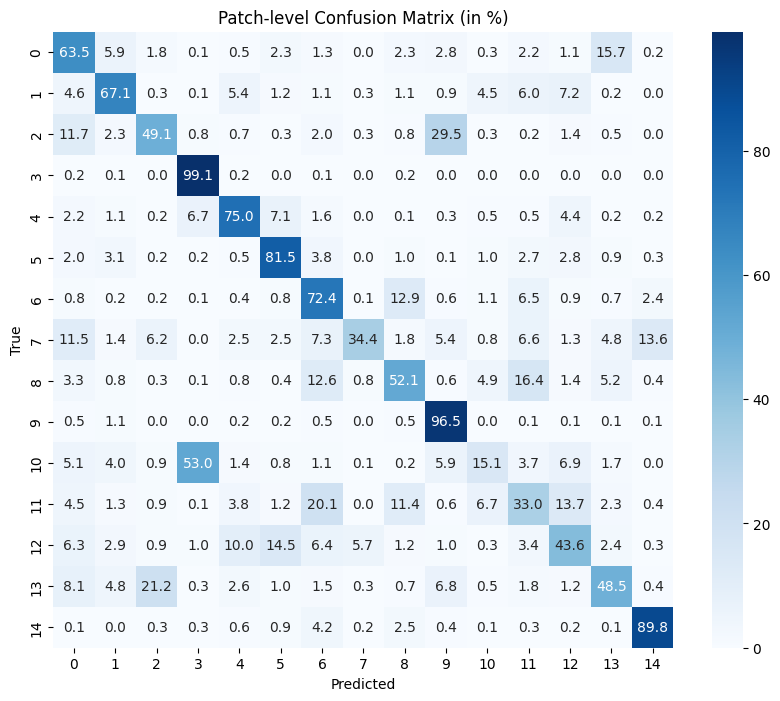

Slide-level Accuracy: 0.7647

Slide-level Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.80      0.89         5
           2       0.75      0.60      0.67         5
           3       0.83      1.00      0.91         5
           4       0.83      1.00      0.91         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       1.00      0.40      0.57         5
           8       1.00      0.80      0.89         5
           9       0.62      1.00      0.77         5
          10       0.50      0.33      0.40         3
          11       0.33      0.33      0.33         3
          12       0.75      0.60      0.67         5
          13       0.50      0.67      0.57         3
          14       0.80      1.00      0.89         4

    accuracy                           0.76        68
   macro avg  

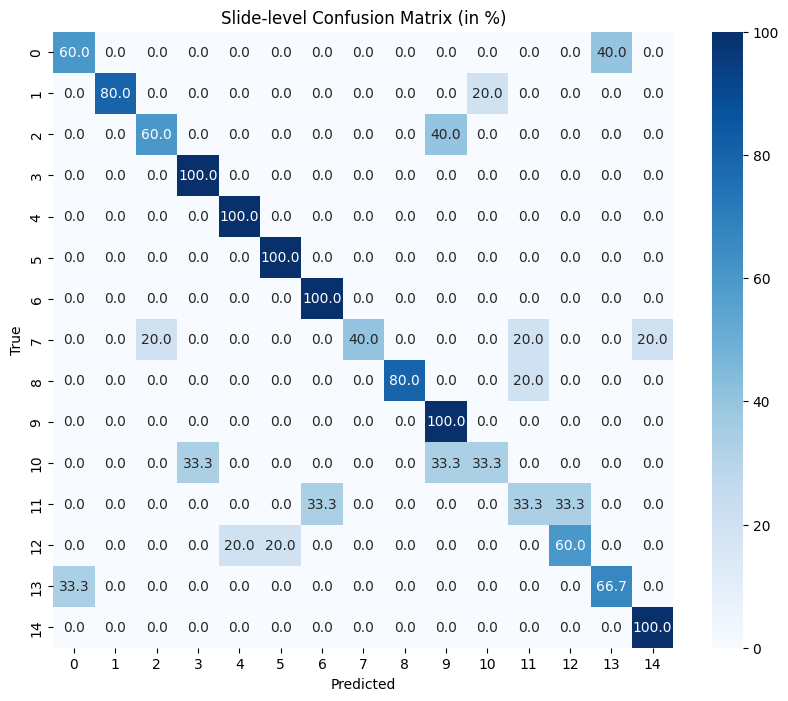

In [21]:
# test_loss /= len(test_loader.dataset)
# test_acc = test_corrects.double() / len(test_loader.dataset)

# print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()

# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(num_classes)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()


In [22]:
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(remaining_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



Evaluating:   0%|          | 1/656 [00:29<5:19:12, 29.24s/batch]

Batch Loss: 0.6989, Batch Accuracy: 0.7734


Evaluating:   0%|          | 2/656 [00:54<4:50:21, 26.64s/batch]

Batch Loss: 0.7266, Batch Accuracy: 0.7578


Evaluating:   0%|          | 3/656 [01:16<4:31:23, 24.94s/batch]

Batch Loss: 1.9512, Batch Accuracy: 0.5651


Evaluating:   1%|          | 4/656 [01:38<4:17:33, 23.70s/batch]

Batch Loss: 1.8090, Batch Accuracy: 0.5723


Evaluating:   1%|          | 5/656 [01:59<4:06:26, 22.71s/batch]

Batch Loss: 1.6703, Batch Accuracy: 0.5766


Evaluating:   1%|          | 6/656 [02:20<3:59:18, 22.09s/batch]

Batch Loss: 1.8025, Batch Accuracy: 0.5495


Evaluating:   1%|          | 7/656 [02:41<3:54:16, 21.66s/batch]

Batch Loss: 2.3760, Batch Accuracy: 0.4922


Evaluating:   1%|          | 8/656 [03:01<3:49:32, 21.25s/batch]

Batch Loss: 2.4861, Batch Accuracy: 0.4707


Evaluating:   1%|▏         | 9/656 [03:22<3:46:55, 21.04s/batch]

Batch Loss: 2.3237, Batch Accuracy: 0.5139


Evaluating:   2%|▏         | 10/656 [03:43<3:46:05, 21.00s/batch]

Batch Loss: 2.4836, Batch Accuracy: 0.4953


Evaluating:   2%|▏         | 11/656 [04:04<3:46:15, 21.05s/batch]

Batch Loss: 2.4698, Batch Accuracy: 0.4872


Evaluating:   2%|▏         | 12/656 [04:24<3:43:05, 20.78s/batch]

Batch Loss: 2.2900, Batch Accuracy: 0.5254


Evaluating:   2%|▏         | 13/656 [04:44<3:41:10, 20.64s/batch]

Batch Loss: 2.1346, Batch Accuracy: 0.5571


Evaluating:   2%|▏         | 14/656 [05:05<3:40:44, 20.63s/batch]

Batch Loss: 2.2915, Batch Accuracy: 0.5413


Evaluating:   2%|▏         | 15/656 [05:26<3:40:56, 20.68s/batch]

Batch Loss: 2.3626, Batch Accuracy: 0.5255


Evaluating:   2%|▏         | 16/656 [05:46<3:38:59, 20.53s/batch]

Batch Loss: 2.2348, Batch Accuracy: 0.5488


Evaluating:   3%|▎         | 17/656 [06:06<3:36:55, 20.37s/batch]

Batch Loss: 2.1886, Batch Accuracy: 0.5519


Evaluating:   3%|▎         | 18/656 [06:26<3:35:59, 20.31s/batch]

Batch Loss: 2.1600, Batch Accuracy: 0.5538


Evaluating:   3%|▎         | 19/656 [06:47<3:35:44, 20.32s/batch]

Batch Loss: 2.2726, Batch Accuracy: 0.5378


Evaluating:   3%|▎         | 20/656 [07:07<3:34:33, 20.24s/batch]

Batch Loss: 2.2617, Batch Accuracy: 0.5367


Evaluating:   3%|▎         | 21/656 [07:27<3:33:17, 20.15s/batch]

Batch Loss: 2.2549, Batch Accuracy: 0.5391


Evaluating:   3%|▎         | 22/656 [07:47<3:32:48, 20.14s/batch]

Batch Loss: 2.1933, Batch Accuracy: 0.5504


Evaluating:   4%|▎         | 23/656 [08:06<3:30:49, 19.98s/batch]

Batch Loss: 2.2331, Batch Accuracy: 0.5472


Evaluating:   4%|▎         | 24/656 [08:26<3:31:15, 20.06s/batch]

Batch Loss: 2.1838, Batch Accuracy: 0.5547


Evaluating:   4%|▍         | 25/656 [08:47<3:33:13, 20.27s/batch]

Batch Loss: 2.1375, Batch Accuracy: 0.5584


Evaluating:   4%|▍         | 26/656 [09:07<3:31:53, 20.18s/batch]

Batch Loss: 2.1604, Batch Accuracy: 0.5571


Evaluating:   4%|▍         | 27/656 [09:27<3:30:24, 20.07s/batch]

Batch Loss: 2.2141, Batch Accuracy: 0.5550


Evaluating:   4%|▍         | 28/656 [09:47<3:30:38, 20.12s/batch]

Batch Loss: 2.1726, Batch Accuracy: 0.5600


Evaluating:   4%|▍         | 29/656 [10:07<3:30:29, 20.14s/batch]

Batch Loss: 2.1586, Batch Accuracy: 0.5622


Evaluating:   5%|▍         | 30/656 [10:27<3:29:29, 20.08s/batch]

Batch Loss: 2.2598, Batch Accuracy: 0.5555


Evaluating:   5%|▍         | 31/656 [10:48<3:31:24, 20.29s/batch]

Batch Loss: 2.3793, Batch Accuracy: 0.5489


Evaluating:   5%|▍         | 32/656 [11:09<3:32:57, 20.48s/batch]

Batch Loss: 2.3235, Batch Accuracy: 0.5574


Evaluating:   5%|▌         | 33/656 [11:31<3:36:17, 20.83s/batch]

Batch Loss: 2.4089, Batch Accuracy: 0.5490


Evaluating:   5%|▌         | 34/656 [11:50<3:32:35, 20.51s/batch]

Batch Loss: 2.3803, Batch Accuracy: 0.5528


Evaluating:   5%|▌         | 35/656 [12:11<3:33:08, 20.59s/batch]

Batch Loss: 2.3770, Batch Accuracy: 0.5525


Evaluating:   5%|▌         | 36/656 [12:33<3:34:43, 20.78s/batch]

Batch Loss: 2.3242, Batch Accuracy: 0.5612


Evaluating:   6%|▌         | 37/656 [12:53<3:34:05, 20.75s/batch]

Batch Loss: 2.3459, Batch Accuracy: 0.5551


Evaluating:   6%|▌         | 38/656 [13:14<3:34:43, 20.85s/batch]

Batch Loss: 2.3357, Batch Accuracy: 0.5561


Evaluating:   6%|▌         | 39/656 [13:35<3:35:31, 20.96s/batch]

Batch Loss: 2.3208, Batch Accuracy: 0.5587


Evaluating:   6%|▌         | 40/656 [13:56<3:32:56, 20.74s/batch]

Batch Loss: 2.3447, Batch Accuracy: 0.5512


Evaluating:   6%|▋         | 41/656 [14:15<3:29:21, 20.43s/batch]

Batch Loss: 2.3210, Batch Accuracy: 0.5549


Evaluating:   6%|▋         | 42/656 [14:37<3:31:33, 20.67s/batch]

Batch Loss: 2.3109, Batch Accuracy: 0.5571


Evaluating:   7%|▋         | 43/656 [14:57<3:30:13, 20.58s/batch]

Batch Loss: 2.2818, Batch Accuracy: 0.5603


Evaluating:   7%|▋         | 44/656 [15:17<3:29:15, 20.52s/batch]

Batch Loss: 2.2674, Batch Accuracy: 0.5630


Evaluating:   7%|▋         | 45/656 [15:38<3:28:50, 20.51s/batch]

Batch Loss: 2.2515, Batch Accuracy: 0.5656


Evaluating:   7%|▋         | 46/656 [15:58<3:26:09, 20.28s/batch]

Batch Loss: 2.2253, Batch Accuracy: 0.5700


Evaluating:   7%|▋         | 47/656 [16:18<3:25:00, 20.20s/batch]

Batch Loss: 2.1834, Batch Accuracy: 0.5775


Evaluating:   7%|▋         | 48/656 [16:37<3:23:26, 20.08s/batch]

Batch Loss: 2.1564, Batch Accuracy: 0.5809


Evaluating:   7%|▋         | 49/656 [16:57<3:22:04, 19.97s/batch]

Batch Loss: 2.1449, Batch Accuracy: 0.5820


Evaluating:   8%|▊         | 50/656 [17:18<3:24:32, 20.25s/batch]

Batch Loss: 2.1910, Batch Accuracy: 0.5742


Evaluating:   8%|▊         | 51/656 [17:39<3:26:47, 20.51s/batch]

Batch Loss: 2.1680, Batch Accuracy: 0.5763


Evaluating:   8%|▊         | 52/656 [17:59<3:25:21, 20.40s/batch]

Batch Loss: 2.1736, Batch Accuracy: 0.5715


Evaluating:   8%|▊         | 53/656 [18:19<3:22:11, 20.12s/batch]

Batch Loss: 2.1692, Batch Accuracy: 0.5715


Evaluating:   8%|▊         | 54/656 [18:40<3:24:36, 20.39s/batch]

Batch Loss: 2.1373, Batch Accuracy: 0.5764


Evaluating:   8%|▊         | 55/656 [19:01<3:26:43, 20.64s/batch]

Batch Loss: 2.1114, Batch Accuracy: 0.5801


Evaluating:   9%|▊         | 56/656 [19:21<3:25:49, 20.58s/batch]

Batch Loss: 2.0849, Batch Accuracy: 0.5852


Evaluating:   9%|▊         | 57/656 [19:42<3:24:48, 20.51s/batch]

Batch Loss: 2.0572, Batch Accuracy: 0.5899


Evaluating:   9%|▉         | 58/656 [20:01<3:20:31, 20.12s/batch]

Batch Loss: 2.0412, Batch Accuracy: 0.5915


Evaluating:   9%|▉         | 59/656 [20:21<3:20:00, 20.10s/batch]

Batch Loss: 2.0676, Batch Accuracy: 0.5850


Evaluating:   9%|▉         | 60/656 [20:42<3:22:05, 20.34s/batch]

Batch Loss: 2.1109, Batch Accuracy: 0.5828


Evaluating:   9%|▉         | 61/656 [21:01<3:18:32, 20.02s/batch]

Batch Loss: 2.1231, Batch Accuracy: 0.5807


Evaluating:   9%|▉         | 62/656 [21:22<3:19:24, 20.14s/batch]

Batch Loss: 2.0944, Batch Accuracy: 0.5858


Evaluating:  10%|▉         | 63/656 [21:43<3:21:11, 20.36s/batch]

Batch Loss: 2.1187, Batch Accuracy: 0.5842


Evaluating:  10%|▉         | 64/656 [22:02<3:19:06, 20.18s/batch]

Batch Loss: 2.1290, Batch Accuracy: 0.5831


Evaluating:  10%|▉         | 65/656 [22:23<3:19:40, 20.27s/batch]

Batch Loss: 2.2020, Batch Accuracy: 0.5760


Evaluating:  10%|█         | 66/656 [22:44<3:21:52, 20.53s/batch]

Batch Loss: 2.2292, Batch Accuracy: 0.5709


Evaluating:  10%|█         | 67/656 [23:03<3:16:46, 20.05s/batch]

Batch Loss: 2.2412, Batch Accuracy: 0.5698


Evaluating:  10%|█         | 68/656 [23:24<3:19:18, 20.34s/batch]

Batch Loss: 2.3232, Batch Accuracy: 0.5632


Evaluating:  11%|█         | 69/656 [23:45<3:20:03, 20.45s/batch]

Batch Loss: 2.3037, Batch Accuracy: 0.5662


Evaluating:  11%|█         | 70/656 [24:06<3:21:12, 20.60s/batch]

Batch Loss: 2.2806, Batch Accuracy: 0.5705


Evaluating:  11%|█         | 71/656 [24:27<3:22:21, 20.75s/batch]

Batch Loss: 2.2636, Batch Accuracy: 0.5731


Evaluating:  11%|█         | 72/656 [24:47<3:19:47, 20.53s/batch]

Batch Loss: 2.2409, Batch Accuracy: 0.5767


Evaluating:  11%|█         | 73/656 [25:07<3:19:28, 20.53s/batch]

Batch Loss: 2.2248, Batch Accuracy: 0.5787


Evaluating:  11%|█▏        | 74/656 [25:29<3:23:12, 20.95s/batch]

Batch Loss: 2.2351, Batch Accuracy: 0.5769


Evaluating:  11%|█▏        | 75/656 [25:50<3:21:38, 20.82s/batch]

Batch Loss: 2.2199, Batch Accuracy: 0.5794


Evaluating:  12%|█▏        | 76/656 [26:10<3:19:26, 20.63s/batch]

Batch Loss: 2.2229, Batch Accuracy: 0.5780


Evaluating:  12%|█▏        | 77/656 [26:31<3:19:41, 20.69s/batch]

Batch Loss: 2.2518, Batch Accuracy: 0.5745


Evaluating:  12%|█▏        | 78/656 [26:50<3:16:17, 20.38s/batch]

Batch Loss: 2.2348, Batch Accuracy: 0.5769


Evaluating:  12%|█▏        | 79/656 [27:11<3:16:59, 20.48s/batch]

Batch Loss: 2.2279, Batch Accuracy: 0.5769


Evaluating:  12%|█▏        | 80/656 [27:32<3:18:28, 20.67s/batch]

Batch Loss: 2.2468, Batch Accuracy: 0.5721


Evaluating:  12%|█▏        | 81/656 [27:52<3:16:14, 20.48s/batch]

Batch Loss: 2.2417, Batch Accuracy: 0.5711


Evaluating:  12%|█▎        | 82/656 [28:12<3:13:22, 20.21s/batch]

Batch Loss: 2.2239, Batch Accuracy: 0.5740


Evaluating:  13%|█▎        | 83/656 [28:32<3:14:32, 20.37s/batch]

Batch Loss: 2.2066, Batch Accuracy: 0.5761


Evaluating:  13%|█▎        | 84/656 [28:52<3:11:06, 20.05s/batch]

Batch Loss: 2.1885, Batch Accuracy: 0.5784


Evaluating:  13%|█▎        | 85/656 [29:12<3:11:05, 20.08s/batch]

Batch Loss: 2.2124, Batch Accuracy: 0.5759


Evaluating:  13%|█▎        | 86/656 [29:33<3:13:51, 20.41s/batch]

Batch Loss: 2.2320, Batch Accuracy: 0.5729


Evaluating:  13%|█▎        | 87/656 [29:54<3:13:34, 20.41s/batch]

Batch Loss: 2.2140, Batch Accuracy: 0.5758


Evaluating:  13%|█▎        | 88/656 [30:14<3:12:38, 20.35s/batch]

Batch Loss: 2.2276, Batch Accuracy: 0.5740


Evaluating:  14%|█▎        | 89/656 [30:35<3:14:04, 20.54s/batch]

Batch Loss: 2.2275, Batch Accuracy: 0.5745


Evaluating:  14%|█▎        | 90/656 [30:55<3:12:16, 20.38s/batch]

Batch Loss: 2.2090, Batch Accuracy: 0.5780


Evaluating:  14%|█▍        | 91/656 [31:15<3:10:23, 20.22s/batch]

Batch Loss: 2.1959, Batch Accuracy: 0.5792


Evaluating:  14%|█▍        | 92/656 [31:36<3:12:29, 20.48s/batch]

Batch Loss: 2.1771, Batch Accuracy: 0.5831


Evaluating:  14%|█▍        | 93/656 [31:54<3:06:54, 19.92s/batch]

Batch Loss: 2.1829, Batch Accuracy: 0.5805


Evaluating:  14%|█▍        | 94/656 [32:14<3:07:06, 19.98s/batch]

Batch Loss: 2.1738, Batch Accuracy: 0.5813


Evaluating:  14%|█▍        | 95/656 [32:34<3:06:33, 19.95s/batch]

Batch Loss: 2.1801, Batch Accuracy: 0.5789


Evaluating:  15%|█▍        | 96/656 [32:54<3:05:13, 19.84s/batch]

Batch Loss: 2.1736, Batch Accuracy: 0.5801


Evaluating:  15%|█▍        | 97/656 [33:13<3:02:59, 19.64s/batch]

Batch Loss: 2.1590, Batch Accuracy: 0.5823


Evaluating:  15%|█▍        | 98/656 [33:34<3:07:11, 20.13s/batch]

Batch Loss: 2.1584, Batch Accuracy: 0.5801


Evaluating:  15%|█▌        | 99/656 [33:54<3:06:34, 20.10s/batch]

Batch Loss: 2.1775, Batch Accuracy: 0.5776


Evaluating:  15%|█▌        | 100/656 [34:13<3:03:30, 19.80s/batch]

Batch Loss: 2.1871, Batch Accuracy: 0.5741


Evaluating:  15%|█▌        | 101/656 [34:35<3:06:48, 20.19s/batch]

Batch Loss: 2.1767, Batch Accuracy: 0.5762


Evaluating:  16%|█▌        | 102/656 [34:55<3:05:54, 20.13s/batch]

Batch Loss: 2.1710, Batch Accuracy: 0.5758


Evaluating:  16%|█▌        | 103/656 [35:14<3:03:43, 19.93s/batch]

Batch Loss: 2.1694, Batch Accuracy: 0.5755


Evaluating:  16%|█▌        | 104/656 [35:35<3:06:36, 20.28s/batch]

Batch Loss: 2.1711, Batch Accuracy: 0.5735


Evaluating:  16%|█▌        | 105/656 [35:54<3:02:54, 19.92s/batch]

Batch Loss: 2.1685, Batch Accuracy: 0.5734


Evaluating:  16%|█▌        | 106/656 [36:15<3:03:46, 20.05s/batch]

Batch Loss: 2.1813, Batch Accuracy: 0.5700


Evaluating:  16%|█▋        | 107/656 [36:36<3:06:04, 20.34s/batch]

Batch Loss: 2.1742, Batch Accuracy: 0.5700


Evaluating:  16%|█▋        | 108/656 [36:56<3:05:27, 20.31s/batch]

Batch Loss: 2.1699, Batch Accuracy: 0.5707


Evaluating:  17%|█▋        | 109/656 [37:16<3:04:06, 20.19s/batch]

Batch Loss: 2.1635, Batch Accuracy: 0.5707


Evaluating:  17%|█▋        | 110/656 [37:37<3:07:26, 20.60s/batch]

Batch Loss: 2.2027, Batch Accuracy: 0.5692


Evaluating:  17%|█▋        | 111/656 [37:56<3:03:15, 20.18s/batch]

Batch Loss: 2.2221, Batch Accuracy: 0.5664


Evaluating:  17%|█▋        | 112/656 [38:16<3:01:19, 20.00s/batch]

Batch Loss: 2.2354, Batch Accuracy: 0.5638


Evaluating:  17%|█▋        | 113/656 [38:37<3:02:52, 20.21s/batch]

Batch Loss: 2.2548, Batch Accuracy: 0.5604


Evaluating:  17%|█▋        | 114/656 [38:57<3:02:39, 20.22s/batch]

Batch Loss: 2.2482, Batch Accuracy: 0.5615


Evaluating:  18%|█▊        | 115/656 [39:17<3:00:47, 20.05s/batch]

Batch Loss: 2.2732, Batch Accuracy: 0.5586


Evaluating:  18%|█▊        | 116/656 [39:38<3:03:01, 20.34s/batch]

Batch Loss: 2.2598, Batch Accuracy: 0.5608


Evaluating:  18%|█▊        | 117/656 [39:58<3:02:11, 20.28s/batch]

Batch Loss: 2.2495, Batch Accuracy: 0.5621


Evaluating:  18%|█▊        | 118/656 [40:18<3:02:07, 20.31s/batch]

Batch Loss: 2.2435, Batch Accuracy: 0.5632


Evaluating:  18%|█▊        | 119/656 [40:38<3:00:51, 20.21s/batch]

Batch Loss: 2.2431, Batch Accuracy: 0.5616


Evaluating:  18%|█▊        | 120/656 [40:58<3:00:12, 20.17s/batch]

Batch Loss: 2.2948, Batch Accuracy: 0.5598


Evaluating:  18%|█▊        | 121/656 [41:18<2:59:23, 20.12s/batch]

Batch Loss: 2.3174, Batch Accuracy: 0.5606


Evaluating:  19%|█▊        | 122/656 [41:39<3:00:48, 20.32s/batch]

Batch Loss: 2.3106, Batch Accuracy: 0.5605


Evaluating:  19%|█▉        | 123/656 [41:59<3:00:23, 20.31s/batch]

Batch Loss: 2.3223, Batch Accuracy: 0.5568


Evaluating:  19%|█▉        | 124/656 [42:19<2:58:05, 20.09s/batch]

Batch Loss: 2.3197, Batch Accuracy: 0.5565


Evaluating:  19%|█▉        | 125/656 [42:40<3:01:16, 20.48s/batch]

Batch Loss: 2.3077, Batch Accuracy: 0.5587


Evaluating:  19%|█▉        | 126/656 [43:00<2:59:07, 20.28s/batch]

Batch Loss: 2.3111, Batch Accuracy: 0.5593


Evaluating:  19%|█▉        | 127/656 [43:20<2:57:48, 20.17s/batch]

Batch Loss: 2.3342, Batch Accuracy: 0.5567


Evaluating:  20%|█▉        | 128/656 [43:41<2:59:26, 20.39s/batch]

Batch Loss: 2.3319, Batch Accuracy: 0.5565


Evaluating:  20%|█▉        | 129/656 [44:00<2:54:51, 19.91s/batch]

Batch Loss: 2.3451, Batch Accuracy: 0.5547


Evaluating:  20%|█▉        | 130/656 [44:20<2:54:38, 19.92s/batch]

Batch Loss: 2.3433, Batch Accuracy: 0.5534


Evaluating:  20%|█▉        | 131/656 [44:40<2:54:52, 19.99s/batch]

Batch Loss: 2.3434, Batch Accuracy: 0.5523


Evaluating:  20%|██        | 132/656 [44:59<2:53:23, 19.85s/batch]

Batch Loss: 2.3354, Batch Accuracy: 0.5529


Evaluating:  20%|██        | 133/656 [45:19<2:52:16, 19.76s/batch]

Batch Loss: 2.3394, Batch Accuracy: 0.5512


Evaluating:  20%|██        | 134/656 [45:39<2:53:59, 20.00s/batch]

Batch Loss: 2.3342, Batch Accuracy: 0.5517


Evaluating:  21%|██        | 135/656 [45:59<2:52:37, 19.88s/batch]

Batch Loss: 2.3263, Batch Accuracy: 0.5530


Evaluating:  21%|██        | 136/656 [46:19<2:51:38, 19.81s/batch]

Batch Loss: 2.3115, Batch Accuracy: 0.5558


Evaluating:  21%|██        | 137/656 [46:38<2:50:11, 19.67s/batch]

Batch Loss: 2.3005, Batch Accuracy: 0.5577


Evaluating:  21%|██        | 138/656 [46:59<2:53:39, 20.11s/batch]

Batch Loss: 2.3211, Batch Accuracy: 0.5567


Evaluating:  21%|██        | 139/656 [47:18<2:51:16, 19.88s/batch]

Batch Loss: 2.3267, Batch Accuracy: 0.5563


Evaluating:  21%|██▏       | 140/656 [47:39<2:53:01, 20.12s/batch]

Batch Loss: 2.3365, Batch Accuracy: 0.5548


Evaluating:  21%|██▏       | 141/656 [47:59<2:53:03, 20.16s/batch]

Batch Loss: 2.3388, Batch Accuracy: 0.5555


Evaluating:  22%|██▏       | 142/656 [48:19<2:51:18, 20.00s/batch]

Batch Loss: 2.3396, Batch Accuracy: 0.5549


Evaluating:  22%|██▏       | 143/656 [48:39<2:52:08, 20.13s/batch]

Batch Loss: 2.3315, Batch Accuracy: 0.5558


Evaluating:  22%|██▏       | 144/656 [49:00<2:53:08, 20.29s/batch]

Batch Loss: 2.3295, Batch Accuracy: 0.5553


Evaluating:  22%|██▏       | 145/656 [49:19<2:49:52, 19.95s/batch]

Batch Loss: 2.3238, Batch Accuracy: 0.5549


Evaluating:  22%|██▏       | 146/656 [49:40<2:51:36, 20.19s/batch]

Batch Loss: 2.3168, Batch Accuracy: 0.5553


Evaluating:  22%|██▏       | 147/656 [50:00<2:49:52, 20.02s/batch]

Batch Loss: 2.3367, Batch Accuracy: 0.5523


Evaluating:  23%|██▎       | 148/656 [50:20<2:49:20, 20.00s/batch]

Batch Loss: 2.3419, Batch Accuracy: 0.5509


Evaluating:  23%|██▎       | 149/656 [50:40<2:49:42, 20.08s/batch]

Batch Loss: 2.3532, Batch Accuracy: 0.5491


Evaluating:  23%|██▎       | 150/656 [51:00<2:49:44, 20.13s/batch]

Batch Loss: 2.3441, Batch Accuracy: 0.5507


Evaluating:  23%|██▎       | 151/656 [51:20<2:48:07, 19.97s/batch]

Batch Loss: 2.3342, Batch Accuracy: 0.5520


Evaluating:  23%|██▎       | 152/656 [51:41<2:49:56, 20.23s/batch]

Batch Loss: 2.3265, Batch Accuracy: 0.5528


Evaluating:  23%|██▎       | 153/656 [52:01<2:49:19, 20.20s/batch]

Batch Loss: 2.3161, Batch Accuracy: 0.5542


Evaluating:  23%|██▎       | 154/656 [52:21<2:50:01, 20.32s/batch]

Batch Loss: 2.3097, Batch Accuracy: 0.5557


Evaluating:  24%|██▎       | 155/656 [52:42<2:50:46, 20.45s/batch]

Batch Loss: 2.3320, Batch Accuracy: 0.5531


Evaluating:  24%|██▍       | 156/656 [53:02<2:49:06, 20.29s/batch]

Batch Loss: 2.3234, Batch Accuracy: 0.5539


Evaluating:  24%|██▍       | 157/656 [53:22<2:49:11, 20.34s/batch]

Batch Loss: 2.3158, Batch Accuracy: 0.5548


Evaluating:  24%|██▍       | 158/656 [53:43<2:49:39, 20.44s/batch]

Batch Loss: 2.3056, Batch Accuracy: 0.5563


Evaluating:  24%|██▍       | 159/656 [54:04<2:49:15, 20.43s/batch]

Batch Loss: 2.2946, Batch Accuracy: 0.5585


Evaluating:  24%|██▍       | 160/656 [54:24<2:48:13, 20.35s/batch]

Batch Loss: 2.2877, Batch Accuracy: 0.5591


Evaluating:  25%|██▍       | 161/656 [54:43<2:45:37, 20.08s/batch]

Batch Loss: 2.2802, Batch Accuracy: 0.5596


Evaluating:  25%|██▍       | 162/656 [55:03<2:45:35, 20.11s/batch]

Batch Loss: 2.2860, Batch Accuracy: 0.5579


Evaluating:  25%|██▍       | 163/656 [55:23<2:44:06, 19.97s/batch]

Batch Loss: 2.2773, Batch Accuracy: 0.5593


Evaluating:  25%|██▌       | 164/656 [55:42<2:42:34, 19.83s/batch]

Batch Loss: 2.2702, Batch Accuracy: 0.5604


Evaluating:  25%|██▌       | 165/656 [56:02<2:42:38, 19.87s/batch]

Batch Loss: 2.2652, Batch Accuracy: 0.5616


Evaluating:  25%|██▌       | 166/656 [56:22<2:41:27, 19.77s/batch]

Batch Loss: 2.2663, Batch Accuracy: 0.5610


Evaluating:  25%|██▌       | 167/656 [56:43<2:43:13, 20.03s/batch]

Batch Loss: 2.2662, Batch Accuracy: 0.5605


Evaluating:  26%|██▌       | 168/656 [57:03<2:42:38, 20.00s/batch]

Batch Loss: 2.2555, Batch Accuracy: 0.5623


Evaluating:  26%|██▌       | 169/656 [57:22<2:41:31, 19.90s/batch]

Batch Loss: 2.2520, Batch Accuracy: 0.5624


Evaluating:  26%|██▌       | 170/656 [57:42<2:41:20, 19.92s/batch]

Batch Loss: 2.2426, Batch Accuracy: 0.5637


Evaluating:  26%|██▌       | 171/656 [58:03<2:43:24, 20.21s/batch]

Batch Loss: 2.2359, Batch Accuracy: 0.5646


Evaluating:  26%|██▌       | 172/656 [58:23<2:42:49, 20.18s/batch]

Batch Loss: 2.2315, Batch Accuracy: 0.5645


Evaluating:  26%|██▋       | 173/656 [58:44<2:43:46, 20.35s/batch]

Batch Loss: 2.2343, Batch Accuracy: 0.5649


Evaluating:  27%|██▋       | 174/656 [59:04<2:42:15, 20.20s/batch]

Batch Loss: 2.2662, Batch Accuracy: 0.5622


Evaluating:  27%|██▋       | 175/656 [59:24<2:41:39, 20.17s/batch]

Batch Loss: 2.2661, Batch Accuracy: 0.5627


Evaluating:  27%|██▋       | 176/656 [59:44<2:42:03, 20.26s/batch]

Batch Loss: 2.2854, Batch Accuracy: 0.5605


Evaluating:  27%|██▋       | 177/656 [1:00:04<2:39:36, 19.99s/batch]

Batch Loss: 2.2926, Batch Accuracy: 0.5590


Evaluating:  27%|██▋       | 178/656 [1:00:24<2:40:27, 20.14s/batch]

Batch Loss: 2.2985, Batch Accuracy: 0.5576


Evaluating:  27%|██▋       | 179/656 [1:00:45<2:41:34, 20.32s/batch]

Batch Loss: 2.2902, Batch Accuracy: 0.5591


Evaluating:  27%|██▋       | 180/656 [1:01:05<2:41:04, 20.30s/batch]

Batch Loss: 2.2826, Batch Accuracy: 0.5606


Evaluating:  28%|██▊       | 181/656 [1:01:25<2:40:27, 20.27s/batch]

Batch Loss: 2.2761, Batch Accuracy: 0.5617


Evaluating:  28%|██▊       | 182/656 [1:01:45<2:39:37, 20.20s/batch]

Batch Loss: 2.2659, Batch Accuracy: 0.5635


Evaluating:  28%|██▊       | 183/656 [1:02:05<2:37:55, 20.03s/batch]

Batch Loss: 2.2560, Batch Accuracy: 0.5652


Evaluating:  28%|██▊       | 184/656 [1:02:26<2:38:37, 20.17s/batch]

Batch Loss: 2.2482, Batch Accuracy: 0.5659


Evaluating:  28%|██▊       | 185/656 [1:02:45<2:37:14, 20.03s/batch]

Batch Loss: 2.2455, Batch Accuracy: 0.5651


Evaluating:  28%|██▊       | 186/656 [1:03:05<2:36:15, 19.95s/batch]

Batch Loss: 2.2710, Batch Accuracy: 0.5628


Evaluating:  29%|██▊       | 187/656 [1:03:24<2:33:41, 19.66s/batch]

Batch Loss: 2.3089, Batch Accuracy: 0.5602


Evaluating:  29%|██▊       | 188/656 [1:03:44<2:35:16, 19.91s/batch]

Batch Loss: 2.3081, Batch Accuracy: 0.5598


Evaluating:  29%|██▉       | 189/656 [1:04:04<2:34:50, 19.89s/batch]

Batch Loss: 2.3022, Batch Accuracy: 0.5604


Evaluating:  29%|██▉       | 190/656 [1:04:24<2:34:52, 19.94s/batch]

Batch Loss: 2.2932, Batch Accuracy: 0.5615


Evaluating:  29%|██▉       | 191/656 [1:04:44<2:34:12, 19.90s/batch]

Batch Loss: 2.2889, Batch Accuracy: 0.5618


Evaluating:  29%|██▉       | 192/656 [1:05:04<2:34:46, 20.01s/batch]

Batch Loss: 2.3259, Batch Accuracy: 0.5600


Evaluating:  29%|██▉       | 193/656 [1:05:24<2:34:22, 20.01s/batch]

Batch Loss: 2.3323, Batch Accuracy: 0.5610


Evaluating:  30%|██▉       | 194/656 [1:05:45<2:35:28, 20.19s/batch]

Batch Loss: 2.3416, Batch Accuracy: 0.5594


Evaluating:  30%|██▉       | 195/656 [1:06:04<2:33:16, 19.95s/batch]

Batch Loss: 2.3402, Batch Accuracy: 0.5585


Evaluating:  30%|██▉       | 196/656 [1:06:24<2:32:14, 19.86s/batch]

Batch Loss: 2.3378, Batch Accuracy: 0.5582


Evaluating:  30%|███       | 197/656 [1:06:45<2:33:46, 20.10s/batch]

Batch Loss: 2.3483, Batch Accuracy: 0.5560


Evaluating:  30%|███       | 198/656 [1:07:05<2:32:49, 20.02s/batch]

Batch Loss: 2.3458, Batch Accuracy: 0.5558


Evaluating:  30%|███       | 199/656 [1:07:24<2:31:44, 19.92s/batch]

Batch Loss: 2.3494, Batch Accuracy: 0.5545


Evaluating:  30%|███       | 200/656 [1:07:45<2:33:08, 20.15s/batch]

Batch Loss: 2.3531, Batch Accuracy: 0.5530


Evaluating:  31%|███       | 201/656 [1:08:05<2:31:37, 19.99s/batch]

Batch Loss: 2.3462, Batch Accuracy: 0.5538


Evaluating:  31%|███       | 202/656 [1:08:25<2:32:28, 20.15s/batch]

Batch Loss: 2.3455, Batch Accuracy: 0.5530


Evaluating:  31%|███       | 203/656 [1:08:45<2:30:32, 19.94s/batch]

Batch Loss: 2.3486, Batch Accuracy: 0.5521


Evaluating:  31%|███       | 204/656 [1:09:04<2:28:36, 19.73s/batch]

Batch Loss: 2.3473, Batch Accuracy: 0.5517


Evaluating:  31%|███▏      | 205/656 [1:09:24<2:29:29, 19.89s/batch]

Batch Loss: 2.3384, Batch Accuracy: 0.5529


Evaluating:  31%|███▏      | 206/656 [1:09:43<2:27:56, 19.73s/batch]

Batch Loss: 2.3362, Batch Accuracy: 0.5527


Evaluating:  32%|███▏      | 207/656 [1:10:03<2:28:13, 19.81s/batch]

Batch Loss: 2.3385, Batch Accuracy: 0.5519


Evaluating:  32%|███▏      | 208/656 [1:10:23<2:28:28, 19.88s/batch]

Batch Loss: 2.3327, Batch Accuracy: 0.5528


Evaluating:  32%|███▏      | 209/656 [1:10:43<2:27:51, 19.85s/batch]

Batch Loss: 2.3276, Batch Accuracy: 0.5535


Evaluating:  32%|███▏      | 210/656 [1:11:03<2:27:56, 19.90s/batch]

Batch Loss: 2.3214, Batch Accuracy: 0.5548


Evaluating:  32%|███▏      | 211/656 [1:11:23<2:27:50, 19.93s/batch]

Batch Loss: 2.3131, Batch Accuracy: 0.5564


Evaluating:  32%|███▏      | 212/656 [1:11:43<2:26:58, 19.86s/batch]

Batch Loss: 2.3265, Batch Accuracy: 0.5550


Evaluating:  32%|███▏      | 213/656 [1:12:03<2:26:42, 19.87s/batch]

Batch Loss: 2.3225, Batch Accuracy: 0.5547


Evaluating:  33%|███▎      | 214/656 [1:12:22<2:25:25, 19.74s/batch]

Batch Loss: 2.3179, Batch Accuracy: 0.5552


Evaluating:  33%|███▎      | 215/656 [1:12:43<2:26:21, 19.91s/batch]

Batch Loss: 2.3133, Batch Accuracy: 0.5559


Evaluating:  33%|███▎      | 216/656 [1:13:04<2:29:18, 20.36s/batch]

Batch Loss: 2.3218, Batch Accuracy: 0.5553


Evaluating:  33%|███▎      | 217/656 [1:13:24<2:28:14, 20.26s/batch]

Batch Loss: 2.3123, Batch Accuracy: 0.5570


Evaluating:  33%|███▎      | 218/656 [1:13:44<2:27:48, 20.25s/batch]

Batch Loss: 2.3080, Batch Accuracy: 0.5577


Evaluating:  33%|███▎      | 219/656 [1:14:04<2:26:34, 20.12s/batch]

Batch Loss: 2.3095, Batch Accuracy: 0.5566


Evaluating:  34%|███▎      | 220/656 [1:14:24<2:25:46, 20.06s/batch]

Batch Loss: 2.3088, Batch Accuracy: 0.5564


Evaluating:  34%|███▎      | 221/656 [1:14:45<2:26:33, 20.21s/batch]

Batch Loss: 2.3038, Batch Accuracy: 0.5571


Evaluating:  34%|███▍      | 222/656 [1:15:04<2:25:34, 20.13s/batch]

Batch Loss: 2.2976, Batch Accuracy: 0.5577


Evaluating:  34%|███▍      | 223/656 [1:15:24<2:24:41, 20.05s/batch]

Batch Loss: 2.2956, Batch Accuracy: 0.5576


Evaluating:  34%|███▍      | 224/656 [1:15:44<2:23:58, 20.00s/batch]

Batch Loss: 2.2903, Batch Accuracy: 0.5583


Evaluating:  34%|███▍      | 225/656 [1:16:04<2:23:09, 19.93s/batch]

Batch Loss: 2.2859, Batch Accuracy: 0.5589


Evaluating:  34%|███▍      | 226/656 [1:16:24<2:23:09, 19.97s/batch]

Batch Loss: 2.2784, Batch Accuracy: 0.5601


Evaluating:  35%|███▍      | 227/656 [1:16:44<2:23:26, 20.06s/batch]

Batch Loss: 2.2763, Batch Accuracy: 0.5602


Evaluating:  35%|███▍      | 228/656 [1:17:04<2:23:09, 20.07s/batch]

Batch Loss: 2.2783, Batch Accuracy: 0.5589


Evaluating:  35%|███▍      | 229/656 [1:17:25<2:23:58, 20.23s/batch]

Batch Loss: 2.2720, Batch Accuracy: 0.5600


Evaluating:  35%|███▌      | 230/656 [1:17:45<2:23:19, 20.19s/batch]

Batch Loss: 2.2650, Batch Accuracy: 0.5612


Evaluating:  35%|███▌      | 231/656 [1:18:06<2:23:44, 20.29s/batch]

Batch Loss: 2.2590, Batch Accuracy: 0.5620


Evaluating:  35%|███▌      | 232/656 [1:18:26<2:23:24, 20.29s/batch]

Batch Loss: 2.2644, Batch Accuracy: 0.5610


Evaluating:  36%|███▌      | 233/656 [1:18:46<2:22:08, 20.16s/batch]

Batch Loss: 2.2644, Batch Accuracy: 0.5610


Evaluating:  36%|███▌      | 234/656 [1:19:06<2:22:19, 20.24s/batch]

Batch Loss: 2.2662, Batch Accuracy: 0.5605


Evaluating:  36%|███▌      | 235/656 [1:19:26<2:21:01, 20.10s/batch]

Batch Loss: 2.2573, Batch Accuracy: 0.5620


Evaluating:  36%|███▌      | 236/656 [1:19:46<2:20:18, 20.04s/batch]

Batch Loss: 2.2652, Batch Accuracy: 0.5606


Evaluating:  36%|███▌      | 237/656 [1:20:06<2:19:36, 19.99s/batch]

Batch Loss: 2.2615, Batch Accuracy: 0.5617


Evaluating:  36%|███▋      | 238/656 [1:20:26<2:19:32, 20.03s/batch]

Batch Loss: 2.2560, Batch Accuracy: 0.5628


Evaluating:  36%|███▋      | 239/656 [1:20:45<2:17:57, 19.85s/batch]

Batch Loss: 2.2547, Batch Accuracy: 0.5623


Evaluating:  37%|███▋      | 240/656 [1:21:06<2:19:52, 20.17s/batch]

Batch Loss: 2.2513, Batch Accuracy: 0.5623


Evaluating:  37%|███▋      | 241/656 [1:21:26<2:19:27, 20.16s/batch]

Batch Loss: 2.2464, Batch Accuracy: 0.5628


Evaluating:  37%|███▋      | 242/656 [1:21:46<2:18:25, 20.06s/batch]

Batch Loss: 2.2451, Batch Accuracy: 0.5630


Evaluating:  37%|███▋      | 243/656 [1:22:06<2:16:52, 19.88s/batch]

Batch Loss: 2.2407, Batch Accuracy: 0.5630


Evaluating:  37%|███▋      | 244/656 [1:22:25<2:14:40, 19.61s/batch]

Batch Loss: 2.2346, Batch Accuracy: 0.5637


Evaluating:  37%|███▋      | 245/656 [1:22:45<2:15:48, 19.83s/batch]

Batch Loss: 2.2306, Batch Accuracy: 0.5642


Evaluating:  38%|███▊      | 246/656 [1:23:05<2:15:00, 19.76s/batch]

Batch Loss: 2.2324, Batch Accuracy: 0.5642


Evaluating:  38%|███▊      | 247/656 [1:23:25<2:15:15, 19.84s/batch]

Batch Loss: 2.2372, Batch Accuracy: 0.5634


Evaluating:  38%|███▊      | 248/656 [1:23:45<2:15:49, 19.97s/batch]

Batch Loss: 2.2359, Batch Accuracy: 0.5634


Evaluating:  38%|███▊      | 249/656 [1:24:05<2:15:24, 19.96s/batch]

Batch Loss: 2.2381, Batch Accuracy: 0.5620


Evaluating:  38%|███▊      | 250/656 [1:24:25<2:15:15, 19.99s/batch]

Batch Loss: 2.2358, Batch Accuracy: 0.5620


Evaluating:  38%|███▊      | 251/656 [1:24:45<2:15:37, 20.09s/batch]

Batch Loss: 2.2341, Batch Accuracy: 0.5625


Evaluating:  38%|███▊      | 252/656 [1:25:05<2:14:23, 19.96s/batch]

Batch Loss: 2.2313, Batch Accuracy: 0.5632


Evaluating:  39%|███▊      | 253/656 [1:25:25<2:15:00, 20.10s/batch]

Batch Loss: 2.2274, Batch Accuracy: 0.5636


Evaluating:  39%|███▊      | 254/656 [1:25:46<2:15:01, 20.15s/batch]

Batch Loss: 2.2604, Batch Accuracy: 0.5621


Evaluating:  39%|███▉      | 255/656 [1:26:06<2:15:12, 20.23s/batch]

Batch Loss: 2.2525, Batch Accuracy: 0.5635


Evaluating:  39%|███▉      | 256/656 [1:26:26<2:14:42, 20.21s/batch]

Batch Loss: 2.2615, Batch Accuracy: 0.5629


Evaluating:  39%|███▉      | 257/656 [1:26:46<2:14:17, 20.19s/batch]

Batch Loss: 2.2663, Batch Accuracy: 0.5624


Evaluating:  39%|███▉      | 258/656 [1:27:07<2:14:39, 20.30s/batch]

Batch Loss: 2.2594, Batch Accuracy: 0.5637


Evaluating:  39%|███▉      | 259/656 [1:27:27<2:13:15, 20.14s/batch]

Batch Loss: 2.2537, Batch Accuracy: 0.5644


Evaluating:  40%|███▉      | 260/656 [1:27:48<2:14:36, 20.40s/batch]

Batch Loss: 2.2469, Batch Accuracy: 0.5654


Evaluating:  40%|███▉      | 261/656 [1:28:07<2:12:53, 20.19s/batch]

Batch Loss: 2.2484, Batch Accuracy: 0.5649


Evaluating:  40%|███▉      | 262/656 [1:28:28<2:13:00, 20.25s/batch]

Batch Loss: 2.2412, Batch Accuracy: 0.5662


Evaluating:  40%|████      | 263/656 [1:28:49<2:14:56, 20.60s/batch]

Batch Loss: 2.2384, Batch Accuracy: 0.5666


Evaluating:  40%|████      | 264/656 [1:29:09<2:13:43, 20.47s/batch]

Batch Loss: 2.2343, Batch Accuracy: 0.5673


Evaluating:  40%|████      | 265/656 [1:29:31<2:14:52, 20.70s/batch]

Batch Loss: 2.2301, Batch Accuracy: 0.5679


Evaluating:  41%|████      | 266/656 [1:29:51<2:14:19, 20.67s/batch]

Batch Loss: 2.2280, Batch Accuracy: 0.5678


Evaluating:  41%|████      | 267/656 [1:30:11<2:11:57, 20.35s/batch]

Batch Loss: 2.2269, Batch Accuracy: 0.5676


Evaluating:  41%|████      | 268/656 [1:30:32<2:13:41, 20.67s/batch]

Batch Loss: 2.2350, Batch Accuracy: 0.5664


Evaluating:  41%|████      | 269/656 [1:30:52<2:11:43, 20.42s/batch]

Batch Loss: 2.2332, Batch Accuracy: 0.5665


Evaluating:  41%|████      | 270/656 [1:31:12<2:10:51, 20.34s/batch]

Batch Loss: 2.2395, Batch Accuracy: 0.5656


Evaluating:  41%|████▏     | 271/656 [1:31:32<2:10:03, 20.27s/batch]

Batch Loss: 2.2537, Batch Accuracy: 0.5639


Evaluating:  41%|████▏     | 272/656 [1:31:53<2:10:23, 20.37s/batch]

Batch Loss: 2.2497, Batch Accuracy: 0.5646


Evaluating:  42%|████▏     | 273/656 [1:32:13<2:09:14, 20.25s/batch]

Batch Loss: 2.2559, Batch Accuracy: 0.5633


Evaluating:  42%|████▏     | 274/656 [1:32:34<2:11:11, 20.61s/batch]

Batch Loss: 2.2568, Batch Accuracy: 0.5631


Evaluating:  42%|████▏     | 275/656 [1:32:54<2:09:35, 20.41s/batch]

Batch Loss: 2.2530, Batch Accuracy: 0.5635


Evaluating:  42%|████▏     | 276/656 [1:33:15<2:09:17, 20.42s/batch]

Batch Loss: 2.2572, Batch Accuracy: 0.5626


Evaluating:  42%|████▏     | 277/656 [1:33:35<2:07:59, 20.26s/batch]

Batch Loss: 2.2527, Batch Accuracy: 0.5637


Evaluating:  42%|████▏     | 278/656 [1:33:54<2:05:09, 19.87s/batch]

Batch Loss: 2.2465, Batch Accuracy: 0.5647


Evaluating:  43%|████▎     | 279/656 [1:34:14<2:05:14, 19.93s/batch]

Batch Loss: 2.2473, Batch Accuracy: 0.5646


Evaluating:  43%|████▎     | 280/656 [1:34:35<2:07:11, 20.30s/batch]

Batch Loss: 2.2587, Batch Accuracy: 0.5639


Evaluating:  43%|████▎     | 281/656 [1:34:55<2:06:43, 20.28s/batch]

Batch Loss: 2.2690, Batch Accuracy: 0.5638


Evaluating:  43%|████▎     | 282/656 [1:35:15<2:06:34, 20.31s/batch]

Batch Loss: 2.2671, Batch Accuracy: 0.5642


Evaluating:  43%|████▎     | 283/656 [1:35:37<2:07:58, 20.59s/batch]

Batch Loss: 2.2663, Batch Accuracy: 0.5638


Evaluating:  43%|████▎     | 284/656 [1:35:56<2:06:23, 20.39s/batch]

Batch Loss: 2.2721, Batch Accuracy: 0.5621


Evaluating:  43%|████▎     | 285/656 [1:36:16<2:04:44, 20.17s/batch]

Batch Loss: 2.2711, Batch Accuracy: 0.5622


Evaluating:  44%|████▎     | 286/656 [1:36:38<2:06:49, 20.57s/batch]

Batch Loss: 2.2736, Batch Accuracy: 0.5616


Evaluating:  44%|████▍     | 287/656 [1:36:58<2:05:49, 20.46s/batch]

Batch Loss: 2.2781, Batch Accuracy: 0.5612


Evaluating:  44%|████▍     | 288/656 [1:37:19<2:05:48, 20.51s/batch]

Batch Loss: 2.2822, Batch Accuracy: 0.5610


Evaluating:  44%|████▍     | 289/656 [1:37:39<2:05:32, 20.52s/batch]

Batch Loss: 2.2771, Batch Accuracy: 0.5615


Evaluating:  44%|████▍     | 290/656 [1:37:59<2:04:42, 20.44s/batch]

Batch Loss: 2.2740, Batch Accuracy: 0.5621


Evaluating:  44%|████▍     | 291/656 [1:38:20<2:04:24, 20.45s/batch]

Batch Loss: 2.2780, Batch Accuracy: 0.5613


Evaluating:  45%|████▍     | 292/656 [1:38:40<2:04:20, 20.50s/batch]

Batch Loss: 2.2767, Batch Accuracy: 0.5614


Evaluating:  45%|████▍     | 293/656 [1:39:00<2:03:12, 20.37s/batch]

Batch Loss: 2.2706, Batch Accuracy: 0.5624


Evaluating:  45%|████▍     | 294/656 [1:39:21<2:02:39, 20.33s/batch]

Batch Loss: 2.2647, Batch Accuracy: 0.5634


Evaluating:  45%|████▍     | 295/656 [1:39:41<2:02:34, 20.37s/batch]

Batch Loss: 2.2611, Batch Accuracy: 0.5639


Evaluating:  45%|████▌     | 296/656 [1:40:01<2:02:06, 20.35s/batch]

Batch Loss: 2.2571, Batch Accuracy: 0.5648


Evaluating:  45%|████▌     | 297/656 [1:40:21<2:00:32, 20.15s/batch]

Batch Loss: 2.2588, Batch Accuracy: 0.5639


Evaluating:  45%|████▌     | 298/656 [1:40:42<2:01:44, 20.40s/batch]

Batch Loss: 2.2552, Batch Accuracy: 0.5643


Evaluating:  46%|████▌     | 299/656 [1:41:02<2:00:58, 20.33s/batch]

Batch Loss: 2.2496, Batch Accuracy: 0.5652


Evaluating:  46%|████▌     | 300/656 [1:41:22<1:59:20, 20.11s/batch]

Batch Loss: 2.2439, Batch Accuracy: 0.5659


Evaluating:  46%|████▌     | 301/656 [1:41:43<2:00:01, 20.29s/batch]

Batch Loss: 2.2374, Batch Accuracy: 0.5671


Evaluating:  46%|████▌     | 302/656 [1:42:02<1:58:59, 20.17s/batch]

Batch Loss: 2.2341, Batch Accuracy: 0.5674


Evaluating:  46%|████▌     | 303/656 [1:42:23<1:58:31, 20.15s/batch]

Batch Loss: 2.2333, Batch Accuracy: 0.5677


Evaluating:  46%|████▋     | 304/656 [1:42:43<1:59:32, 20.38s/batch]

Batch Loss: 2.2311, Batch Accuracy: 0.5682


Evaluating:  46%|████▋     | 305/656 [1:43:03<1:58:18, 20.22s/batch]

Batch Loss: 2.2419, Batch Accuracy: 0.5672


Evaluating:  47%|████▋     | 306/656 [1:43:23<1:57:06, 20.07s/batch]

Batch Loss: 2.2439, Batch Accuracy: 0.5667


Evaluating:  47%|████▋     | 307/656 [1:43:44<1:58:27, 20.37s/batch]

Batch Loss: 2.2415, Batch Accuracy: 0.5671


Evaluating:  47%|████▋     | 308/656 [1:44:03<1:56:12, 20.04s/batch]

Batch Loss: 2.2379, Batch Accuracy: 0.5674


Evaluating:  47%|████▋     | 309/656 [1:44:24<1:56:42, 20.18s/batch]

Batch Loss: 2.2411, Batch Accuracy: 0.5675


Evaluating:  47%|████▋     | 310/656 [1:44:45<1:57:25, 20.36s/batch]

Batch Loss: 2.2434, Batch Accuracy: 0.5677


Evaluating:  47%|████▋     | 311/656 [1:45:04<1:55:05, 20.01s/batch]

Batch Loss: 2.2363, Batch Accuracy: 0.5691


Evaluating:  48%|████▊     | 312/656 [1:45:24<1:55:22, 20.12s/batch]

Batch Loss: 2.2299, Batch Accuracy: 0.5702


Evaluating:  48%|████▊     | 313/656 [1:45:45<1:55:38, 20.23s/batch]

Batch Loss: 2.2249, Batch Accuracy: 0.5711


Evaluating:  48%|████▊     | 314/656 [1:46:05<1:54:49, 20.14s/batch]

Batch Loss: 2.2385, Batch Accuracy: 0.5702


Evaluating:  48%|████▊     | 315/656 [1:46:25<1:55:15, 20.28s/batch]

Batch Loss: 2.2399, Batch Accuracy: 0.5700


Evaluating:  48%|████▊     | 316/656 [1:46:46<1:55:55, 20.46s/batch]

Batch Loss: 2.2352, Batch Accuracy: 0.5707


Evaluating:  48%|████▊     | 317/656 [1:47:07<1:56:03, 20.54s/batch]

Batch Loss: 2.2371, Batch Accuracy: 0.5700


Evaluating:  48%|████▊     | 318/656 [1:47:28<1:56:48, 20.73s/batch]

Batch Loss: 2.2529, Batch Accuracy: 0.5682


Evaluating:  49%|████▊     | 319/656 [1:47:49<1:55:59, 20.65s/batch]

Batch Loss: 2.2557, Batch Accuracy: 0.5674


Evaluating:  49%|████▉     | 320/656 [1:48:09<1:55:07, 20.56s/batch]

Batch Loss: 2.2515, Batch Accuracy: 0.5681


Evaluating:  49%|████▉     | 321/656 [1:48:29<1:54:13, 20.46s/batch]

Batch Loss: 2.2471, Batch Accuracy: 0.5689


Evaluating:  49%|████▉     | 322/656 [1:48:49<1:53:18, 20.35s/batch]

Batch Loss: 2.2530, Batch Accuracy: 0.5679


Evaluating:  49%|████▉     | 323/656 [1:49:10<1:53:18, 20.42s/batch]

Batch Loss: 2.2463, Batch Accuracy: 0.5692


Evaluating:  49%|████▉     | 324/656 [1:49:30<1:53:12, 20.46s/batch]

Batch Loss: 2.2406, Batch Accuracy: 0.5700


Evaluating:  50%|████▉     | 325/656 [1:49:51<1:52:43, 20.43s/batch]

Batch Loss: 2.2541, Batch Accuracy: 0.5689


Evaluating:  50%|████▉     | 326/656 [1:50:11<1:51:46, 20.32s/batch]

Batch Loss: 2.2515, Batch Accuracy: 0.5690


Evaluating:  50%|████▉     | 327/656 [1:50:33<1:54:43, 20.92s/batch]

Batch Loss: 2.2523, Batch Accuracy: 0.5687


Evaluating:  50%|█████     | 328/656 [1:50:53<1:53:13, 20.71s/batch]

Batch Loss: 2.2476, Batch Accuracy: 0.5695


Evaluating:  50%|█████     | 329/656 [1:51:14<1:52:38, 20.67s/batch]

Batch Loss: 2.2467, Batch Accuracy: 0.5696


Evaluating:  50%|█████     | 330/656 [1:51:34<1:50:56, 20.42s/batch]

Batch Loss: 2.2484, Batch Accuracy: 0.5692


Evaluating:  50%|█████     | 331/656 [1:51:54<1:51:02, 20.50s/batch]

Batch Loss: 2.2421, Batch Accuracy: 0.5703


Evaluating:  51%|█████     | 332/656 [1:52:15<1:50:59, 20.56s/batch]

Batch Loss: 2.2382, Batch Accuracy: 0.5708


Evaluating:  51%|█████     | 333/656 [1:52:36<1:50:51, 20.59s/batch]

Batch Loss: 2.2438, Batch Accuracy: 0.5705


Evaluating:  51%|█████     | 334/656 [1:52:56<1:49:26, 20.39s/batch]

Batch Loss: 2.2429, Batch Accuracy: 0.5708


Evaluating:  51%|█████     | 335/656 [1:53:16<1:48:50, 20.34s/batch]

Batch Loss: 2.2416, Batch Accuracy: 0.5710


Evaluating:  51%|█████     | 336/656 [1:53:37<1:48:52, 20.41s/batch]

Batch Loss: 2.2532, Batch Accuracy: 0.5699


Evaluating:  51%|█████▏    | 337/656 [1:53:57<1:49:00, 20.50s/batch]

Batch Loss: 2.2478, Batch Accuracy: 0.5709


Evaluating:  52%|█████▏    | 338/656 [1:54:17<1:47:26, 20.27s/batch]

Batch Loss: 2.2426, Batch Accuracy: 0.5717


Evaluating:  52%|█████▏    | 339/656 [1:54:37<1:47:17, 20.31s/batch]

Batch Loss: 2.2372, Batch Accuracy: 0.5726


Evaluating:  52%|█████▏    | 340/656 [1:54:59<1:48:32, 20.61s/batch]

Batch Loss: 2.2313, Batch Accuracy: 0.5736


Evaluating:  52%|█████▏    | 341/656 [1:55:18<1:46:42, 20.33s/batch]

Batch Loss: 2.2256, Batch Accuracy: 0.5747


Evaluating:  52%|█████▏    | 342/656 [1:55:39<1:46:51, 20.42s/batch]

Batch Loss: 2.2246, Batch Accuracy: 0.5746


Evaluating:  52%|█████▏    | 343/656 [1:56:00<1:47:01, 20.52s/batch]

Batch Loss: 2.2322, Batch Accuracy: 0.5732


Evaluating:  52%|█████▏    | 344/656 [1:56:20<1:45:59, 20.38s/batch]

Batch Loss: 2.2310, Batch Accuracy: 0.5732


Evaluating:  53%|█████▎    | 345/656 [1:56:40<1:45:55, 20.43s/batch]

Batch Loss: 2.2365, Batch Accuracy: 0.5727


Evaluating:  53%|█████▎    | 346/656 [1:57:01<1:46:21, 20.58s/batch]

Batch Loss: 2.2316, Batch Accuracy: 0.5737


Evaluating:  53%|█████▎    | 347/656 [1:57:21<1:45:05, 20.41s/batch]

Batch Loss: 2.2330, Batch Accuracy: 0.5735


Evaluating:  53%|█████▎    | 348/656 [1:57:42<1:44:54, 20.44s/batch]

Batch Loss: 2.2545, Batch Accuracy: 0.5719


Evaluating:  53%|█████▎    | 349/656 [1:58:02<1:44:38, 20.45s/batch]

Batch Loss: 2.2570, Batch Accuracy: 0.5717


Evaluating:  53%|█████▎    | 350/656 [1:58:22<1:43:53, 20.37s/batch]

Batch Loss: 2.2550, Batch Accuracy: 0.5715


Evaluating:  54%|█████▎    | 351/656 [1:58:43<1:44:30, 20.56s/batch]

Batch Loss: 2.2494, Batch Accuracy: 0.5726


Evaluating:  54%|█████▎    | 352/656 [1:59:03<1:43:09, 20.36s/batch]

Batch Loss: 2.2476, Batch Accuracy: 0.5731


Evaluating:  54%|█████▍    | 353/656 [1:59:24<1:42:35, 20.32s/batch]

Batch Loss: 2.2479, Batch Accuracy: 0.5729


Evaluating:  54%|█████▍    | 354/656 [1:59:44<1:42:54, 20.44s/batch]

Batch Loss: 2.2448, Batch Accuracy: 0.5732


Evaluating:  54%|█████▍    | 355/656 [2:00:04<1:41:15, 20.18s/batch]

Batch Loss: 2.2421, Batch Accuracy: 0.5734


Evaluating:  54%|█████▍    | 356/656 [2:00:24<1:40:35, 20.12s/batch]

Batch Loss: 2.2409, Batch Accuracy: 0.5729


Evaluating:  54%|█████▍    | 357/656 [2:00:44<1:39:56, 20.05s/batch]

Batch Loss: 2.2431, Batch Accuracy: 0.5719


Evaluating:  55%|█████▍    | 358/656 [2:01:04<1:40:15, 20.19s/batch]

Batch Loss: 2.2415, Batch Accuracy: 0.5720


Evaluating:  55%|█████▍    | 359/656 [2:01:25<1:40:06, 20.22s/batch]

Batch Loss: 2.2460, Batch Accuracy: 0.5712


Evaluating:  55%|█████▍    | 360/656 [2:01:45<1:40:20, 20.34s/batch]

Batch Loss: 2.2455, Batch Accuracy: 0.5712


Evaluating:  55%|█████▌    | 361/656 [2:02:05<1:39:05, 20.15s/batch]

Batch Loss: 2.2439, Batch Accuracy: 0.5711


Evaluating:  55%|█████▌    | 362/656 [2:02:26<1:39:37, 20.33s/batch]

Batch Loss: 2.2402, Batch Accuracy: 0.5716


Evaluating:  55%|█████▌    | 363/656 [2:02:46<1:39:38, 20.40s/batch]

Batch Loss: 2.2389, Batch Accuracy: 0.5714


Evaluating:  55%|█████▌    | 364/656 [2:03:06<1:38:19, 20.20s/batch]

Batch Loss: 2.2368, Batch Accuracy: 0.5720


Evaluating:  56%|█████▌    | 365/656 [2:03:26<1:38:20, 20.28s/batch]

Batch Loss: 2.2329, Batch Accuracy: 0.5728


Evaluating:  56%|█████▌    | 366/656 [2:03:46<1:37:42, 20.22s/batch]

Batch Loss: 2.2355, Batch Accuracy: 0.5726


Evaluating:  56%|█████▌    | 367/656 [2:04:07<1:37:52, 20.32s/batch]

Batch Loss: 2.2396, Batch Accuracy: 0.5718


Evaluating:  56%|█████▌    | 368/656 [2:04:27<1:37:30, 20.32s/batch]

Batch Loss: 2.2421, Batch Accuracy: 0.5712


Evaluating:  56%|█████▋    | 369/656 [2:04:47<1:36:27, 20.17s/batch]

Batch Loss: 2.2383, Batch Accuracy: 0.5718


Evaluating:  56%|█████▋    | 370/656 [2:05:08<1:36:45, 20.30s/batch]

Batch Loss: 2.2363, Batch Accuracy: 0.5717


Evaluating:  57%|█████▋    | 371/656 [2:05:28<1:36:17, 20.27s/batch]

Batch Loss: 2.2349, Batch Accuracy: 0.5716


Evaluating:  57%|█████▋    | 372/656 [2:05:49<1:37:01, 20.50s/batch]

Batch Loss: 2.2372, Batch Accuracy: 0.5719


Evaluating:  57%|█████▋    | 373/656 [2:06:09<1:36:40, 20.50s/batch]

Batch Loss: 2.2630, Batch Accuracy: 0.5710


Evaluating:  57%|█████▋    | 374/656 [2:06:29<1:34:48, 20.17s/batch]

Batch Loss: 2.2599, Batch Accuracy: 0.5713


Evaluating:  57%|█████▋    | 375/656 [2:06:50<1:35:07, 20.31s/batch]

Batch Loss: 2.2591, Batch Accuracy: 0.5711


Evaluating:  57%|█████▋    | 376/656 [2:07:10<1:34:58, 20.35s/batch]

Batch Loss: 2.2543, Batch Accuracy: 0.5718


Evaluating:  57%|█████▋    | 377/656 [2:07:31<1:34:52, 20.40s/batch]

Batch Loss: 2.2489, Batch Accuracy: 0.5727


Evaluating:  58%|█████▊    | 378/656 [2:07:51<1:35:06, 20.53s/batch]

Batch Loss: 2.2460, Batch Accuracy: 0.5731


Evaluating:  58%|█████▊    | 379/656 [2:08:11<1:34:15, 20.42s/batch]

Batch Loss: 2.2486, Batch Accuracy: 0.5723


Evaluating:  58%|█████▊    | 380/656 [2:08:32<1:34:40, 20.58s/batch]

Batch Loss: 2.2507, Batch Accuracy: 0.5717


Evaluating:  58%|█████▊    | 381/656 [2:08:53<1:33:39, 20.43s/batch]

Batch Loss: 2.2557, Batch Accuracy: 0.5707


Evaluating:  58%|█████▊    | 382/656 [2:09:13<1:33:41, 20.52s/batch]

Batch Loss: 2.2516, Batch Accuracy: 0.5712


Evaluating:  58%|█████▊    | 383/656 [2:09:34<1:34:02, 20.67s/batch]

Batch Loss: 2.2479, Batch Accuracy: 0.5717


Evaluating:  59%|█████▊    | 384/656 [2:09:54<1:31:51, 20.26s/batch]

Batch Loss: 2.2438, Batch Accuracy: 0.5723


Evaluating:  59%|█████▊    | 385/656 [2:10:14<1:31:25, 20.24s/batch]

Batch Loss: 2.2417, Batch Accuracy: 0.5723


Evaluating:  59%|█████▉    | 386/656 [2:10:35<1:32:10, 20.48s/batch]

Batch Loss: 2.2470, Batch Accuracy: 0.5724


Evaluating:  59%|█████▉    | 387/656 [2:10:55<1:31:32, 20.42s/batch]

Batch Loss: 2.2439, Batch Accuracy: 0.5726


Evaluating:  59%|█████▉    | 388/656 [2:11:15<1:30:47, 20.33s/batch]

Batch Loss: 2.2429, Batch Accuracy: 0.5722


Evaluating:  59%|█████▉    | 389/656 [2:11:36<1:31:22, 20.53s/batch]

Batch Loss: 2.2426, Batch Accuracy: 0.5715


Evaluating:  59%|█████▉    | 390/656 [2:11:57<1:30:48, 20.48s/batch]

Batch Loss: 2.2730, Batch Accuracy: 0.5703


Evaluating:  60%|█████▉    | 391/656 [2:12:17<1:30:34, 20.51s/batch]

Batch Loss: 2.2714, Batch Accuracy: 0.5702


Evaluating:  60%|█████▉    | 392/656 [2:12:38<1:30:46, 20.63s/batch]

Batch Loss: 2.2670, Batch Accuracy: 0.5709


Evaluating:  60%|█████▉    | 393/656 [2:12:58<1:29:41, 20.46s/batch]

Batch Loss: 2.2671, Batch Accuracy: 0.5704


Evaluating:  60%|██████    | 394/656 [2:13:18<1:29:02, 20.39s/batch]

Batch Loss: 2.2736, Batch Accuracy: 0.5695


Evaluating:  60%|██████    | 395/656 [2:13:39<1:28:51, 20.43s/batch]

Batch Loss: 2.2699, Batch Accuracy: 0.5700


Evaluating:  60%|██████    | 396/656 [2:13:59<1:28:09, 20.34s/batch]

Batch Loss: 2.2661, Batch Accuracy: 0.5706


Evaluating:  61%|██████    | 397/656 [2:14:19<1:27:45, 20.33s/batch]

Batch Loss: 2.2668, Batch Accuracy: 0.5698


Evaluating:  61%|██████    | 398/656 [2:14:41<1:28:56, 20.68s/batch]

Batch Loss: 2.2640, Batch Accuracy: 0.5699


Evaluating:  61%|██████    | 399/656 [2:15:01<1:27:38, 20.46s/batch]

Batch Loss: 2.2636, Batch Accuracy: 0.5700


Evaluating:  61%|██████    | 400/656 [2:15:20<1:26:14, 20.21s/batch]

Batch Loss: 2.2661, Batch Accuracy: 0.5691


Evaluating:  61%|██████    | 401/656 [2:15:42<1:27:22, 20.56s/batch]

Batch Loss: 2.2628, Batch Accuracy: 0.5695


Evaluating:  61%|██████▏   | 402/656 [2:16:01<1:25:41, 20.24s/batch]

Batch Loss: 2.2623, Batch Accuracy: 0.5689


Evaluating:  61%|██████▏   | 403/656 [2:16:21<1:24:24, 20.02s/batch]

Batch Loss: 2.2602, Batch Accuracy: 0.5686


Evaluating:  62%|██████▏   | 404/656 [2:16:41<1:24:34, 20.14s/batch]

Batch Loss: 2.2574, Batch Accuracy: 0.5689


Evaluating:  62%|██████▏   | 405/656 [2:17:02<1:24:33, 20.21s/batch]

Batch Loss: 2.2531, Batch Accuracy: 0.5696


Evaluating:  62%|██████▏   | 406/656 [2:17:23<1:25:29, 20.52s/batch]

Batch Loss: 2.2519, Batch Accuracy: 0.5693


Evaluating:  62%|██████▏   | 407/656 [2:17:44<1:25:49, 20.68s/batch]

Batch Loss: 2.2484, Batch Accuracy: 0.5699


Evaluating:  62%|██████▏   | 408/656 [2:18:05<1:26:08, 20.84s/batch]

Batch Loss: 2.2484, Batch Accuracy: 0.5697


Evaluating:  62%|██████▏   | 409/656 [2:18:25<1:25:15, 20.71s/batch]

Batch Loss: 2.2516, Batch Accuracy: 0.5692


Evaluating:  62%|██████▎   | 410/656 [2:18:46<1:24:37, 20.64s/batch]

Batch Loss: 2.2494, Batch Accuracy: 0.5697


Evaluating:  63%|██████▎   | 411/656 [2:19:07<1:24:53, 20.79s/batch]

Batch Loss: 2.2493, Batch Accuracy: 0.5691


Evaluating:  63%|██████▎   | 412/656 [2:19:27<1:23:27, 20.52s/batch]

Batch Loss: 2.2491, Batch Accuracy: 0.5692


Evaluating:  63%|██████▎   | 413/656 [2:19:48<1:23:39, 20.66s/batch]

Batch Loss: 2.2491, Batch Accuracy: 0.5690


Evaluating:  63%|██████▎   | 414/656 [2:20:09<1:23:28, 20.70s/batch]

Batch Loss: 2.2456, Batch Accuracy: 0.5694


Evaluating:  63%|██████▎   | 415/656 [2:20:30<1:23:25, 20.77s/batch]

Batch Loss: 2.2482, Batch Accuracy: 0.5686


Evaluating:  63%|██████▎   | 416/656 [2:20:50<1:22:25, 20.61s/batch]

Batch Loss: 2.2480, Batch Accuracy: 0.5684


Evaluating:  64%|██████▎   | 417/656 [2:21:11<1:22:07, 20.62s/batch]

Batch Loss: 2.2441, Batch Accuracy: 0.5690


Evaluating:  64%|██████▎   | 418/656 [2:21:32<1:22:35, 20.82s/batch]

Batch Loss: 2.2474, Batch Accuracy: 0.5682


Evaluating:  64%|██████▍   | 419/656 [2:21:53<1:22:22, 20.86s/batch]

Batch Loss: 2.2421, Batch Accuracy: 0.5693


Evaluating:  64%|██████▍   | 420/656 [2:22:14<1:21:51, 20.81s/batch]

Batch Loss: 2.2378, Batch Accuracy: 0.5700


Evaluating:  64%|██████▍   | 421/656 [2:22:35<1:22:22, 21.03s/batch]

Batch Loss: 2.2349, Batch Accuracy: 0.5704


Evaluating:  64%|██████▍   | 422/656 [2:22:55<1:21:14, 20.83s/batch]

Batch Loss: 2.2298, Batch Accuracy: 0.5714


Evaluating:  64%|██████▍   | 423/656 [2:23:16<1:21:06, 20.89s/batch]

Batch Loss: 2.2246, Batch Accuracy: 0.5724


Evaluating:  65%|██████▍   | 424/656 [2:23:37<1:20:34, 20.84s/batch]

Batch Loss: 2.2196, Batch Accuracy: 0.5733


Evaluating:  65%|██████▍   | 425/656 [2:23:57<1:19:31, 20.65s/batch]

Batch Loss: 2.2146, Batch Accuracy: 0.5743


Evaluating:  65%|██████▍   | 426/656 [2:24:18<1:18:32, 20.49s/batch]

Batch Loss: 2.2095, Batch Accuracy: 0.5753


Evaluating:  65%|██████▌   | 427/656 [2:24:38<1:18:22, 20.54s/batch]

Batch Loss: 2.2047, Batch Accuracy: 0.5762


Evaluating:  65%|██████▌   | 428/656 [2:24:59<1:17:52, 20.49s/batch]

Batch Loss: 2.2000, Batch Accuracy: 0.5770


Evaluating:  65%|██████▌   | 429/656 [2:25:18<1:16:44, 20.29s/batch]

Batch Loss: 2.1949, Batch Accuracy: 0.5780


Evaluating:  66%|██████▌   | 430/656 [2:25:39<1:17:09, 20.49s/batch]

Batch Loss: 2.1898, Batch Accuracy: 0.5790


Evaluating:  66%|██████▌   | 431/656 [2:25:59<1:16:29, 20.40s/batch]

Batch Loss: 2.1852, Batch Accuracy: 0.5799


Evaluating:  66%|██████▌   | 432/656 [2:26:19<1:15:42, 20.28s/batch]

Batch Loss: 2.1814, Batch Accuracy: 0.5808


Evaluating:  66%|██████▌   | 433/656 [2:26:40<1:15:31, 20.32s/batch]

Batch Loss: 2.1777, Batch Accuracy: 0.5815


Evaluating:  66%|██████▌   | 434/656 [2:27:00<1:14:46, 20.21s/batch]

Batch Loss: 2.1733, Batch Accuracy: 0.5824


Evaluating:  66%|██████▋   | 435/656 [2:27:20<1:14:14, 20.15s/batch]

Batch Loss: 2.1688, Batch Accuracy: 0.5832


Evaluating:  66%|██████▋   | 436/656 [2:27:40<1:13:59, 20.18s/batch]

Batch Loss: 2.1639, Batch Accuracy: 0.5842


Evaluating:  67%|██████▋   | 437/656 [2:28:00<1:13:10, 20.05s/batch]

Batch Loss: 2.1591, Batch Accuracy: 0.5851


Evaluating:  67%|██████▋   | 438/656 [2:28:20<1:12:59, 20.09s/batch]

Batch Loss: 2.1542, Batch Accuracy: 0.5860


Evaluating:  67%|██████▋   | 439/656 [2:28:41<1:13:19, 20.27s/batch]

Batch Loss: 2.1493, Batch Accuracy: 0.5870


Evaluating:  67%|██████▋   | 440/656 [2:29:01<1:13:25, 20.40s/batch]

Batch Loss: 2.1444, Batch Accuracy: 0.5879


Evaluating:  67%|██████▋   | 441/656 [2:29:22<1:13:00, 20.37s/batch]

Batch Loss: 2.1397, Batch Accuracy: 0.5888


Evaluating:  67%|██████▋   | 442/656 [2:29:43<1:13:38, 20.65s/batch]

Batch Loss: 2.1351, Batch Accuracy: 0.5897


Evaluating:  68%|██████▊   | 443/656 [2:30:04<1:13:08, 20.61s/batch]

Batch Loss: 2.1318, Batch Accuracy: 0.5902


Evaluating:  68%|██████▊   | 444/656 [2:30:24<1:12:53, 20.63s/batch]

Batch Loss: 2.1285, Batch Accuracy: 0.5907


Evaluating:  68%|██████▊   | 445/656 [2:30:45<1:12:58, 20.75s/batch]

Batch Loss: 2.1291, Batch Accuracy: 0.5905


Evaluating:  68%|██████▊   | 446/656 [2:31:06<1:12:09, 20.62s/batch]

Batch Loss: 2.1258, Batch Accuracy: 0.5911


Evaluating:  68%|██████▊   | 447/656 [2:31:26<1:11:56, 20.66s/batch]

Batch Loss: 2.1217, Batch Accuracy: 0.5917


Evaluating:  68%|██████▊   | 448/656 [2:31:46<1:10:57, 20.47s/batch]

Batch Loss: 2.1186, Batch Accuracy: 0.5921


Evaluating:  68%|██████▊   | 449/656 [2:32:06<1:09:32, 20.15s/batch]

Batch Loss: 2.1144, Batch Accuracy: 0.5929


Evaluating:  69%|██████▊   | 450/656 [2:32:26<1:09:43, 20.31s/batch]

Batch Loss: 2.1114, Batch Accuracy: 0.5932


Evaluating:  69%|██████▉   | 451/656 [2:32:47<1:09:33, 20.36s/batch]

Batch Loss: 2.1109, Batch Accuracy: 0.5930


Evaluating:  69%|██████▉   | 452/656 [2:33:08<1:09:37, 20.48s/batch]

Batch Loss: 2.1132, Batch Accuracy: 0.5925


Evaluating:  69%|██████▉   | 453/656 [2:33:27<1:08:33, 20.26s/batch]

Batch Loss: 2.1156, Batch Accuracy: 0.5917


Evaluating:  69%|██████▉   | 454/656 [2:33:48<1:08:25, 20.32s/batch]

Batch Loss: 2.1125, Batch Accuracy: 0.5921


Evaluating:  69%|██████▉   | 455/656 [2:34:09<1:08:34, 20.47s/batch]

Batch Loss: 2.1092, Batch Accuracy: 0.5926


Evaluating:  70%|██████▉   | 456/656 [2:34:29<1:08:03, 20.42s/batch]

Batch Loss: 2.1069, Batch Accuracy: 0.5927


Evaluating:  70%|██████▉   | 457/656 [2:34:50<1:07:55, 20.48s/batch]

Batch Loss: 2.1034, Batch Accuracy: 0.5932


Evaluating:  70%|██████▉   | 458/656 [2:35:10<1:07:56, 20.59s/batch]

Batch Loss: 2.1050, Batch Accuracy: 0.5935


Evaluating:  70%|██████▉   | 459/656 [2:35:32<1:08:48, 20.96s/batch]

Batch Loss: 2.1175, Batch Accuracy: 0.5929


Evaluating:  70%|███████   | 460/656 [2:35:52<1:07:21, 20.62s/batch]

Batch Loss: 2.1141, Batch Accuracy: 0.5936


Evaluating:  70%|███████   | 461/656 [2:36:12<1:06:44, 20.54s/batch]

Batch Loss: 2.1147, Batch Accuracy: 0.5931


Evaluating:  70%|███████   | 462/656 [2:36:33<1:06:35, 20.60s/batch]

Batch Loss: 2.1130, Batch Accuracy: 0.5929


Evaluating:  71%|███████   | 463/656 [2:36:53<1:05:35, 20.39s/batch]

Batch Loss: 2.1108, Batch Accuracy: 0.5931


Evaluating:  71%|███████   | 464/656 [2:37:14<1:05:19, 20.42s/batch]

Batch Loss: 2.1074, Batch Accuracy: 0.5936


Evaluating:  71%|███████   | 465/656 [2:37:35<1:05:34, 20.60s/batch]

Batch Loss: 2.1043, Batch Accuracy: 0.5940


Evaluating:  71%|███████   | 466/656 [2:37:54<1:04:32, 20.38s/batch]

Batch Loss: 2.1014, Batch Accuracy: 0.5942


Evaluating:  71%|███████   | 467/656 [2:38:15<1:04:17, 20.41s/batch]

Batch Loss: 2.0978, Batch Accuracy: 0.5948


Evaluating:  71%|███████▏  | 468/656 [2:38:36<1:04:36, 20.62s/batch]

Batch Loss: 2.0984, Batch Accuracy: 0.5945


Evaluating:  71%|███████▏  | 469/656 [2:38:57<1:04:08, 20.58s/batch]

Batch Loss: 2.0956, Batch Accuracy: 0.5948


Evaluating:  72%|███████▏  | 470/656 [2:39:16<1:02:49, 20.27s/batch]

Batch Loss: 2.0929, Batch Accuracy: 0.5953


Evaluating:  72%|███████▏  | 471/656 [2:39:37<1:02:56, 20.41s/batch]

Batch Loss: 2.0904, Batch Accuracy: 0.5955


Evaluating:  72%|███████▏  | 472/656 [2:39:57<1:02:16, 20.31s/batch]

Batch Loss: 2.0887, Batch Accuracy: 0.5955


Evaluating:  72%|███████▏  | 473/656 [2:40:17<1:01:34, 20.19s/batch]

Batch Loss: 2.0883, Batch Accuracy: 0.5951


Evaluating:  72%|███████▏  | 474/656 [2:40:37<1:01:28, 20.26s/batch]

Batch Loss: 2.0865, Batch Accuracy: 0.5950


Evaluating:  72%|███████▏  | 475/656 [2:40:58<1:01:20, 20.33s/batch]

Batch Loss: 2.0849, Batch Accuracy: 0.5949


Evaluating:  73%|███████▎  | 476/656 [2:41:17<1:00:18, 20.10s/batch]

Batch Loss: 2.0825, Batch Accuracy: 0.5952


Evaluating:  73%|███████▎  | 477/656 [2:41:38<1:00:48, 20.38s/batch]

Batch Loss: 2.0790, Batch Accuracy: 0.5958


Evaluating:  73%|███████▎  | 478/656 [2:41:59<1:00:35, 20.43s/batch]

Batch Loss: 2.0758, Batch Accuracy: 0.5963


Evaluating:  73%|███████▎  | 479/656 [2:42:19<1:00:04, 20.36s/batch]

Batch Loss: 2.0746, Batch Accuracy: 0.5961


Evaluating:  73%|███████▎  | 480/656 [2:42:40<59:49, 20.40s/batch]  

Batch Loss: 2.0764, Batch Accuracy: 0.5953


Evaluating:  73%|███████▎  | 481/656 [2:43:00<59:22, 20.35s/batch]

Batch Loss: 2.0775, Batch Accuracy: 0.5950


Evaluating:  73%|███████▎  | 482/656 [2:43:20<59:10, 20.40s/batch]

Batch Loss: 2.0772, Batch Accuracy: 0.5946


Evaluating:  74%|███████▎  | 483/656 [2:43:42<59:59, 20.81s/batch]

Batch Loss: 2.0749, Batch Accuracy: 0.5947


Evaluating:  74%|███████▍  | 484/656 [2:44:03<59:59, 20.93s/batch]

Batch Loss: 2.0735, Batch Accuracy: 0.5947


Evaluating:  74%|███████▍  | 485/656 [2:44:24<59:22, 20.83s/batch]

Batch Loss: 2.0732, Batch Accuracy: 0.5943


Evaluating:  74%|███████▍  | 486/656 [2:44:45<58:59, 20.82s/batch]

Batch Loss: 2.0705, Batch Accuracy: 0.5947


Evaluating:  74%|███████▍  | 487/656 [2:45:05<57:48, 20.52s/batch]

Batch Loss: 2.0689, Batch Accuracy: 0.5946


Evaluating:  74%|███████▍  | 488/656 [2:45:24<56:45, 20.27s/batch]

Batch Loss: 2.0667, Batch Accuracy: 0.5947


Evaluating:  75%|███████▍  | 489/656 [2:45:45<57:14, 20.56s/batch]

Batch Loss: 2.0644, Batch Accuracy: 0.5949


Evaluating:  75%|███████▍  | 490/656 [2:46:06<56:59, 20.60s/batch]

Batch Loss: 2.0621, Batch Accuracy: 0.5952


Evaluating:  75%|███████▍  | 491/656 [2:46:26<56:12, 20.44s/batch]

Batch Loss: 2.0609, Batch Accuracy: 0.5953


Evaluating:  75%|███████▌  | 492/656 [2:46:47<55:51, 20.44s/batch]

Batch Loss: 2.0578, Batch Accuracy: 0.5957


Evaluating:  75%|███████▌  | 493/656 [2:47:07<55:02, 20.26s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.5962


Evaluating:  75%|███████▌  | 494/656 [2:47:27<54:39, 20.25s/batch]

Batch Loss: 2.0537, Batch Accuracy: 0.5960


Evaluating:  75%|███████▌  | 495/656 [2:47:47<54:31, 20.32s/batch]

Batch Loss: 2.0548, Batch Accuracy: 0.5954


Evaluating:  76%|███████▌  | 496/656 [2:48:08<54:14, 20.34s/batch]

Batch Loss: 2.0524, Batch Accuracy: 0.5957


Evaluating:  76%|███████▌  | 497/656 [2:48:27<53:25, 20.16s/batch]

Batch Loss: 2.0541, Batch Accuracy: 0.5950


Evaluating:  76%|███████▌  | 498/656 [2:48:47<52:38, 19.99s/batch]

Batch Loss: 2.0554, Batch Accuracy: 0.5945


Evaluating:  76%|███████▌  | 499/656 [2:49:09<53:36, 20.49s/batch]

Batch Loss: 2.0526, Batch Accuracy: 0.5950


Evaluating:  76%|███████▌  | 500/656 [2:49:30<53:58, 20.76s/batch]

Batch Loss: 2.0498, Batch Accuracy: 0.5954


Evaluating:  76%|███████▋  | 501/656 [2:49:51<53:32, 20.73s/batch]

Batch Loss: 2.0504, Batch Accuracy: 0.5952


Evaluating:  77%|███████▋  | 502/656 [2:50:12<53:19, 20.77s/batch]

Batch Loss: 2.0517, Batch Accuracy: 0.5950


Evaluating:  77%|███████▋  | 503/656 [2:50:33<53:12, 20.87s/batch]

Batch Loss: 2.0532, Batch Accuracy: 0.5946


Evaluating:  77%|███████▋  | 504/656 [2:50:52<51:57, 20.51s/batch]

Batch Loss: 2.0552, Batch Accuracy: 0.5942


Evaluating:  77%|███████▋  | 505/656 [2:51:12<51:10, 20.33s/batch]

Batch Loss: 2.0659, Batch Accuracy: 0.5931


Evaluating:  77%|███████▋  | 506/656 [2:51:33<50:59, 20.40s/batch]

Batch Loss: 2.0679, Batch Accuracy: 0.5929


Evaluating:  77%|███████▋  | 507/656 [2:51:53<50:19, 20.26s/batch]

Batch Loss: 2.0681, Batch Accuracy: 0.5929


Evaluating:  77%|███████▋  | 508/656 [2:52:12<49:37, 20.12s/batch]

Batch Loss: 2.0684, Batch Accuracy: 0.5928


Evaluating:  78%|███████▊  | 509/656 [2:52:34<50:06, 20.45s/batch]

Batch Loss: 2.0697, Batch Accuracy: 0.5922


Evaluating:  78%|███████▊  | 510/656 [2:52:54<49:31, 20.36s/batch]

Batch Loss: 2.0753, Batch Accuracy: 0.5916


Evaluating:  78%|███████▊  | 511/656 [2:53:14<49:22, 20.43s/batch]

Batch Loss: 2.0813, Batch Accuracy: 0.5911


Evaluating:  78%|███████▊  | 512/656 [2:53:36<49:44, 20.72s/batch]

Batch Loss: 2.0794, Batch Accuracy: 0.5914


Evaluating:  78%|███████▊  | 513/656 [2:53:56<49:03, 20.58s/batch]

Batch Loss: 2.0779, Batch Accuracy: 0.5915


Evaluating:  78%|███████▊  | 514/656 [2:54:17<48:39, 20.56s/batch]

Batch Loss: 2.0772, Batch Accuracy: 0.5915


Evaluating:  79%|███████▊  | 515/656 [2:54:37<48:00, 20.43s/batch]

Batch Loss: 2.0790, Batch Accuracy: 0.5911


Evaluating:  79%|███████▊  | 516/656 [2:54:57<47:46, 20.47s/batch]

Batch Loss: 2.0761, Batch Accuracy: 0.5916


Evaluating:  79%|███████▉  | 517/656 [2:55:17<47:04, 20.32s/batch]

Batch Loss: 2.0732, Batch Accuracy: 0.5921


Evaluating:  79%|███████▉  | 518/656 [2:55:38<46:53, 20.39s/batch]

Batch Loss: 2.0744, Batch Accuracy: 0.5919


Evaluating:  79%|███████▉  | 519/656 [2:55:58<46:31, 20.37s/batch]

Batch Loss: 2.0788, Batch Accuracy: 0.5913


Evaluating:  79%|███████▉  | 520/656 [2:56:19<46:11, 20.38s/batch]

Batch Loss: 2.0775, Batch Accuracy: 0.5914


Evaluating:  79%|███████▉  | 521/656 [2:56:39<46:04, 20.48s/batch]

Batch Loss: 2.0776, Batch Accuracy: 0.5911


Evaluating:  80%|███████▉  | 522/656 [2:56:59<45:09, 20.22s/batch]

Batch Loss: 2.0777, Batch Accuracy: 0.5906


Evaluating:  80%|███████▉  | 523/656 [2:57:19<44:50, 20.23s/batch]

Batch Loss: 2.0805, Batch Accuracy: 0.5901


Evaluating:  80%|███████▉  | 524/656 [2:57:40<45:00, 20.46s/batch]

Batch Loss: 2.0837, Batch Accuracy: 0.5896


Evaluating:  80%|████████  | 525/656 [2:58:01<44:48, 20.52s/batch]

Batch Loss: 2.0870, Batch Accuracy: 0.5889


Evaluating:  80%|████████  | 526/656 [2:58:21<44:04, 20.35s/batch]

Batch Loss: 2.0884, Batch Accuracy: 0.5885


Evaluating:  80%|████████  | 527/656 [2:58:42<44:18, 20.61s/batch]

Batch Loss: 2.1046, Batch Accuracy: 0.5876


Evaluating:  80%|████████  | 528/656 [2:59:02<43:51, 20.56s/batch]

Batch Loss: 2.1180, Batch Accuracy: 0.5866


Evaluating:  81%|████████  | 529/656 [2:59:23<43:38, 20.62s/batch]

Batch Loss: 2.1184, Batch Accuracy: 0.5865


Evaluating:  81%|████████  | 530/656 [2:59:44<43:45, 20.84s/batch]

Batch Loss: 2.1199, Batch Accuracy: 0.5862


Evaluating:  81%|████████  | 531/656 [3:00:05<43:08, 20.71s/batch]

Batch Loss: 2.1192, Batch Accuracy: 0.5861


Evaluating:  81%|████████  | 532/656 [3:00:25<42:16, 20.45s/batch]

Batch Loss: 2.1241, Batch Accuracy: 0.5852


Evaluating:  81%|████████▏ | 533/656 [3:00:46<42:13, 20.59s/batch]

Batch Loss: 2.1248, Batch Accuracy: 0.5848


Evaluating:  81%|████████▏ | 534/656 [3:01:06<41:43, 20.52s/batch]

Batch Loss: 2.1231, Batch Accuracy: 0.5849


Evaluating:  82%|████████▏ | 535/656 [3:01:27<41:24, 20.53s/batch]

Batch Loss: 2.1216, Batch Accuracy: 0.5849


Evaluating:  82%|████████▏ | 536/656 [3:01:48<41:23, 20.70s/batch]

Batch Loss: 2.1233, Batch Accuracy: 0.5844


Evaluating:  82%|████████▏ | 537/656 [3:02:08<40:34, 20.46s/batch]

Batch Loss: 2.1252, Batch Accuracy: 0.5838


Evaluating:  82%|████████▏ | 538/656 [3:02:29<40:35, 20.64s/batch]

Batch Loss: 2.1320, Batch Accuracy: 0.5830


Evaluating:  82%|████████▏ | 539/656 [3:02:49<40:07, 20.58s/batch]

Batch Loss: 2.1323, Batch Accuracy: 0.5828


Evaluating:  82%|████████▏ | 540/656 [3:03:10<39:48, 20.59s/batch]

Batch Loss: 2.1311, Batch Accuracy: 0.5828


Evaluating:  82%|████████▏ | 541/656 [3:03:30<39:19, 20.52s/batch]

Batch Loss: 2.1289, Batch Accuracy: 0.5832


Evaluating:  83%|████████▎ | 542/656 [3:03:50<38:45, 20.40s/batch]

Batch Loss: 2.1291, Batch Accuracy: 0.5829


Evaluating:  83%|████████▎ | 543/656 [3:04:10<38:05, 20.23s/batch]

Batch Loss: 2.1292, Batch Accuracy: 0.5827


Evaluating:  83%|████████▎ | 544/656 [3:04:31<37:58, 20.35s/batch]

Batch Loss: 2.1313, Batch Accuracy: 0.5819


Evaluating:  83%|████████▎ | 545/656 [3:04:51<37:40, 20.36s/batch]

Batch Loss: 2.1296, Batch Accuracy: 0.5820


Evaluating:  83%|████████▎ | 546/656 [3:05:11<37:23, 20.39s/batch]

Batch Loss: 2.1283, Batch Accuracy: 0.5819


Evaluating:  83%|████████▎ | 547/656 [3:05:33<37:45, 20.78s/batch]

Batch Loss: 2.1289, Batch Accuracy: 0.5815


Evaluating:  84%|████████▎ | 548/656 [3:05:53<36:42, 20.40s/batch]

Batch Loss: 2.1274, Batch Accuracy: 0.5815


Evaluating:  84%|████████▎ | 549/656 [3:06:13<36:20, 20.38s/batch]

Batch Loss: 2.1262, Batch Accuracy: 0.5814


Evaluating:  84%|████████▍ | 550/656 [3:06:34<36:28, 20.64s/batch]

Batch Loss: 2.1236, Batch Accuracy: 0.5819


Evaluating:  84%|████████▍ | 551/656 [3:06:55<35:58, 20.56s/batch]

Batch Loss: 2.1223, Batch Accuracy: 0.5821


Evaluating:  84%|████████▍ | 552/656 [3:07:15<35:29, 20.48s/batch]

Batch Loss: 2.1215, Batch Accuracy: 0.5818


Evaluating:  84%|████████▍ | 553/656 [3:07:35<35:11, 20.50s/batch]

Batch Loss: 2.1199, Batch Accuracy: 0.5820


Evaluating:  84%|████████▍ | 554/656 [3:07:55<34:20, 20.20s/batch]

Batch Loss: 2.1193, Batch Accuracy: 0.5817


Evaluating:  85%|████████▍ | 555/656 [3:08:15<34:06, 20.27s/batch]

Batch Loss: 2.1173, Batch Accuracy: 0.5817


Evaluating:  85%|████████▍ | 556/656 [3:08:37<34:17, 20.58s/batch]

Batch Loss: 2.1179, Batch Accuracy: 0.5810


Evaluating:  85%|████████▍ | 557/656 [3:08:57<33:41, 20.42s/batch]

Batch Loss: 2.1175, Batch Accuracy: 0.5806


Evaluating:  85%|████████▌ | 558/656 [3:09:18<33:35, 20.56s/batch]

Batch Loss: 2.1168, Batch Accuracy: 0.5804


Evaluating:  85%|████████▌ | 559/656 [3:09:38<33:22, 20.65s/batch]

Batch Loss: 2.1183, Batch Accuracy: 0.5798


Evaluating:  85%|████████▌ | 560/656 [3:09:59<33:02, 20.65s/batch]

Batch Loss: 2.1151, Batch Accuracy: 0.5805


Evaluating:  86%|████████▌ | 561/656 [3:10:19<32:20, 20.42s/batch]

Batch Loss: 2.1123, Batch Accuracy: 0.5809


Evaluating:  86%|████████▌ | 562/656 [3:10:40<32:03, 20.47s/batch]

Batch Loss: 2.1105, Batch Accuracy: 0.5812


Evaluating:  86%|████████▌ | 563/656 [3:11:00<31:30, 20.33s/batch]

Batch Loss: 2.1074, Batch Accuracy: 0.5817


Evaluating:  86%|████████▌ | 564/656 [3:11:19<30:52, 20.14s/batch]

Batch Loss: 2.1043, Batch Accuracy: 0.5823


Evaluating:  86%|████████▌ | 565/656 [3:11:40<30:59, 20.44s/batch]

Batch Loss: 2.1009, Batch Accuracy: 0.5830


Evaluating:  86%|████████▋ | 566/656 [3:12:01<30:54, 20.60s/batch]

Batch Loss: 2.0975, Batch Accuracy: 0.5837


Evaluating:  86%|████████▋ | 567/656 [3:12:23<30:48, 20.78s/batch]

Batch Loss: 2.0944, Batch Accuracy: 0.5843


Evaluating:  87%|████████▋ | 568/656 [3:12:44<30:46, 20.98s/batch]

Batch Loss: 2.0914, Batch Accuracy: 0.5849


Evaluating:  87%|████████▋ | 569/656 [3:13:05<30:31, 21.06s/batch]

Batch Loss: 2.0885, Batch Accuracy: 0.5854


Evaluating:  87%|████████▋ | 570/656 [3:13:25<29:42, 20.73s/batch]

Batch Loss: 2.0859, Batch Accuracy: 0.5859


Evaluating:  87%|████████▋ | 571/656 [3:13:46<29:18, 20.69s/batch]

Batch Loss: 2.0830, Batch Accuracy: 0.5864


Evaluating:  87%|████████▋ | 572/656 [3:14:06<28:45, 20.54s/batch]

Batch Loss: 2.0805, Batch Accuracy: 0.5869


Evaluating:  87%|████████▋ | 573/656 [3:14:26<28:15, 20.42s/batch]

Batch Loss: 2.0770, Batch Accuracy: 0.5875


Evaluating:  88%|████████▊ | 574/656 [3:14:47<27:56, 20.44s/batch]

Batch Loss: 2.0739, Batch Accuracy: 0.5882


Evaluating:  88%|████████▊ | 575/656 [3:15:07<27:29, 20.37s/batch]

Batch Loss: 2.0714, Batch Accuracy: 0.5886


Evaluating:  88%|████████▊ | 576/656 [3:15:27<27:03, 20.30s/batch]

Batch Loss: 2.0803, Batch Accuracy: 0.5878


Evaluating:  88%|████████▊ | 577/656 [3:15:47<26:46, 20.34s/batch]

Batch Loss: 2.0884, Batch Accuracy: 0.5872


Evaluating:  88%|████████▊ | 578/656 [3:16:08<26:24, 20.31s/batch]

Batch Loss: 2.0853, Batch Accuracy: 0.5878


Evaluating:  88%|████████▊ | 579/656 [3:16:28<26:04, 20.32s/batch]

Batch Loss: 2.0822, Batch Accuracy: 0.5884


Evaluating:  88%|████████▊ | 580/656 [3:16:49<25:57, 20.49s/batch]

Batch Loss: 2.0787, Batch Accuracy: 0.5890


Evaluating:  89%|████████▊ | 581/656 [3:17:09<25:26, 20.35s/batch]

Batch Loss: 2.0758, Batch Accuracy: 0.5895


Evaluating:  89%|████████▊ | 582/656 [3:17:29<25:10, 20.41s/batch]

Batch Loss: 2.0726, Batch Accuracy: 0.5901


Evaluating:  89%|████████▉ | 583/656 [3:17:49<24:40, 20.28s/batch]

Batch Loss: 2.0728, Batch Accuracy: 0.5901


Evaluating:  89%|████████▉ | 584/656 [3:18:10<24:20, 20.29s/batch]

Batch Loss: 2.0703, Batch Accuracy: 0.5906


Evaluating:  89%|████████▉ | 585/656 [3:18:30<24:00, 20.29s/batch]

Batch Loss: 2.0670, Batch Accuracy: 0.5912


Evaluating:  89%|████████▉ | 586/656 [3:18:51<23:46, 20.38s/batch]

Batch Loss: 2.0636, Batch Accuracy: 0.5919


Evaluating:  89%|████████▉ | 587/656 [3:19:11<23:24, 20.36s/batch]

Batch Loss: 2.0603, Batch Accuracy: 0.5925


Evaluating:  90%|████████▉ | 588/656 [3:19:32<23:13, 20.50s/batch]

Batch Loss: 2.0573, Batch Accuracy: 0.5930


Evaluating:  90%|████████▉ | 589/656 [3:19:52<22:44, 20.37s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.5935


Evaluating:  90%|████████▉ | 590/656 [3:20:12<22:20, 20.32s/batch]

Batch Loss: 2.0514, Batch Accuracy: 0.5941


Evaluating:  90%|█████████ | 591/656 [3:20:34<22:27, 20.72s/batch]

Batch Loss: 2.0483, Batch Accuracy: 0.5947


Evaluating:  90%|█████████ | 592/656 [3:20:54<21:53, 20.53s/batch]

Batch Loss: 2.0453, Batch Accuracy: 0.5953


Evaluating:  90%|█████████ | 593/656 [3:21:14<21:27, 20.43s/batch]

Batch Loss: 2.0422, Batch Accuracy: 0.5959


Evaluating:  91%|█████████ | 594/656 [3:21:34<21:07, 20.45s/batch]

Batch Loss: 2.0409, Batch Accuracy: 0.5961


Evaluating:  91%|█████████ | 595/656 [3:21:55<20:42, 20.37s/batch]

Batch Loss: 2.0476, Batch Accuracy: 0.5956


Evaluating:  91%|█████████ | 596/656 [3:22:15<20:23, 20.40s/batch]

Batch Loss: 2.0446, Batch Accuracy: 0.5961


Evaluating:  91%|█████████ | 597/656 [3:22:35<19:57, 20.29s/batch]

Batch Loss: 2.0413, Batch Accuracy: 0.5968


Evaluating:  91%|█████████ | 598/656 [3:22:55<19:29, 20.16s/batch]

Batch Loss: 2.0389, Batch Accuracy: 0.5972


Evaluating:  91%|█████████▏| 599/656 [3:23:16<19:21, 20.37s/batch]

Batch Loss: 2.0411, Batch Accuracy: 0.5972


Evaluating:  91%|█████████▏| 600/656 [3:23:37<19:05, 20.45s/batch]

Batch Loss: 2.0440, Batch Accuracy: 0.5971


Evaluating:  92%|█████████▏| 601/656 [3:23:56<18:31, 20.22s/batch]

Batch Loss: 2.0442, Batch Accuracy: 0.5968


Evaluating:  92%|█████████▏| 602/656 [3:24:16<18:00, 20.01s/batch]

Batch Loss: 2.0417, Batch Accuracy: 0.5973


Evaluating:  92%|█████████▏| 603/656 [3:24:37<17:52, 20.24s/batch]

Batch Loss: 2.0391, Batch Accuracy: 0.5978


Evaluating:  92%|█████████▏| 604/656 [3:24:57<17:39, 20.37s/batch]

Batch Loss: 2.0362, Batch Accuracy: 0.5983


Evaluating:  92%|█████████▏| 605/656 [3:25:17<17:07, 20.15s/batch]

Batch Loss: 2.0341, Batch Accuracy: 0.5986


Evaluating:  92%|█████████▏| 606/656 [3:25:37<16:50, 20.20s/batch]

Batch Loss: 2.0313, Batch Accuracy: 0.5991


Evaluating:  93%|█████████▎| 607/656 [3:25:57<16:29, 20.19s/batch]

Batch Loss: 2.0303, Batch Accuracy: 0.5993


Evaluating:  93%|█████████▎| 608/656 [3:26:17<16:08, 20.19s/batch]

Batch Loss: 2.0282, Batch Accuracy: 0.5997


Evaluating:  93%|█████████▎| 609/656 [3:26:38<16:00, 20.44s/batch]

Batch Loss: 2.0283, Batch Accuracy: 0.5996


Evaluating:  93%|█████████▎| 610/656 [3:26:59<15:44, 20.53s/batch]

Batch Loss: 2.0293, Batch Accuracy: 0.5994


Evaluating:  93%|█████████▎| 611/656 [3:27:19<15:16, 20.37s/batch]

Batch Loss: 2.0339, Batch Accuracy: 0.5989


Evaluating:  93%|█████████▎| 612/656 [3:27:40<14:55, 20.36s/batch]

Batch Loss: 2.0326, Batch Accuracy: 0.5992


Evaluating:  93%|█████████▎| 613/656 [3:28:00<14:33, 20.31s/batch]

Batch Loss: 2.0329, Batch Accuracy: 0.5988


Evaluating:  94%|█████████▎| 614/656 [3:28:20<14:09, 20.24s/batch]

Batch Loss: 2.0312, Batch Accuracy: 0.5989


Evaluating:  94%|█████████▍| 615/656 [3:28:40<13:53, 20.33s/batch]

Batch Loss: 2.0285, Batch Accuracy: 0.5994


Evaluating:  94%|█████████▍| 616/656 [3:29:00<13:26, 20.17s/batch]

Batch Loss: 2.0265, Batch Accuracy: 0.5998


Evaluating:  94%|█████████▍| 617/656 [3:29:20<13:07, 20.20s/batch]

Batch Loss: 2.0238, Batch Accuracy: 0.6002


Evaluating:  94%|█████████▍| 618/656 [3:29:41<12:54, 20.37s/batch]

Batch Loss: 2.0225, Batch Accuracy: 0.6002


Evaluating:  94%|█████████▍| 619/656 [3:30:01<12:27, 20.22s/batch]

Batch Loss: 2.0197, Batch Accuracy: 0.6007


Evaluating:  95%|█████████▍| 620/656 [3:30:21<12:09, 20.27s/batch]

Batch Loss: 2.0184, Batch Accuracy: 0.6007


Evaluating:  95%|█████████▍| 621/656 [3:30:42<11:54, 20.41s/batch]

Batch Loss: 2.0174, Batch Accuracy: 0.6008


Evaluating:  95%|█████████▍| 622/656 [3:31:03<11:33, 20.39s/batch]

Batch Loss: 2.0196, Batch Accuracy: 0.6003


Evaluating:  95%|█████████▍| 623/656 [3:31:23<11:13, 20.41s/batch]

Batch Loss: 2.0180, Batch Accuracy: 0.6006


Evaluating:  95%|█████████▌| 624/656 [3:31:44<10:55, 20.49s/batch]

Batch Loss: 2.0160, Batch Accuracy: 0.6009


Evaluating:  95%|█████████▌| 625/656 [3:32:04<10:29, 20.31s/batch]

Batch Loss: 2.0133, Batch Accuracy: 0.6014


Evaluating:  95%|█████████▌| 626/656 [3:32:24<10:11, 20.37s/batch]

Batch Loss: 2.0109, Batch Accuracy: 0.6018


Evaluating:  96%|█████████▌| 627/656 [3:32:45<09:52, 20.43s/batch]

Batch Loss: 2.0085, Batch Accuracy: 0.6022


Evaluating:  96%|█████████▌| 628/656 [3:33:04<09:24, 20.17s/batch]

Batch Loss: 2.0103, Batch Accuracy: 0.6020


Evaluating:  96%|█████████▌| 629/656 [3:33:25<09:09, 20.35s/batch]

Batch Loss: 2.0229, Batch Accuracy: 0.6011


Evaluating:  96%|█████████▌| 630/656 [3:33:45<08:49, 20.38s/batch]

Batch Loss: 2.0218, Batch Accuracy: 0.6014


Evaluating:  96%|█████████▌| 631/656 [3:34:06<08:31, 20.48s/batch]

Batch Loss: 2.0202, Batch Accuracy: 0.6016


Evaluating:  96%|█████████▋| 632/656 [3:34:26<08:09, 20.39s/batch]

Batch Loss: 2.0176, Batch Accuracy: 0.6022


Evaluating:  96%|█████████▋| 633/656 [3:34:46<07:47, 20.32s/batch]

Batch Loss: 2.0189, Batch Accuracy: 0.6017


Evaluating:  97%|█████████▋| 634/656 [3:35:07<07:26, 20.31s/batch]

Batch Loss: 2.0165, Batch Accuracy: 0.6021


Evaluating:  97%|█████████▋| 635/656 [3:35:26<06:57, 19.88s/batch]

Batch Loss: 2.0139, Batch Accuracy: 0.6026


Evaluating:  97%|█████████▋| 636/656 [3:35:46<06:40, 20.01s/batch]

Batch Loss: 2.0110, Batch Accuracy: 0.6031


Evaluating:  97%|█████████▋| 637/656 [3:36:06<06:22, 20.13s/batch]

Batch Loss: 2.0080, Batch Accuracy: 0.6037


Evaluating:  97%|█████████▋| 638/656 [3:36:27<06:02, 20.17s/batch]

Batch Loss: 2.0067, Batch Accuracy: 0.6039


Evaluating:  97%|█████████▋| 639/656 [3:36:48<05:46, 20.41s/batch]

Batch Loss: 2.0241, Batch Accuracy: 0.6036


Evaluating:  98%|█████████▊| 640/656 [3:37:08<05:26, 20.42s/batch]

Batch Loss: 2.0340, Batch Accuracy: 0.6029


Evaluating:  98%|█████████▊| 641/656 [3:37:27<05:00, 20.05s/batch]

Batch Loss: 2.0348, Batch Accuracy: 0.6025


Evaluating:  98%|█████████▊| 642/656 [3:37:49<04:47, 20.50s/batch]

Batch Loss: 2.0357, Batch Accuracy: 0.6020


Evaluating:  98%|█████████▊| 643/656 [3:38:08<04:23, 20.24s/batch]

Batch Loss: 2.0355, Batch Accuracy: 0.6017


Evaluating:  98%|█████████▊| 644/656 [3:38:29<04:02, 20.22s/batch]

Batch Loss: 2.0349, Batch Accuracy: 0.6014


Evaluating:  98%|█████████▊| 645/656 [3:38:49<03:44, 20.36s/batch]

Batch Loss: 2.0353, Batch Accuracy: 0.6011


Evaluating:  98%|█████████▊| 646/656 [3:39:09<03:22, 20.26s/batch]

Batch Loss: 2.0385, Batch Accuracy: 0.6003


Evaluating:  99%|█████████▊| 647/656 [3:39:30<03:02, 20.28s/batch]

Batch Loss: 2.0429, Batch Accuracy: 0.5994


Evaluating:  99%|█████████▉| 648/656 [3:39:50<02:41, 20.23s/batch]

Batch Loss: 2.0548, Batch Accuracy: 0.5986


Evaluating:  99%|█████████▉| 649/656 [3:40:09<02:19, 20.00s/batch]

Batch Loss: 2.0541, Batch Accuracy: 0.5984


Evaluating:  99%|█████████▉| 650/656 [3:40:29<01:59, 19.93s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.5982


Evaluating:  99%|█████████▉| 651/656 [3:40:48<01:38, 19.70s/batch]

Batch Loss: 2.0539, Batch Accuracy: 0.5982


Evaluating:  99%|█████████▉| 652/656 [3:41:08<01:19, 19.88s/batch]

Batch Loss: 2.0535, Batch Accuracy: 0.5980


Evaluating: 100%|█████████▉| 653/656 [3:41:27<00:58, 19.59s/batch]

Batch Loss: 2.0531, Batch Accuracy: 0.5978


Evaluating: 100%|█████████▉| 654/656 [3:41:47<00:39, 19.65s/batch]

Batch Loss: 2.0504, Batch Accuracy: 0.5983


Evaluating: 100%|█████████▉| 655/656 [3:42:07<00:19, 19.67s/batch]

Batch Loss: 2.0481, Batch Accuracy: 0.5988


Evaluating: 100%|██████████| 656/656 [3:42:18<00:00, 20.33s/batch]

Batch Loss: 2.0462, Batch Accuracy: 0.5991


Test Loss: 0.9288, Test Acc: 0.2719

Patch-level Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.56      0.69     37400
           1       0.62      0.63      0.62      7900
           2       0.78      0.54      0.64      8200
           3       0.76      0.96      0.85      2900
           4       0.27      0.78      0.40      1400
           5       0.36      0.63      0.45      1800
           6       0.43      0.61      0.50      4700
           7       0.89      0.42      0.57      5323
           8       0.32      0.50      0.39      1900
           9       0.71      0.78      0.74     10200
          10       0.06      0.21      0.09       300
          11       0.03      0.30      0.05       300
          12       0.08      0.29      0.12       900
          13       0.03      0.44      0.06       300
          14       0.26      0.91      0.41       400

    accuracy                           0.60     83923
   macr

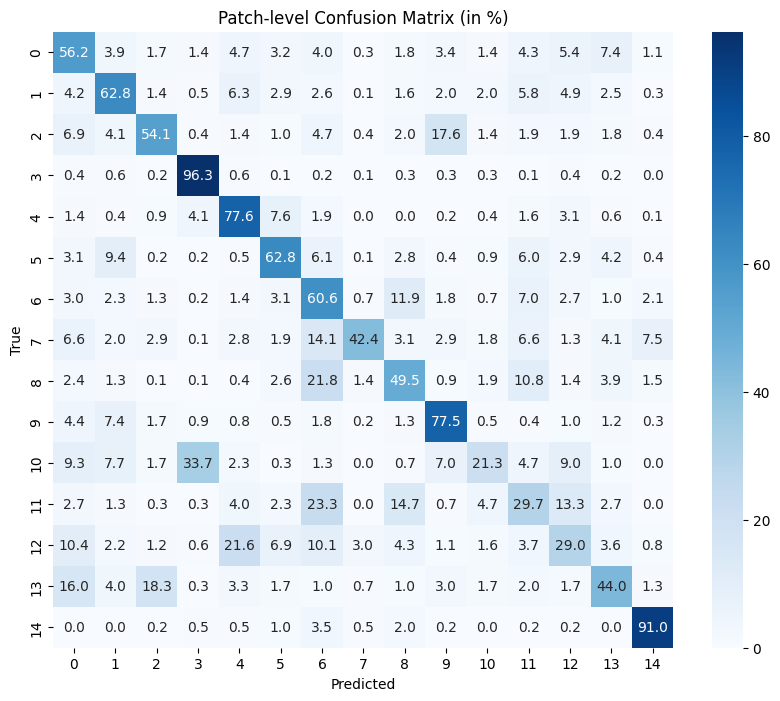

Slide-level Accuracy: 0.7770

Slide-level Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       374
           1       0.79      0.76      0.77        79
           2       0.92      0.71      0.80        82
           3       0.91      1.00      0.95        29
           4       0.41      1.00      0.58        14
           5       0.55      0.89      0.68        18
           6       0.75      0.89      0.82        47
           7       1.00      0.67      0.80        57
           8       0.70      0.74      0.72        19
           9       0.77      0.87      0.82       102
          10       0.29      0.67      0.40         3
          11       0.05      0.33      0.08         3
          12       0.12      0.33      0.17         9
          13       0.09      0.67      0.15         3
          14       0.40      1.00      0.57         4

    accuracy                           0.78       843
   macro avg  

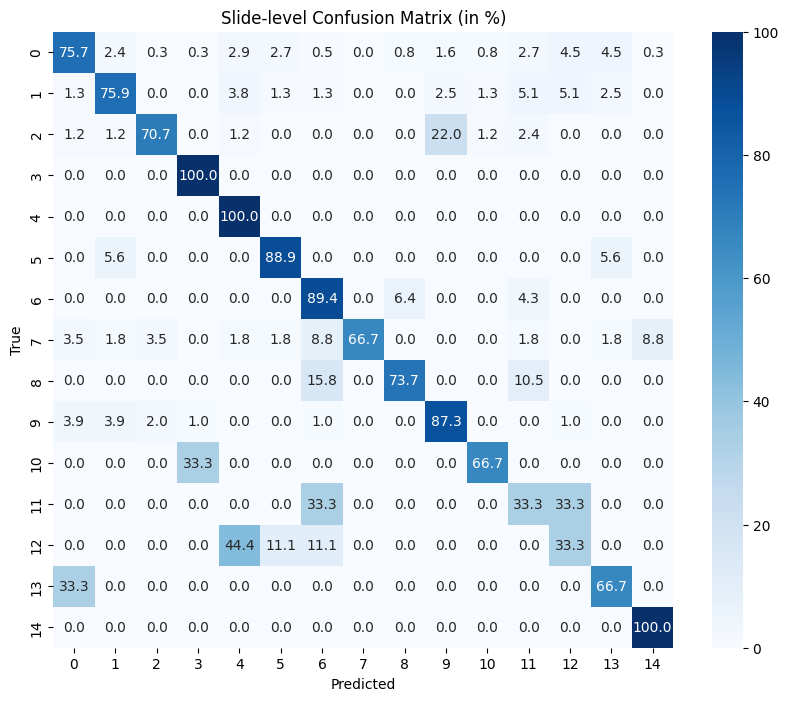

In [23]:
# test_loss /= len(test_loader.dataset)
# test_acc = test_corrects.double() / len(test_loader.dataset)

# print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()



# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(num_classes)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()

